In [1]:
import sys
sys.path.append('../src')


/Users/francescopaolonerini/anaconda3/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/francescopaolonerini/anaconda3/envs/pyg/lib/python3.12/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.12/Python
  Referenced from: <7BF3ABB0-5875-3736-8AB2-1784D3EFB687> /Users/francescopaolonerini/anaconda3/envs/pyg/lib/python3.12/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/Users/francescopaolonerini/anaconda3/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occu

# Checking explanations 

In [2]:
%load_ext autoreload
%autoreload 2


import numpy
import torch
import numpy as np
import pandas as pd
import models as models 
import datasets as datasets 
import ground_truths as gt
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, auc, precision_recall_curve
from explainers import  saliency_explainer, gnn_explainer, ig_explainer, LRP_explainer, deconvolution_explainer, random_explainer, graphmask_explainer, SubgraphX_explainer #, guided_bp_explainer, SubgraphX_explainer, 

from collections import namedtuple
from tqdm import tqdm

from torch_geometric import seed_everything
import warnings

warnings.filterwarnings("ignore")

import argparse

import networkx as nx

import matplotlib.pyplot as plt

import torch_geometric.utils as tgu



/Users/francescopaolonerini/anaconda3/envs/pyg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/1 [00:00<?, ?it/s]

LPModel
IntegratedGradients


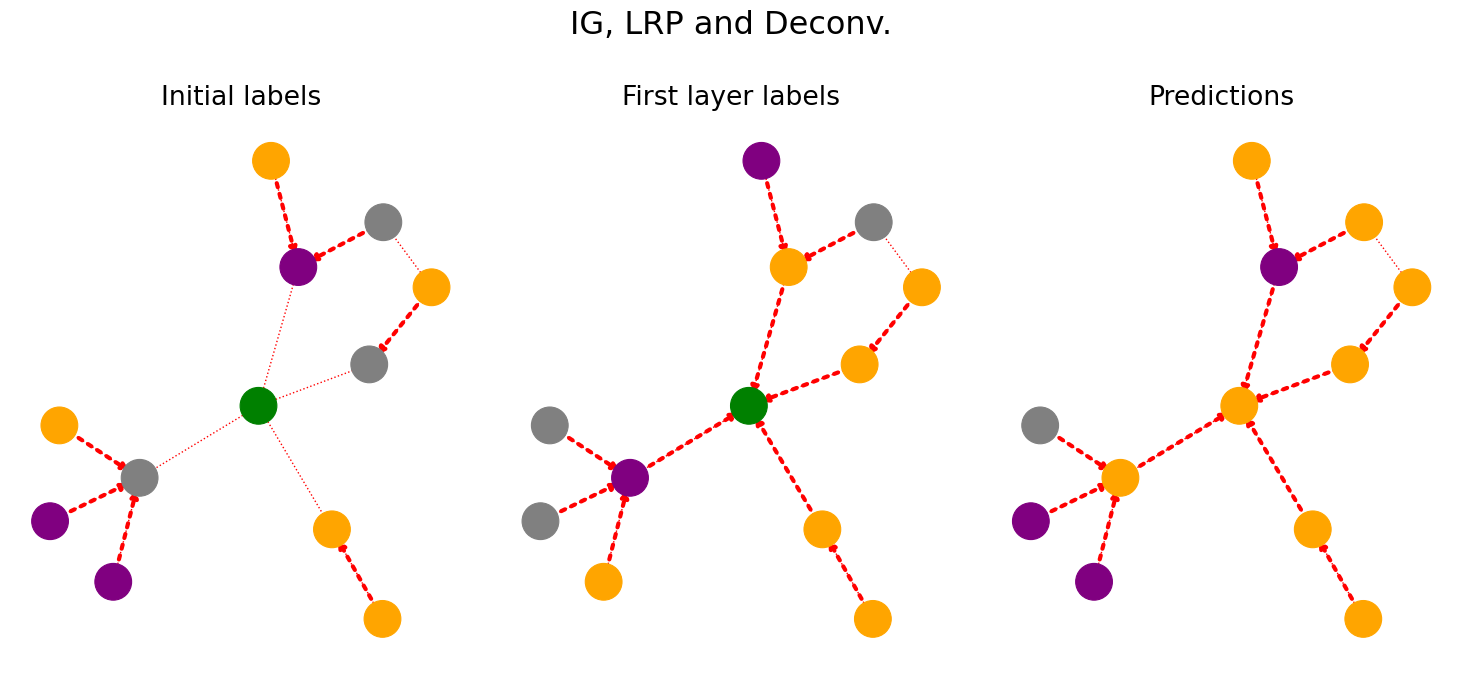

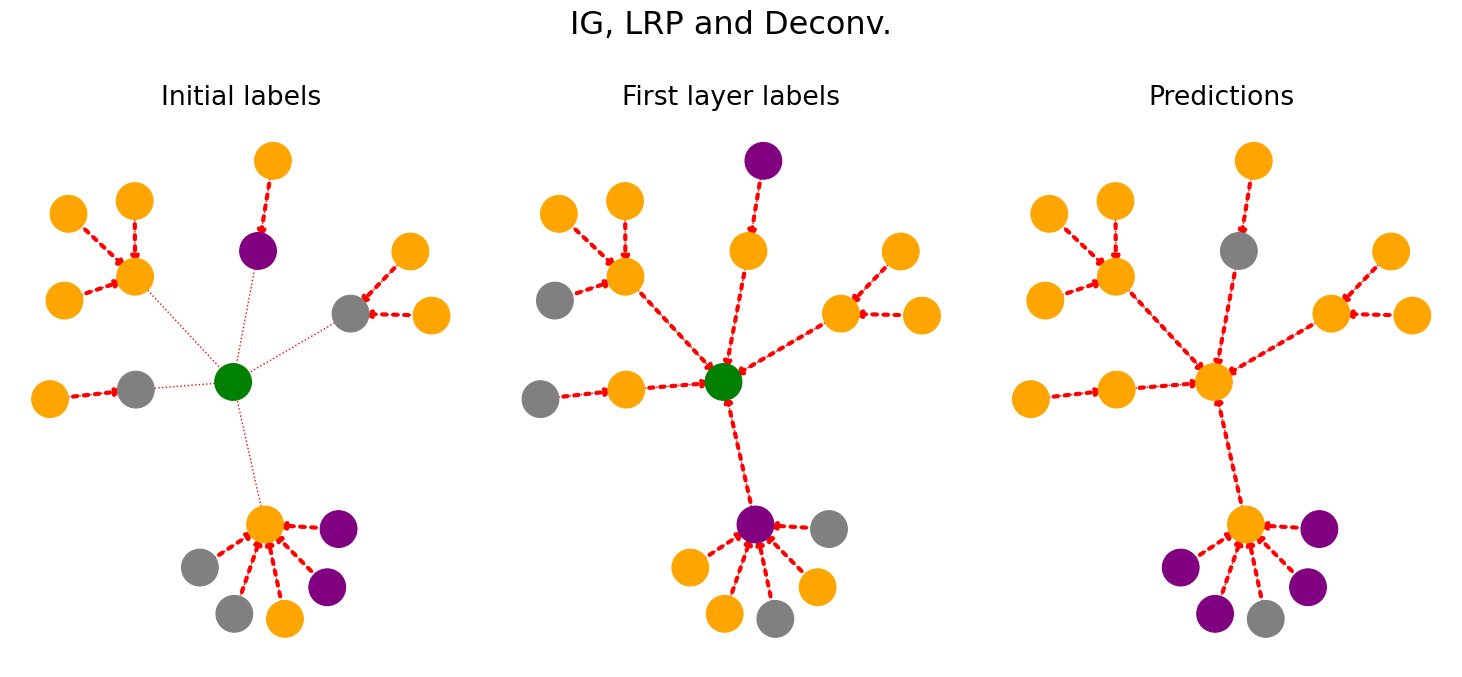

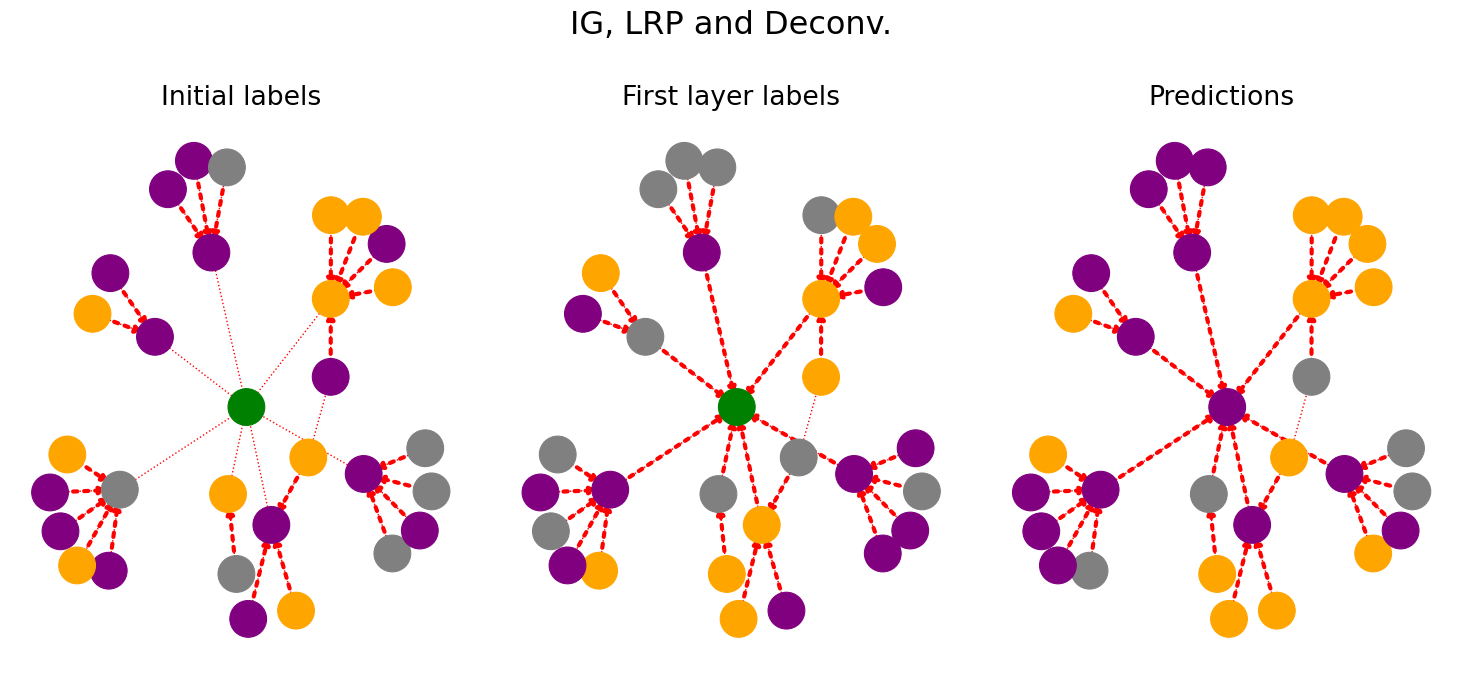

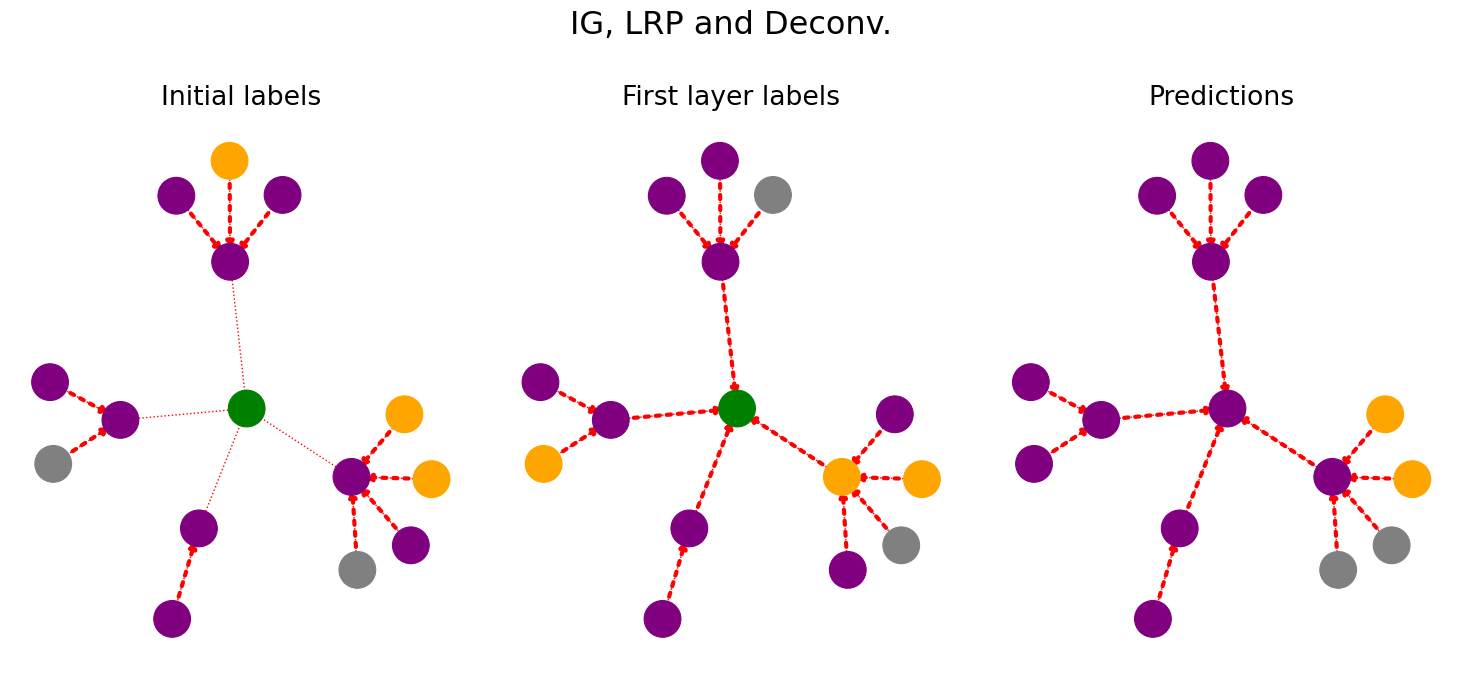

Deconvolution


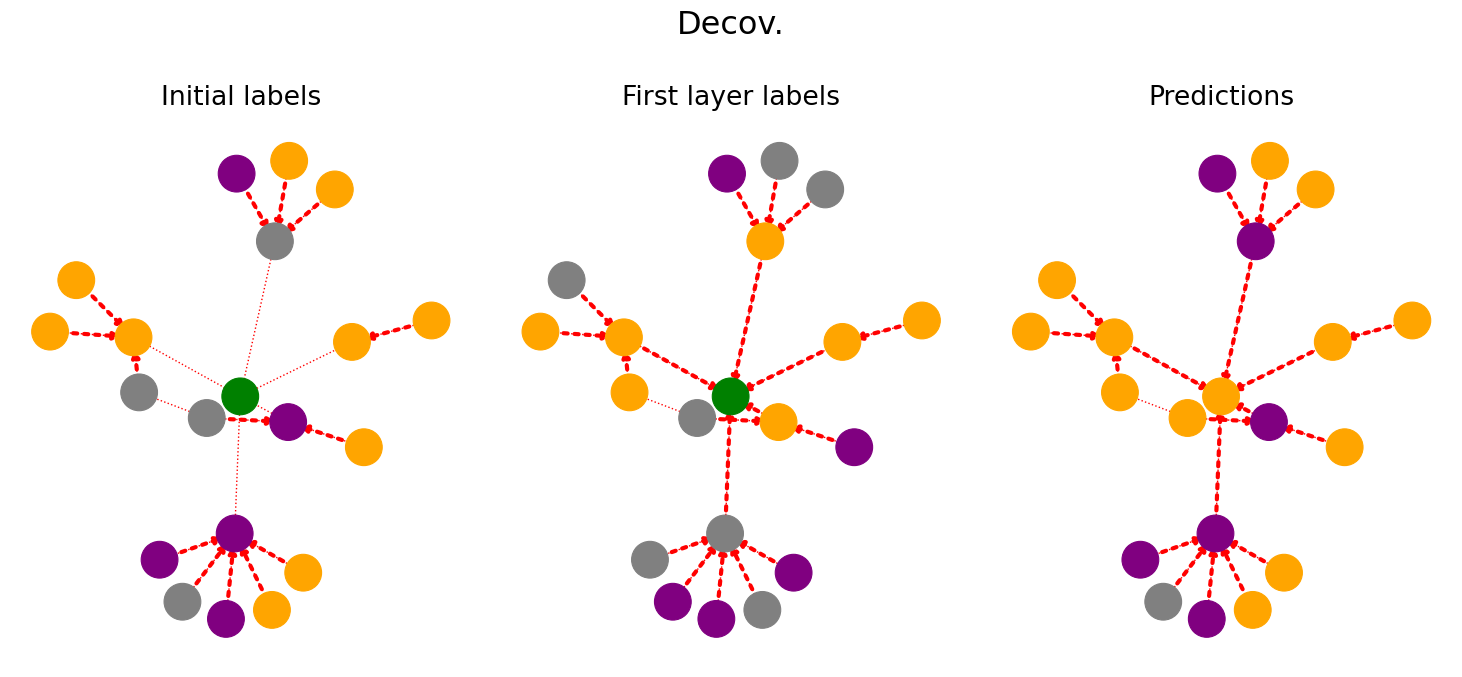

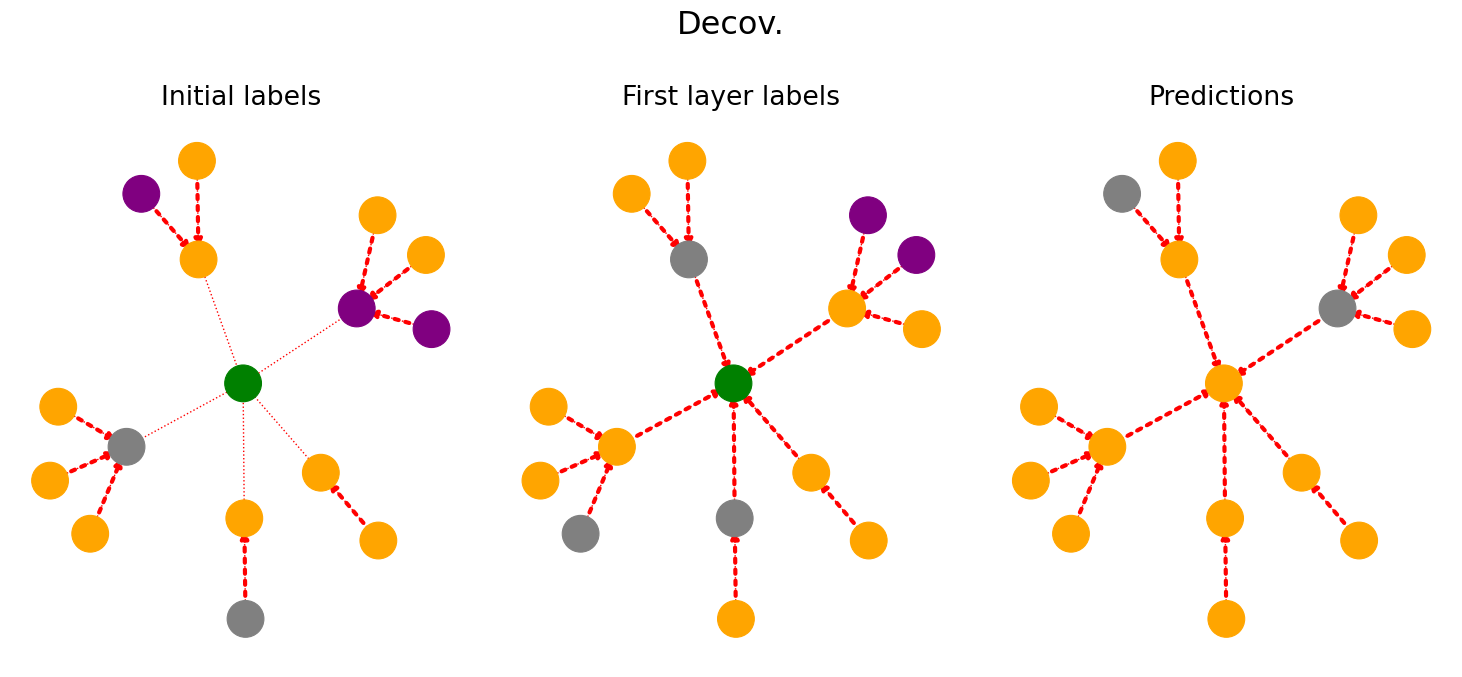

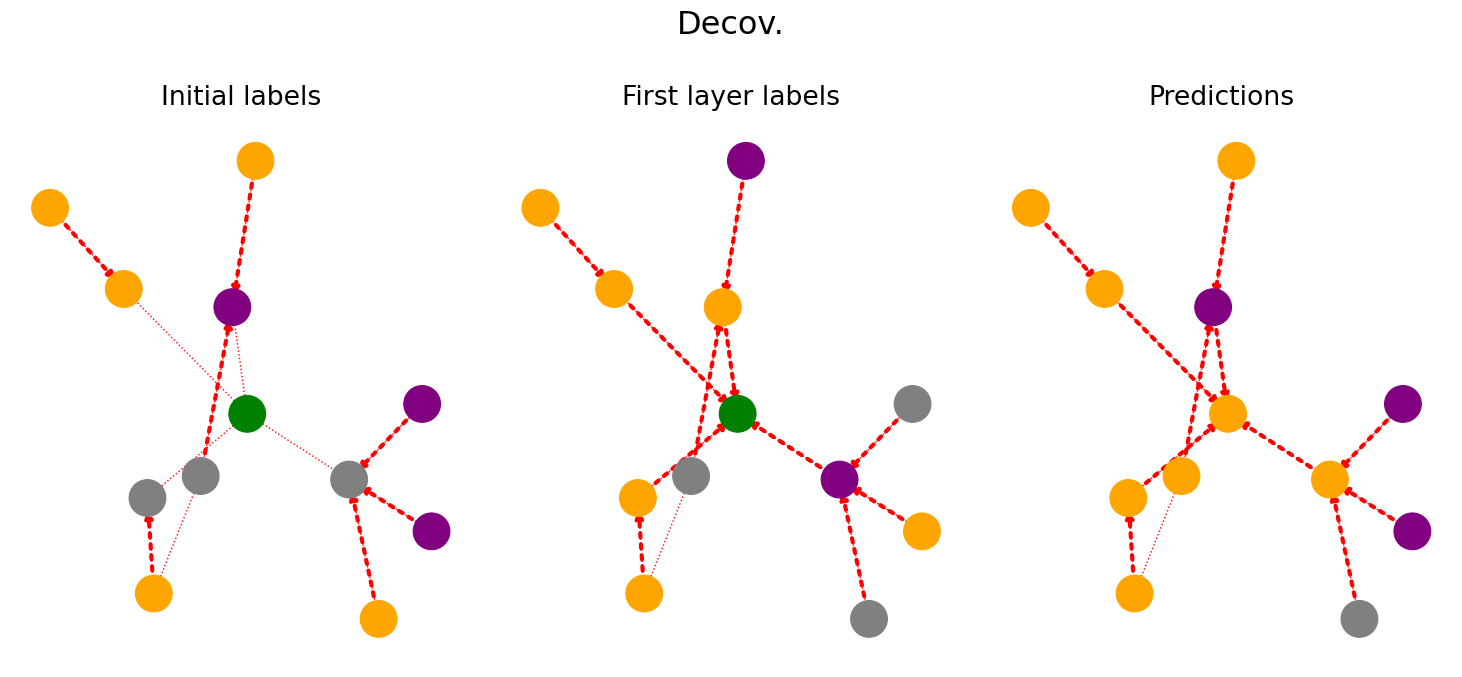

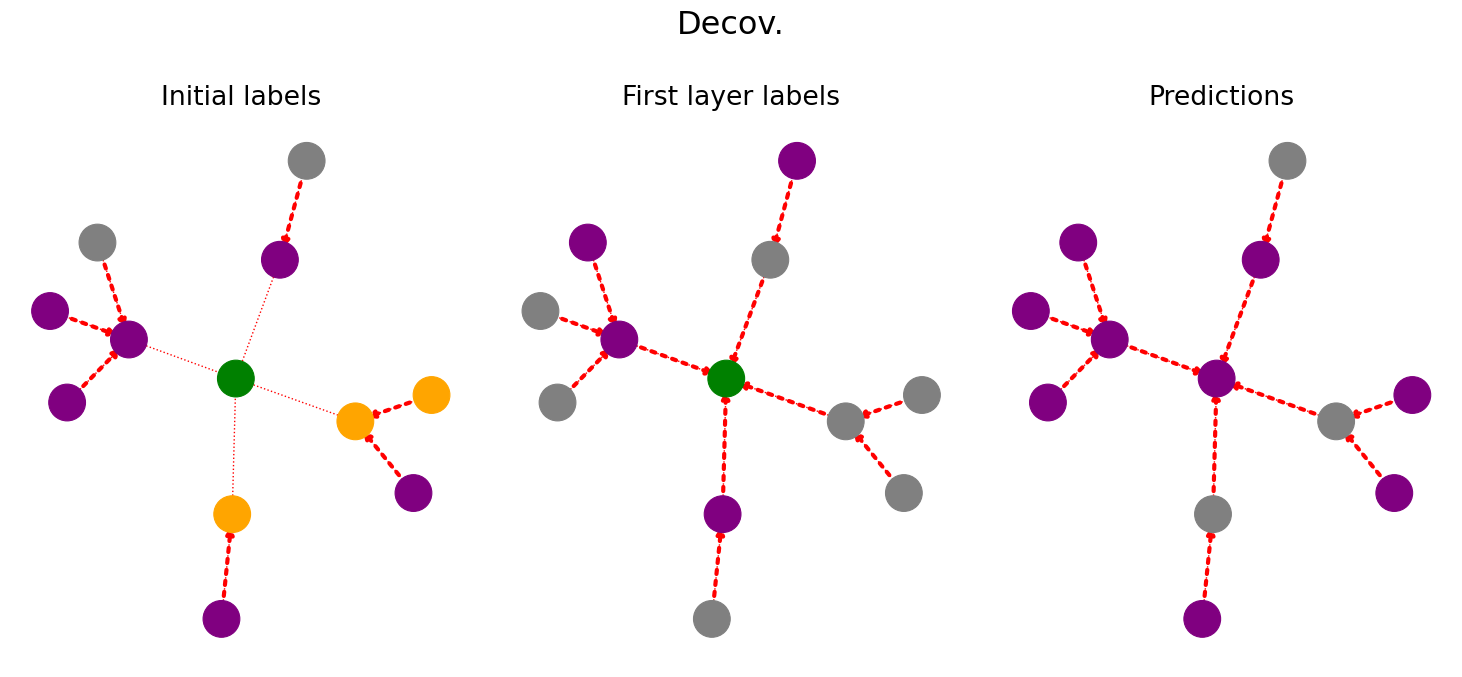

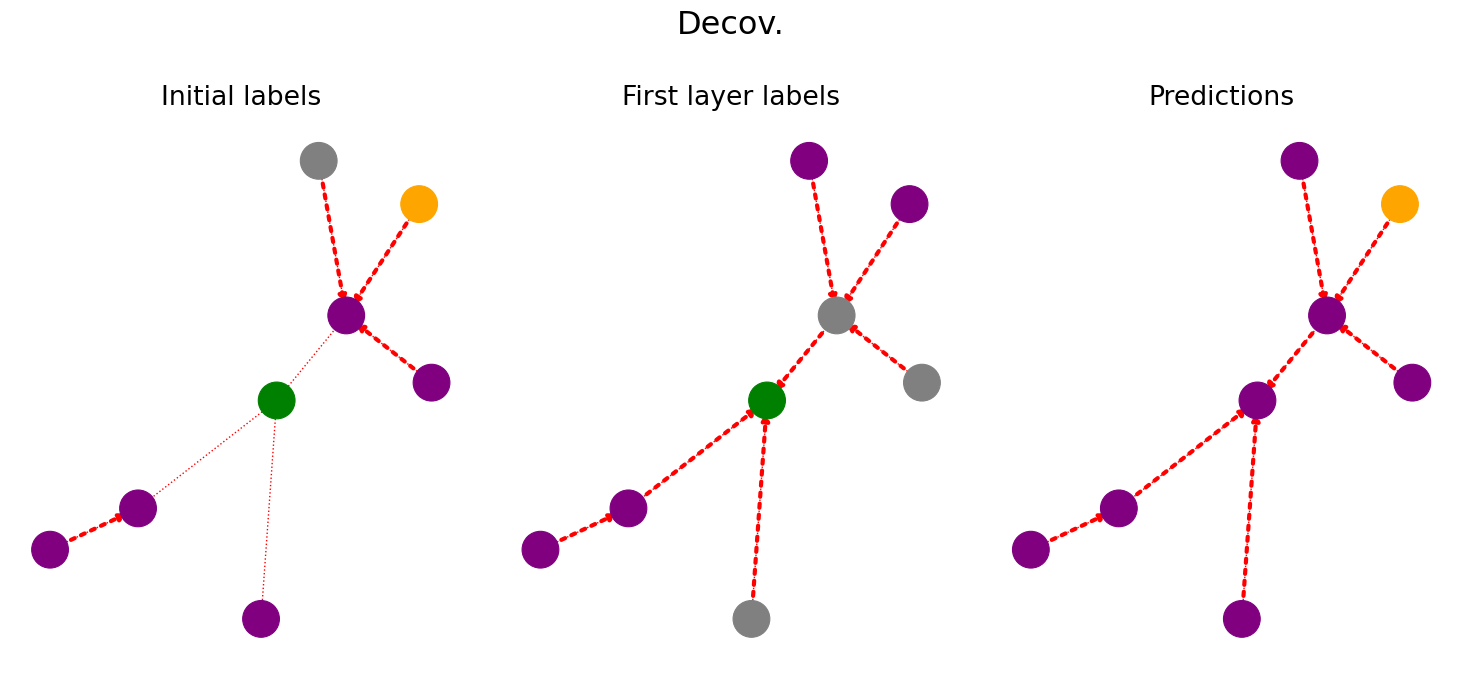

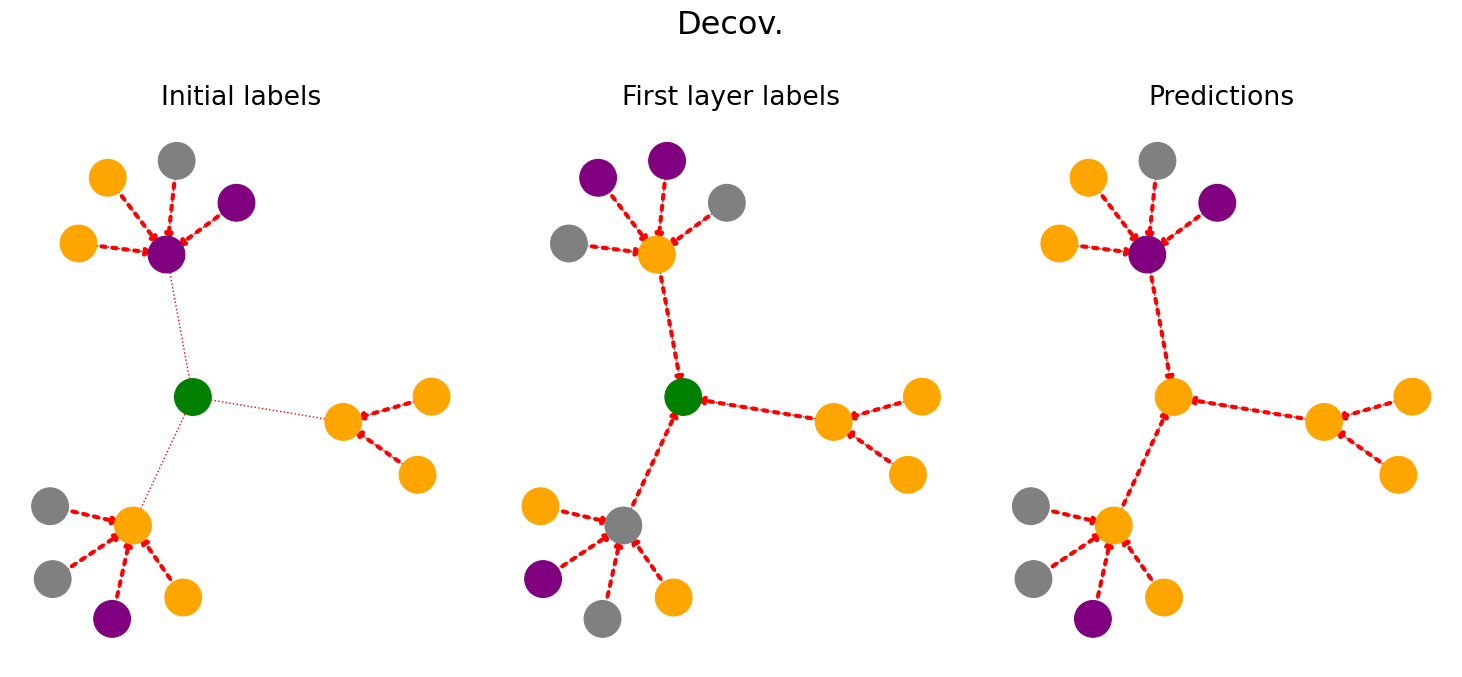

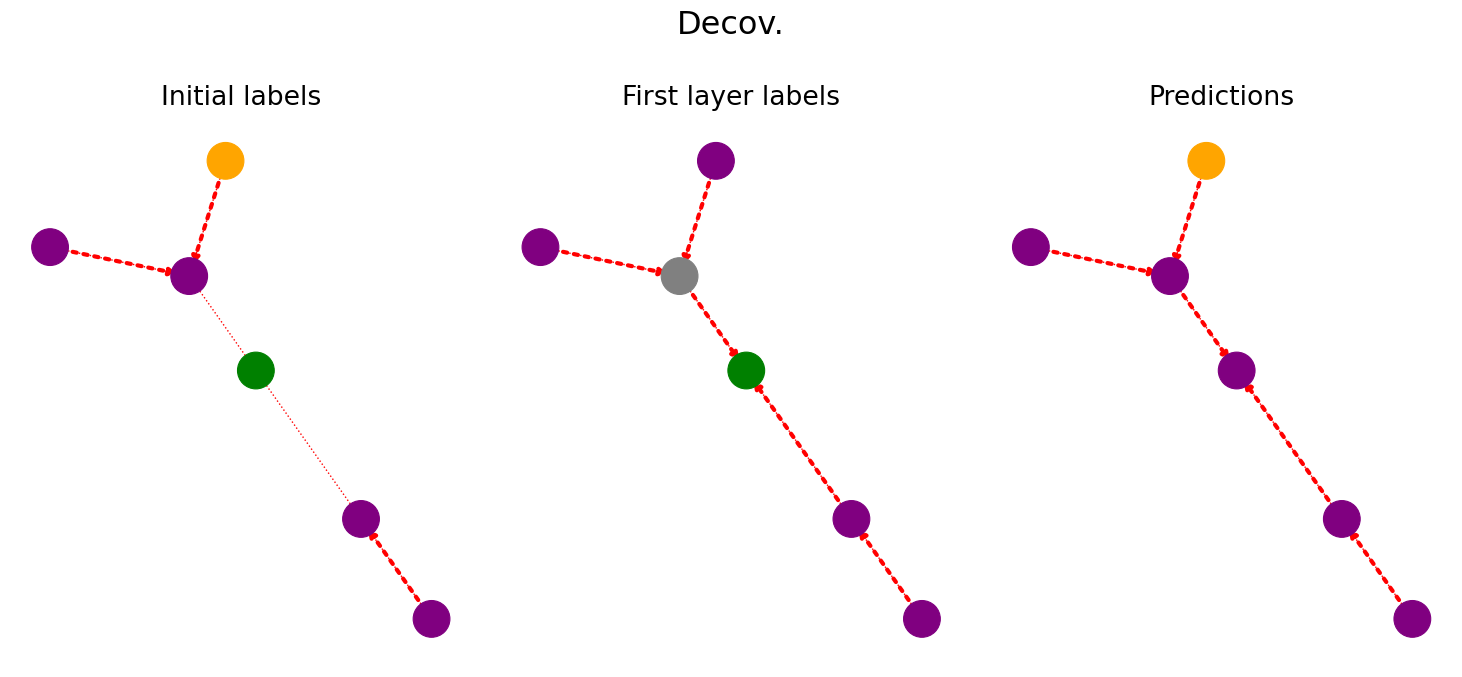

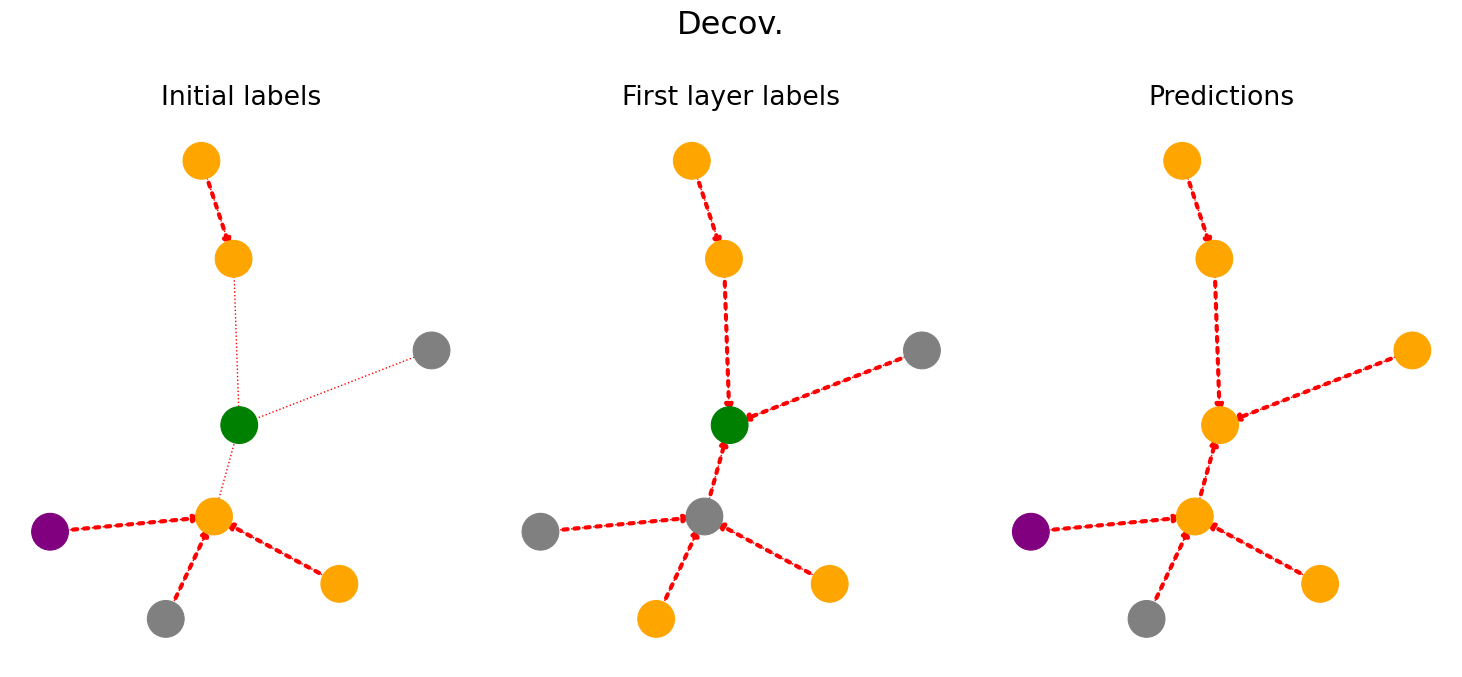

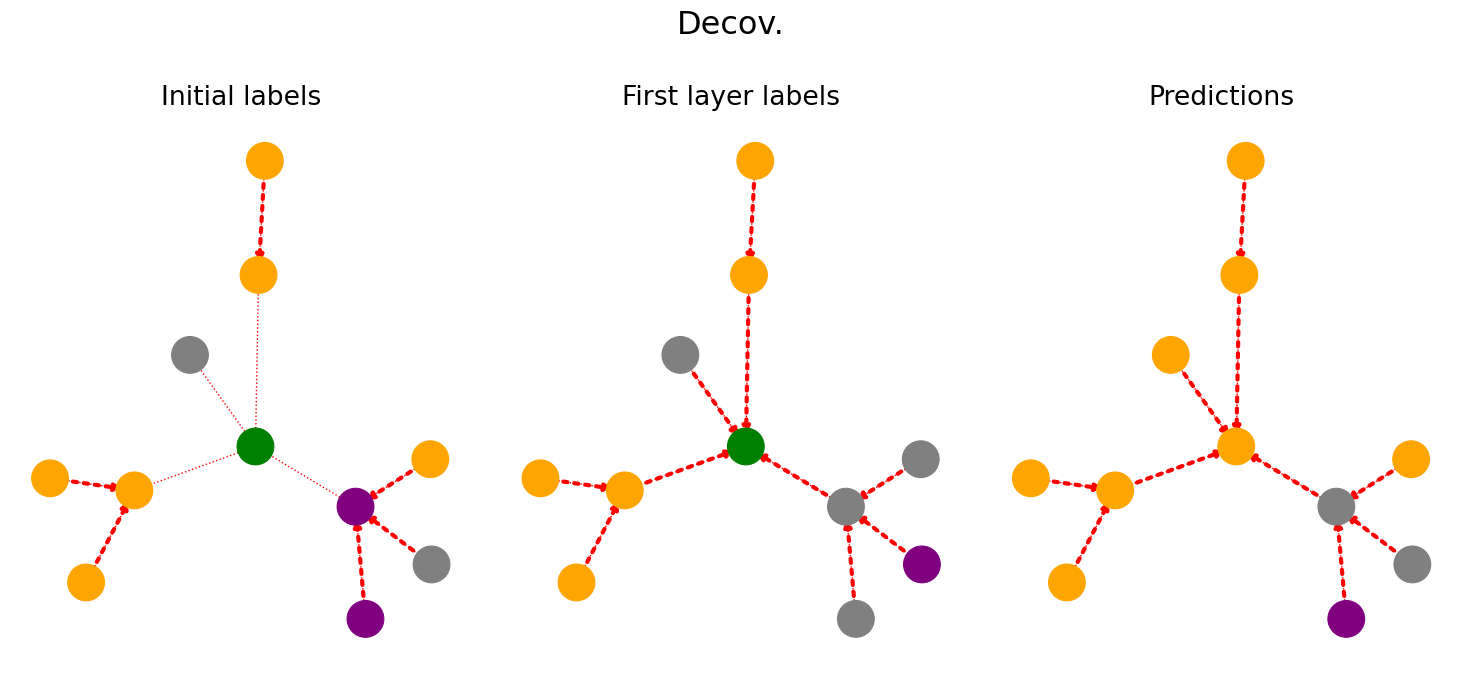

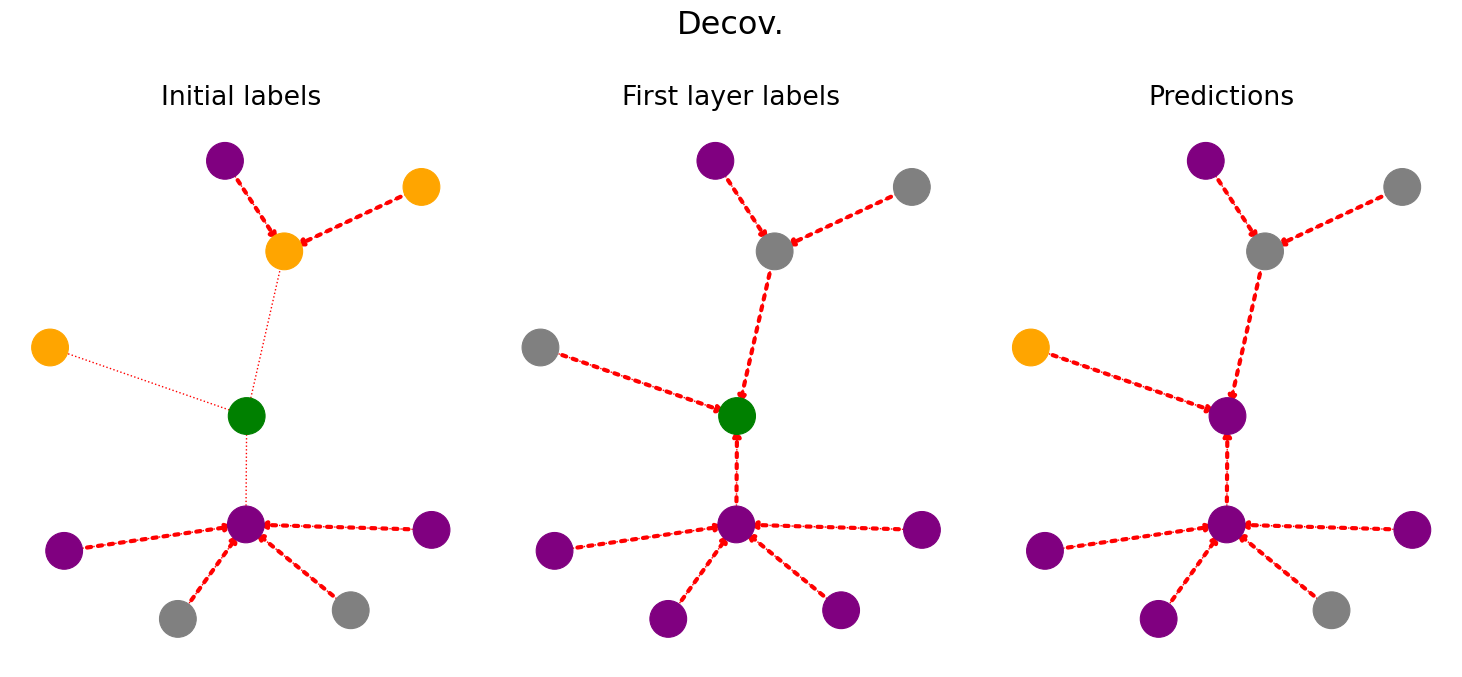

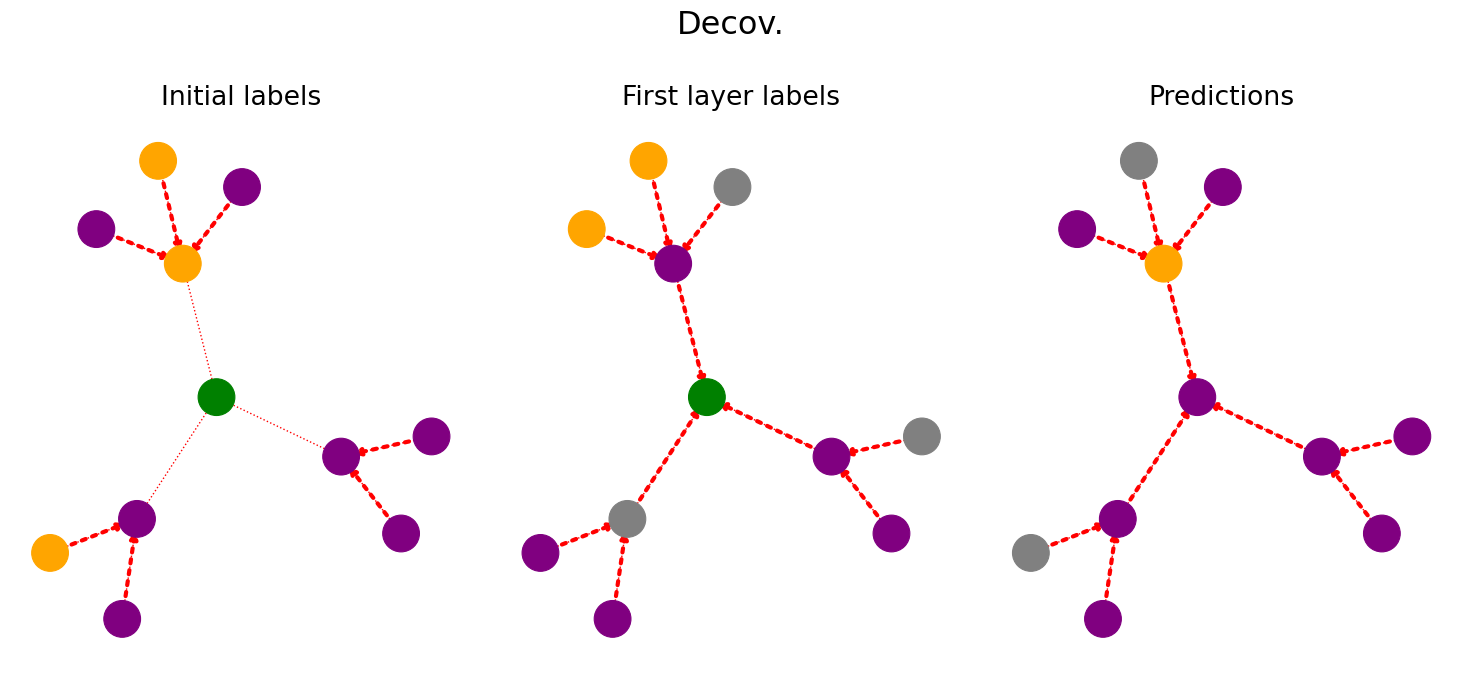

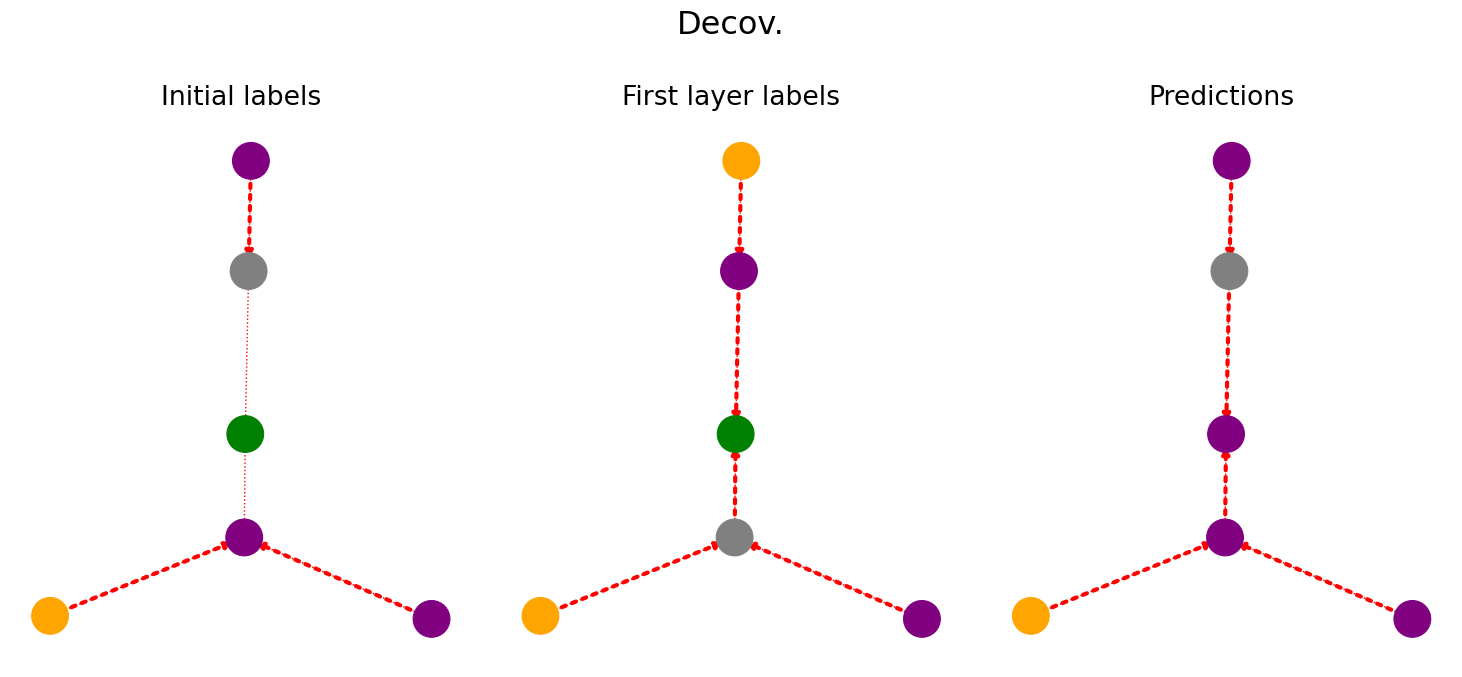

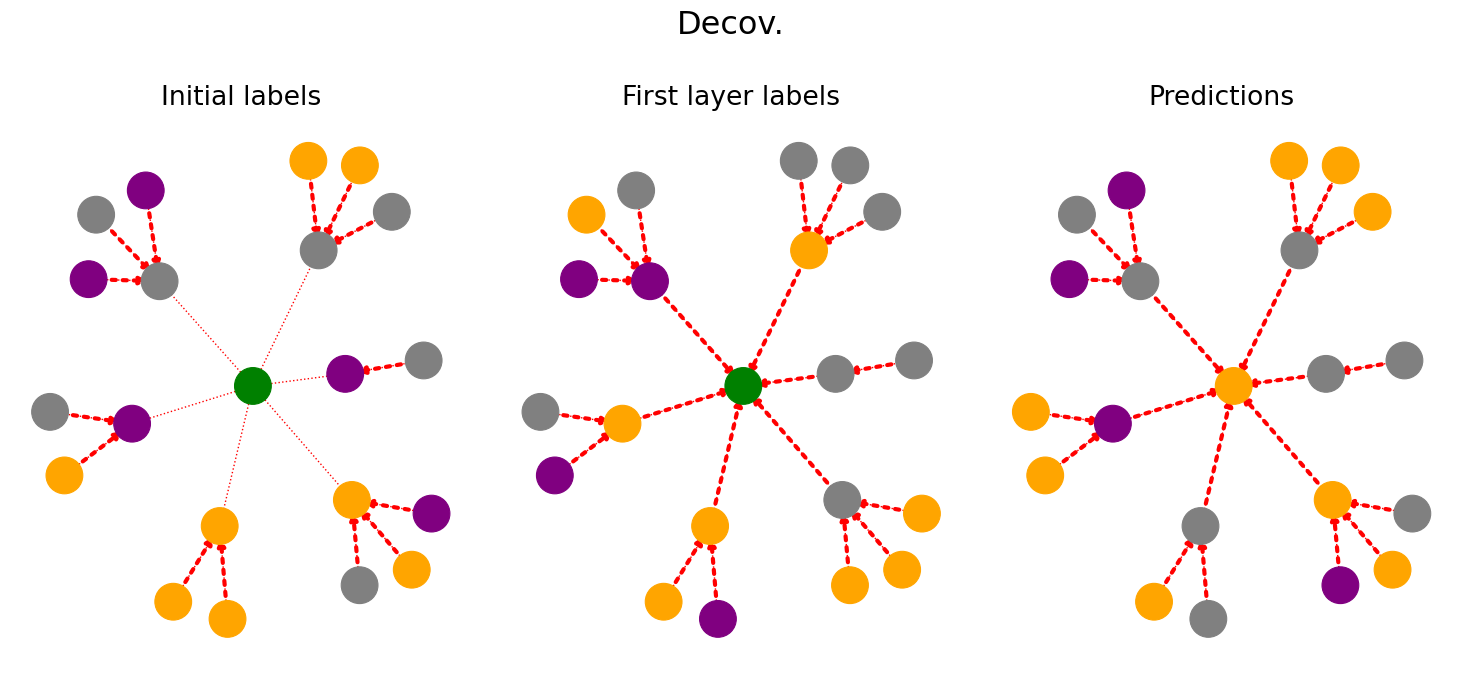

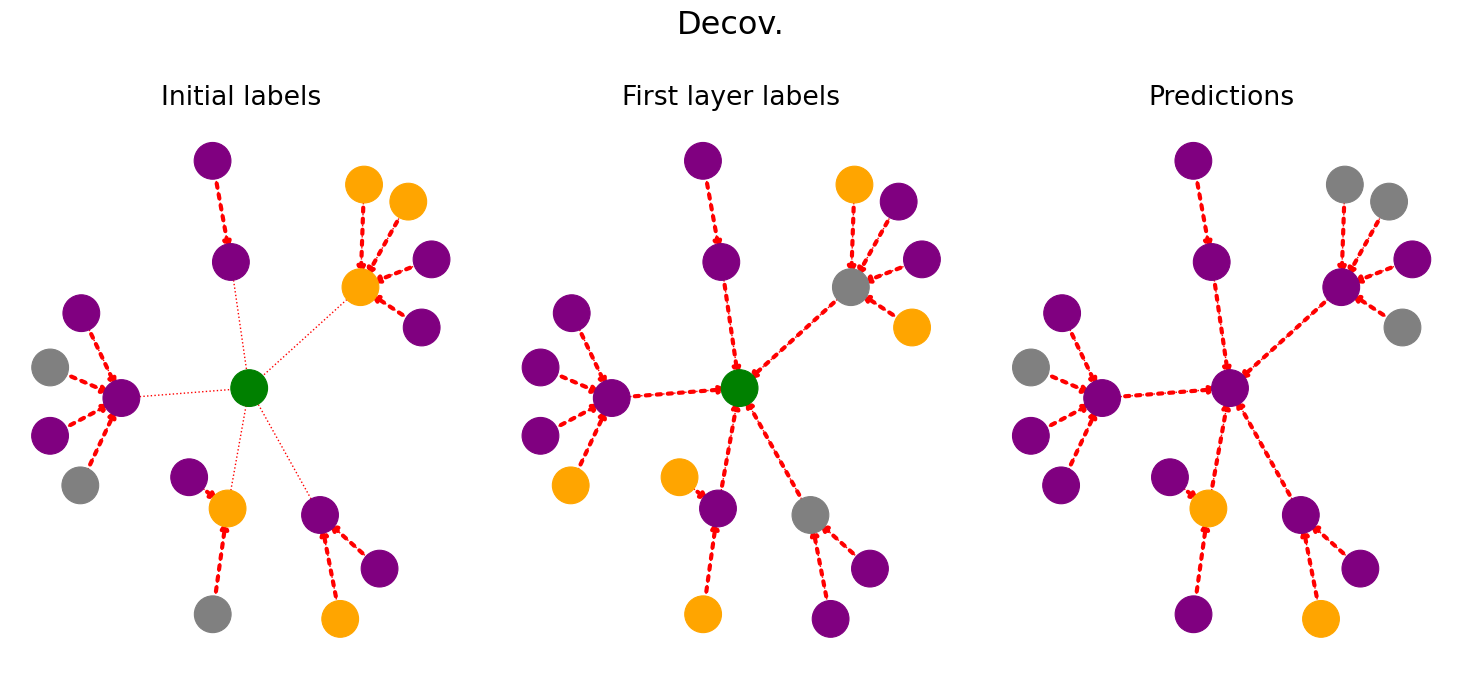

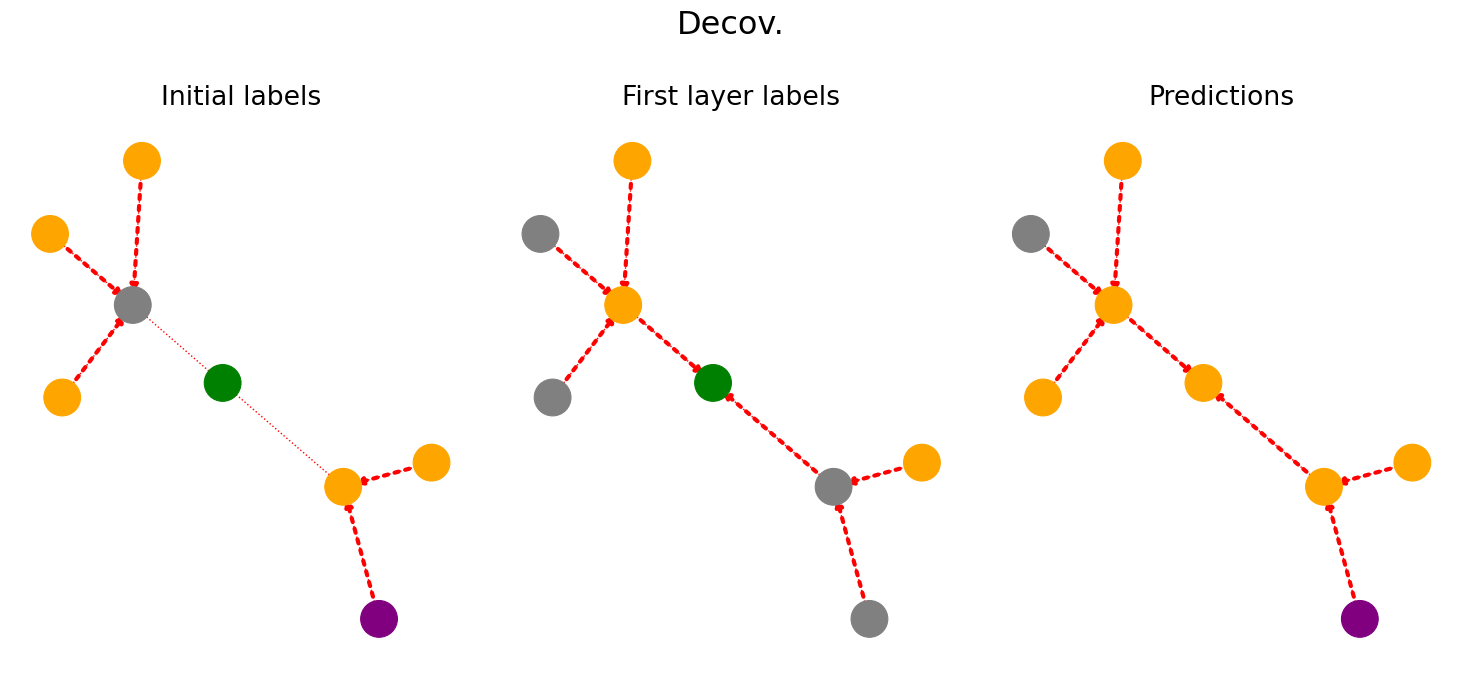

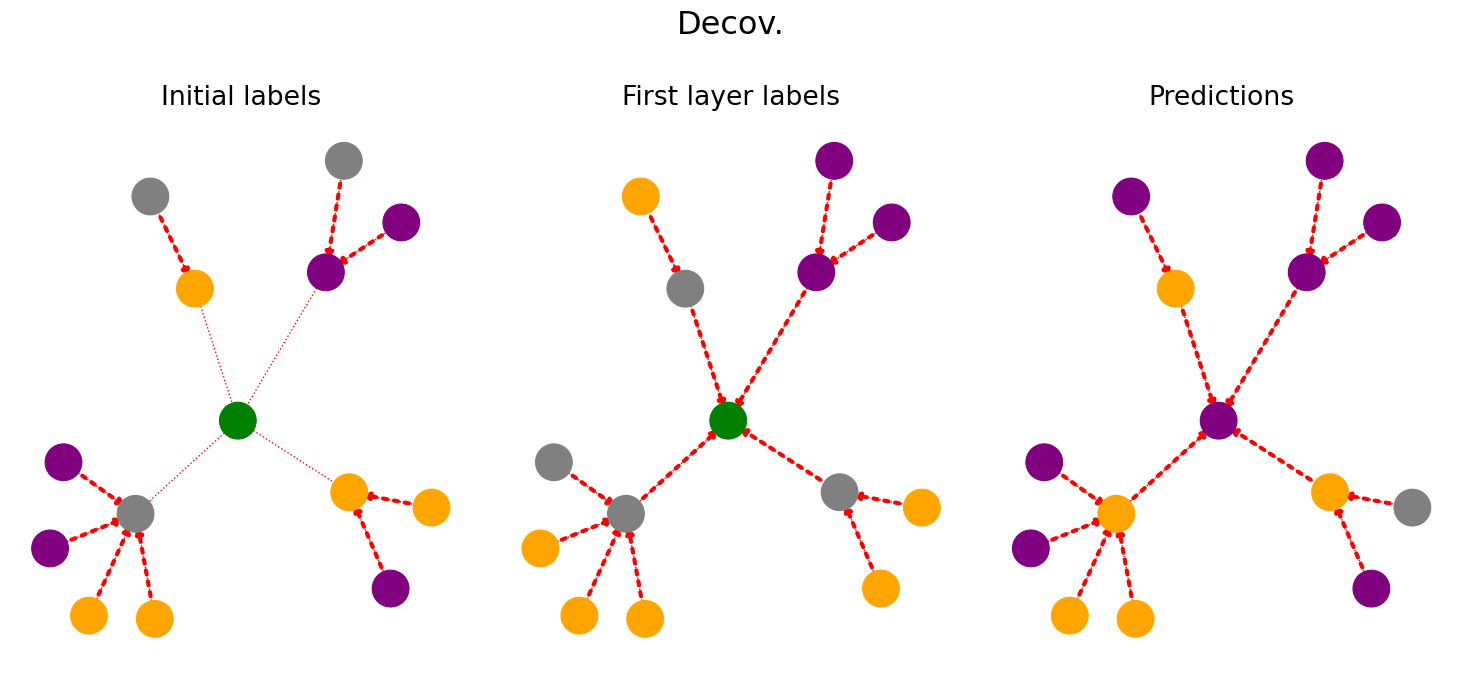

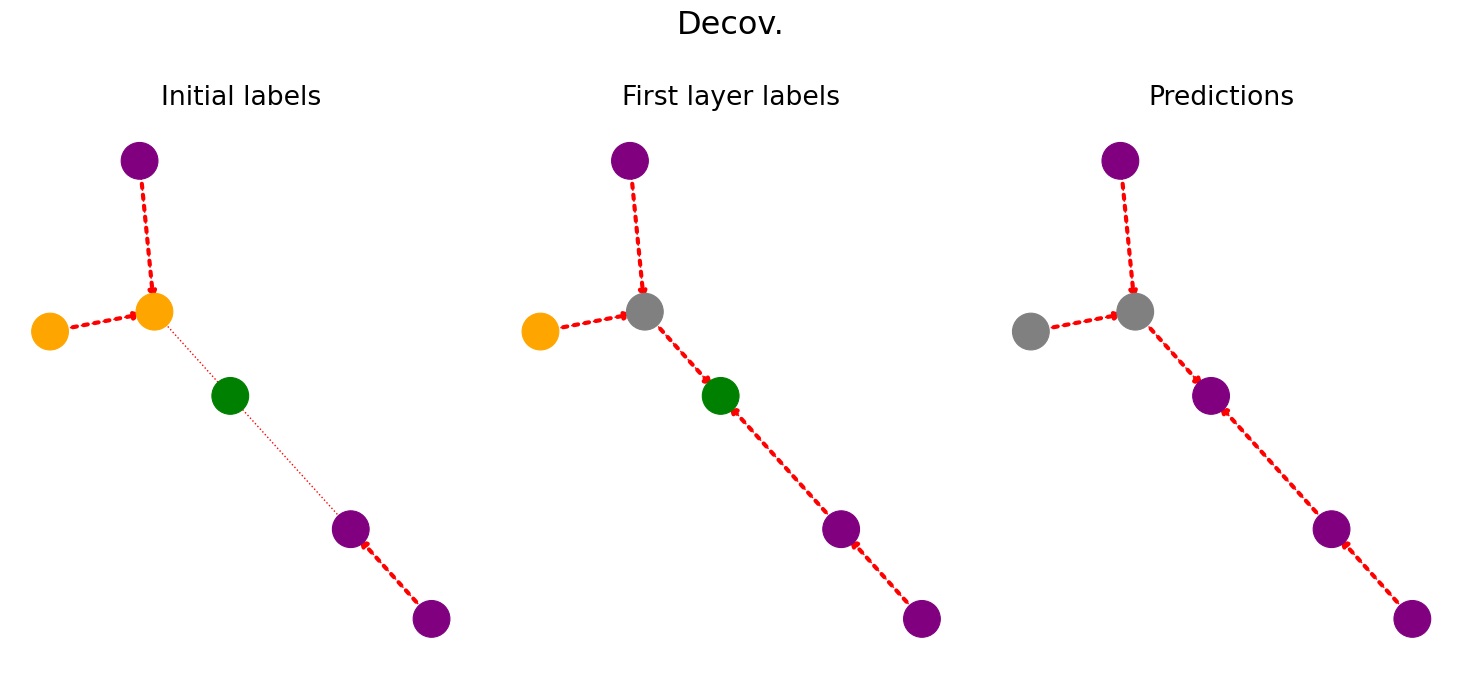

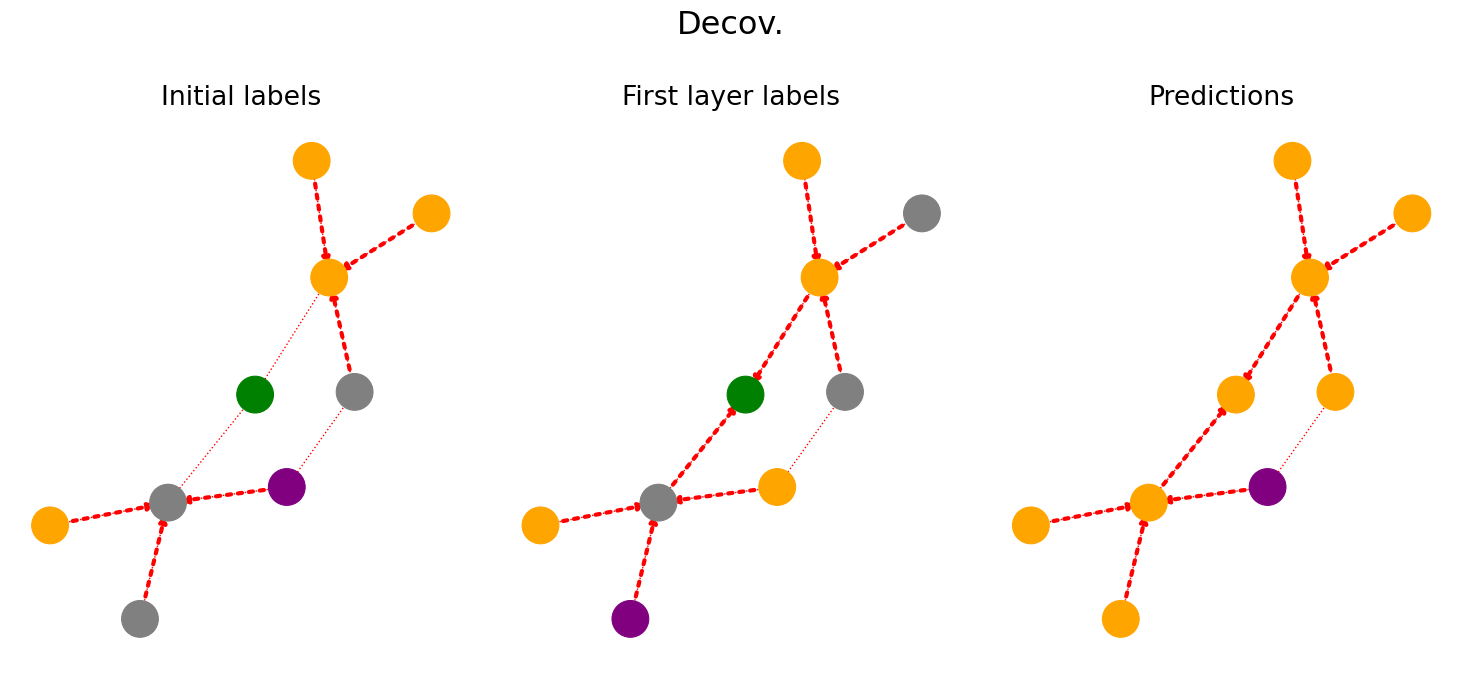

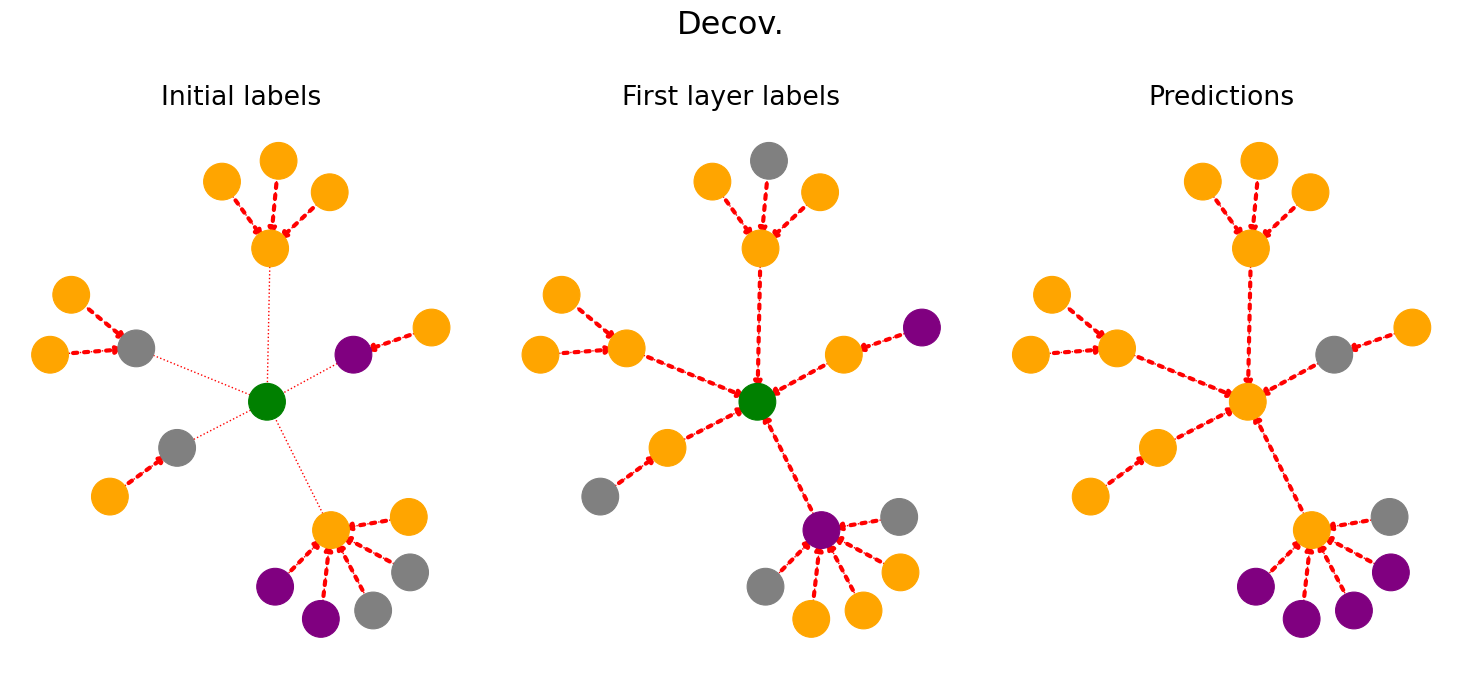

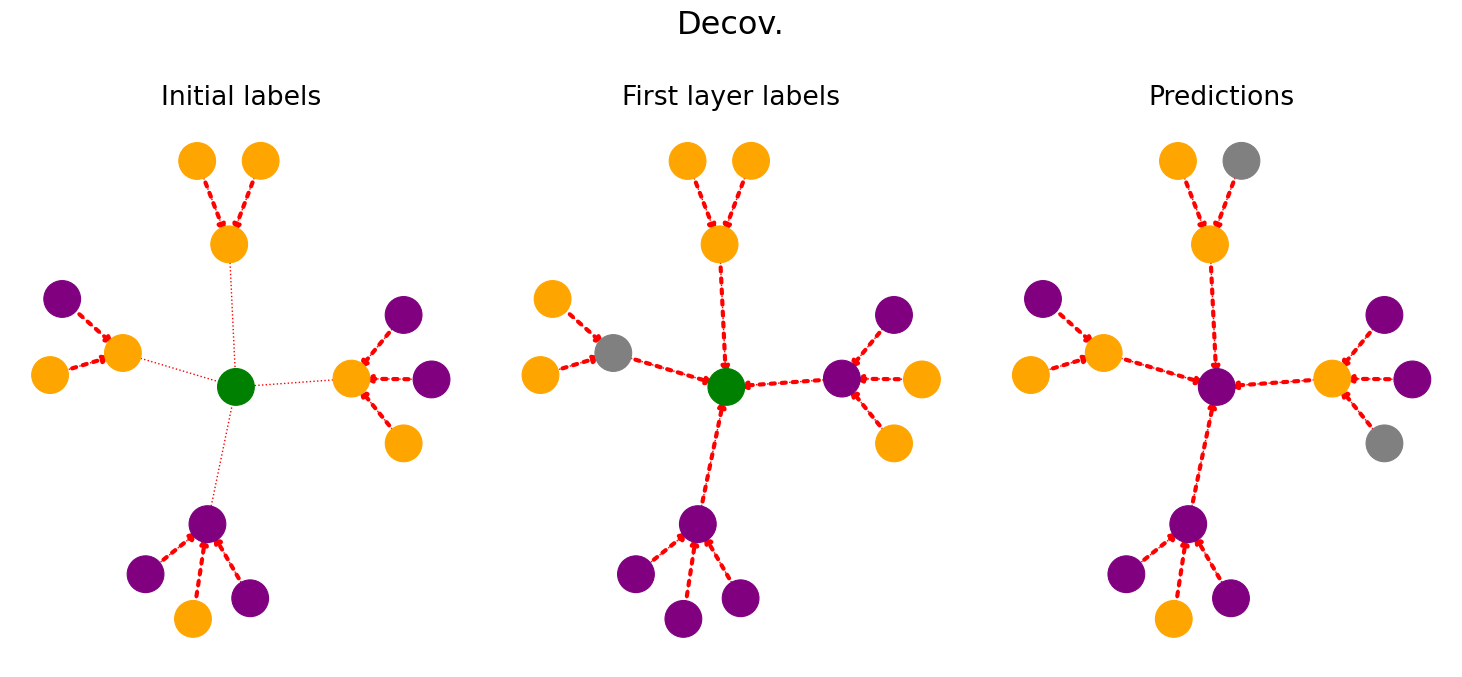

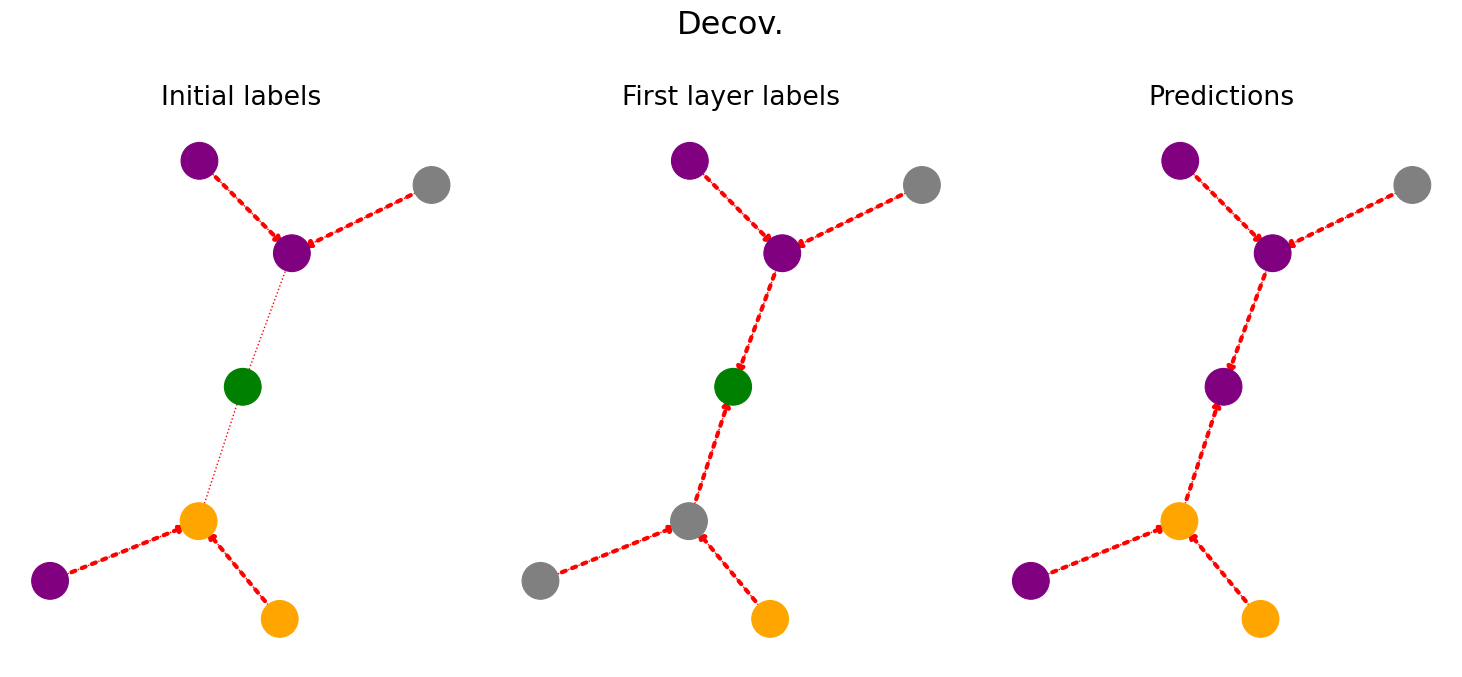

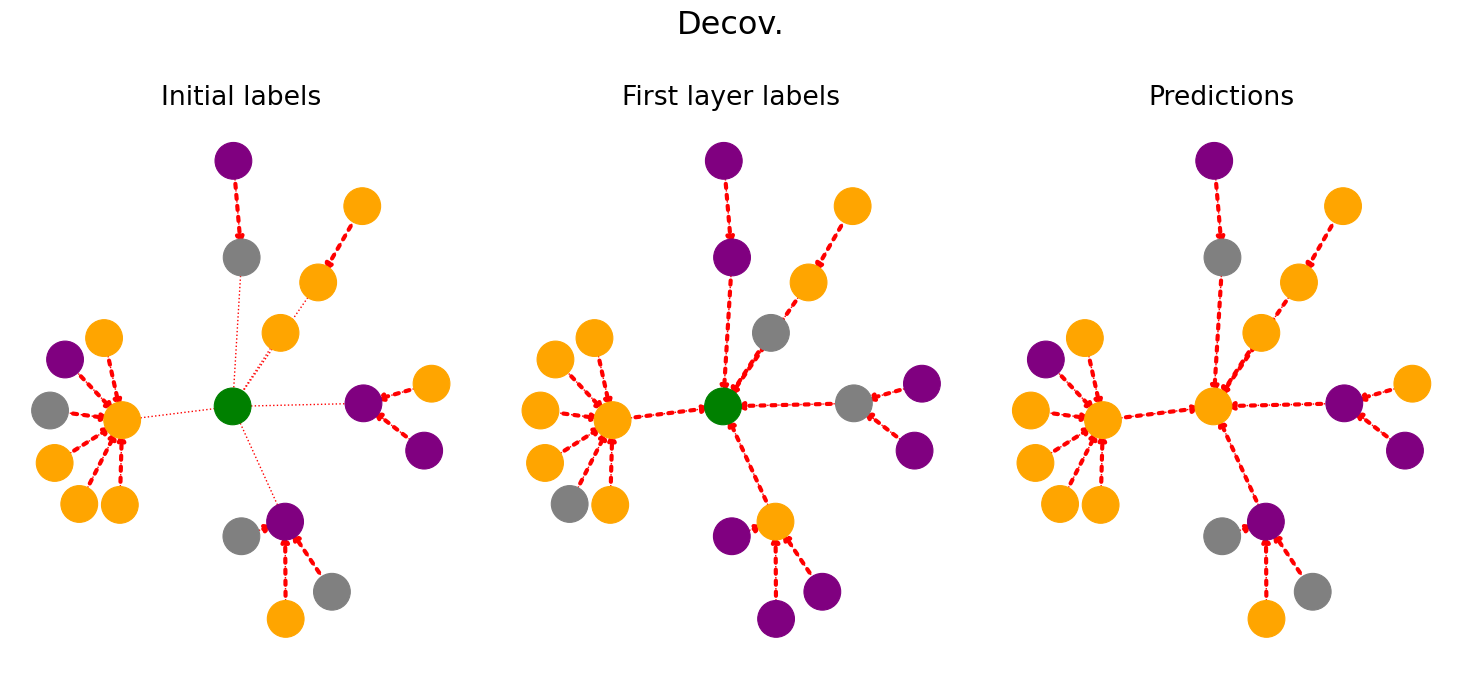

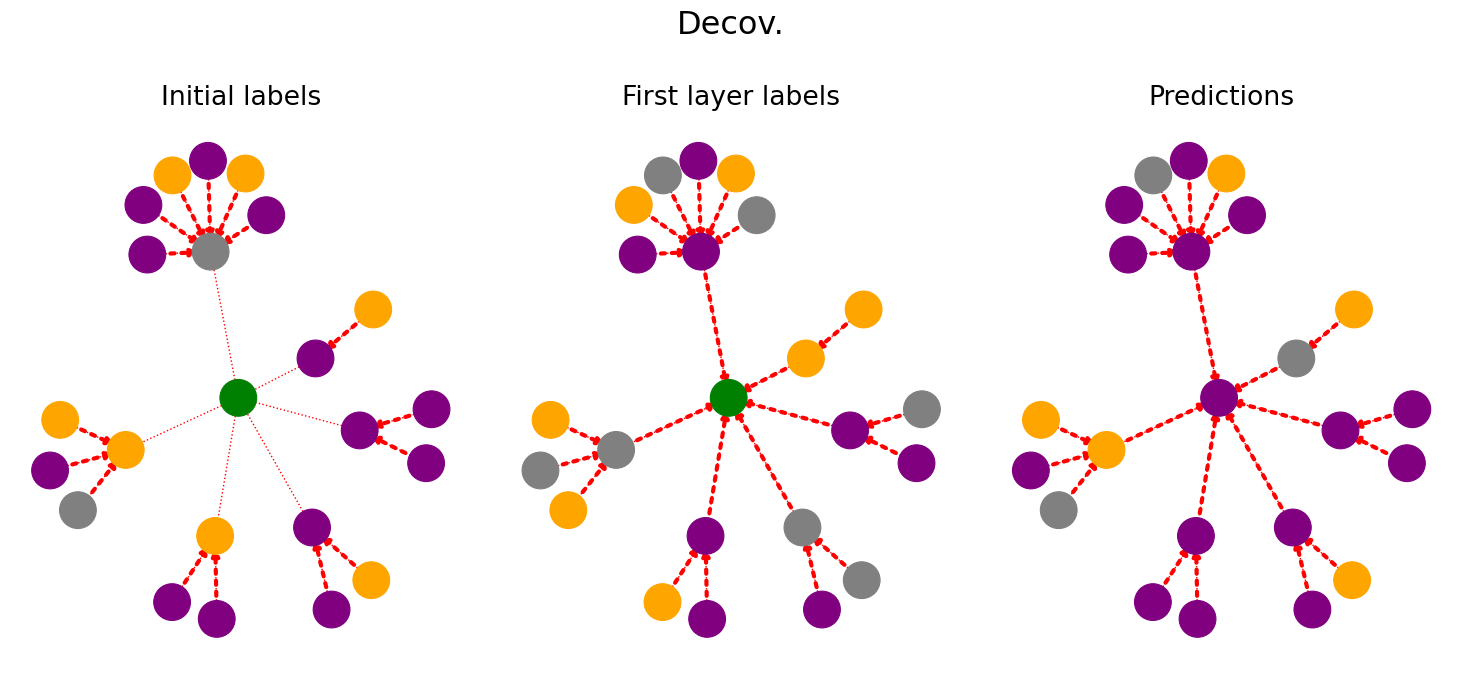

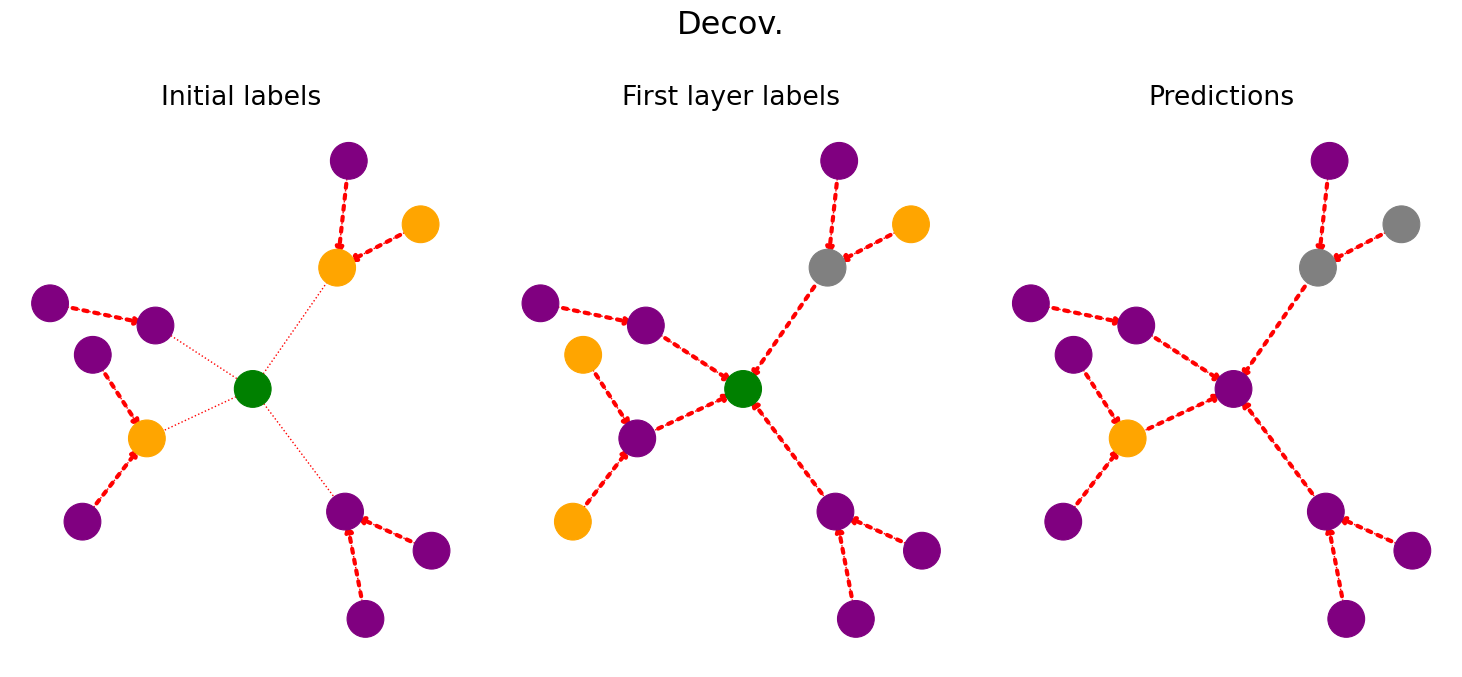

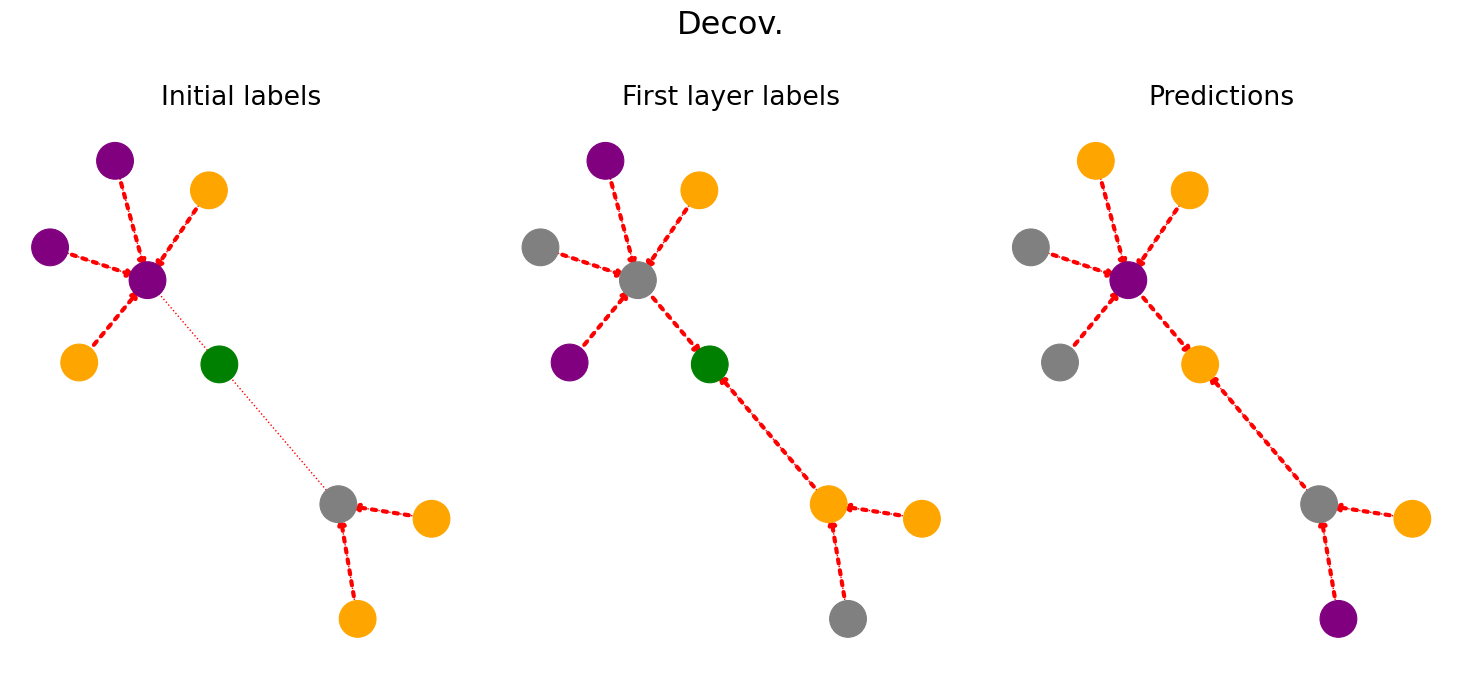

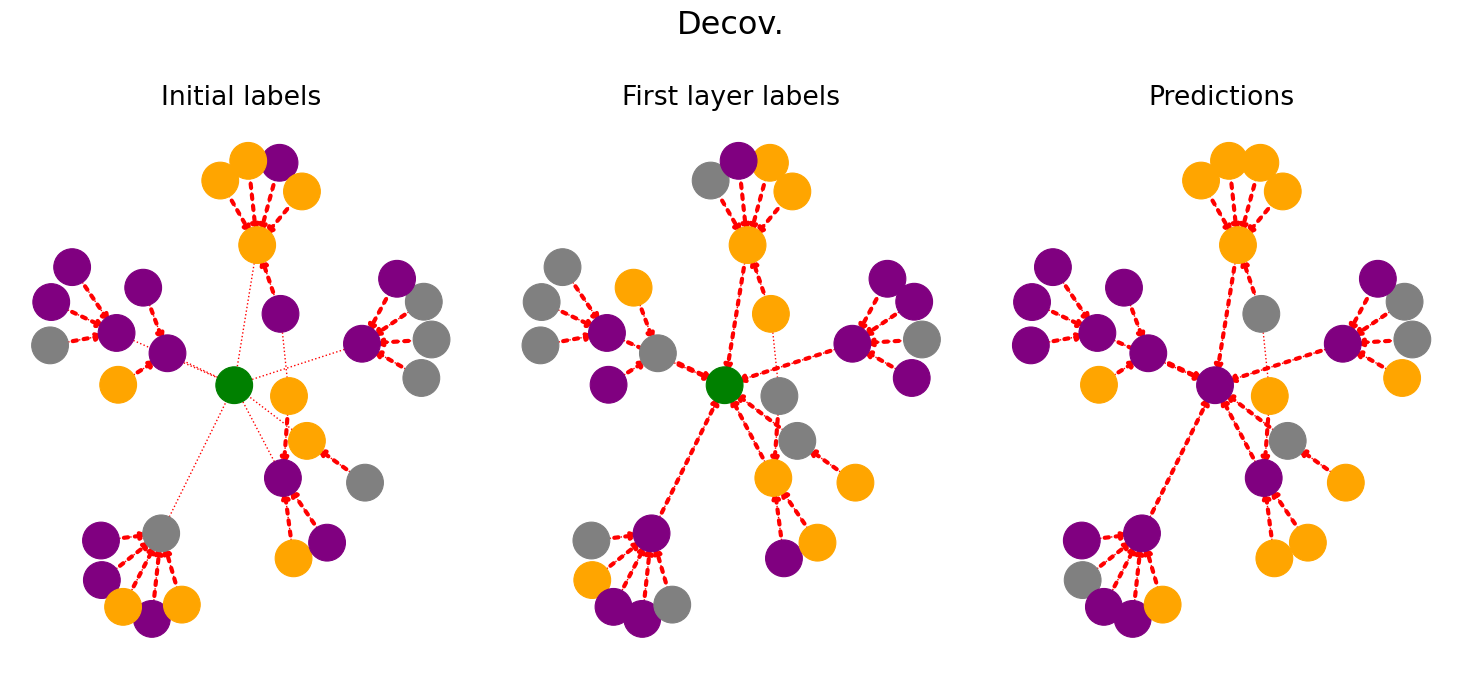

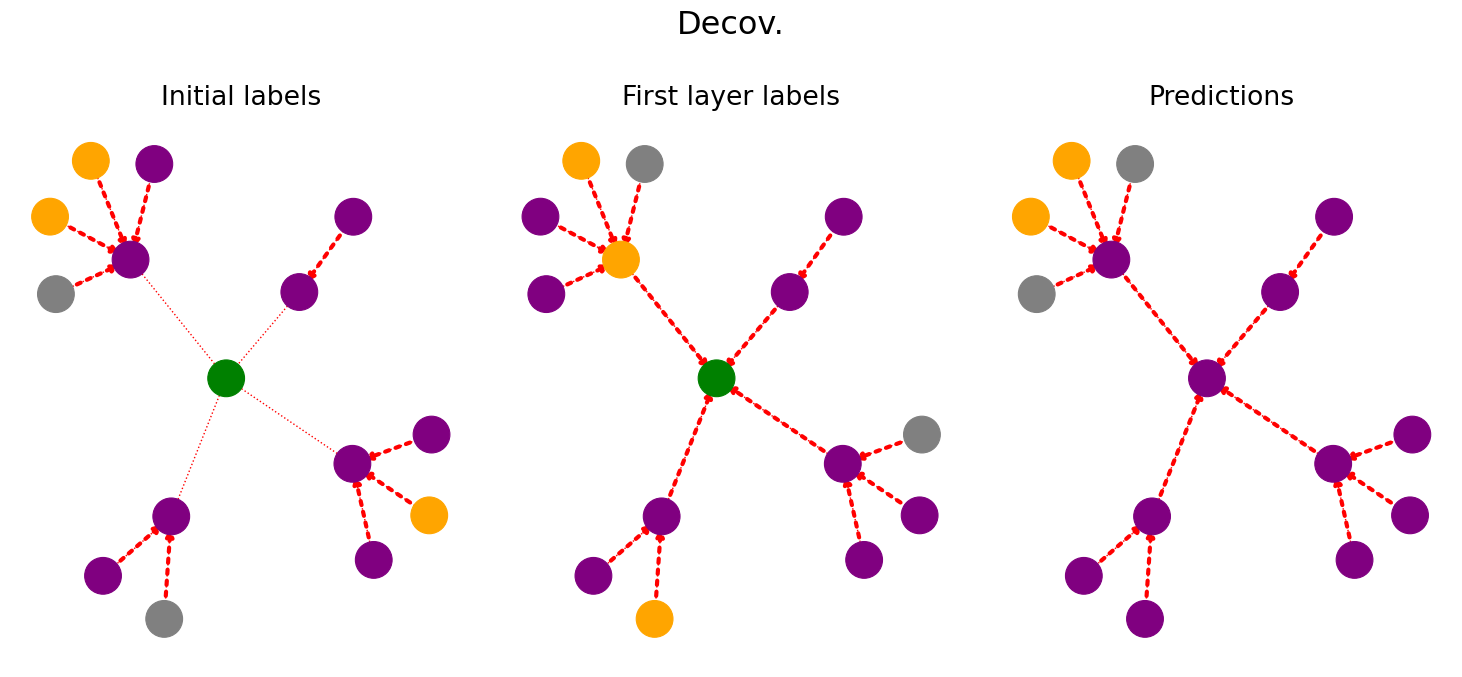

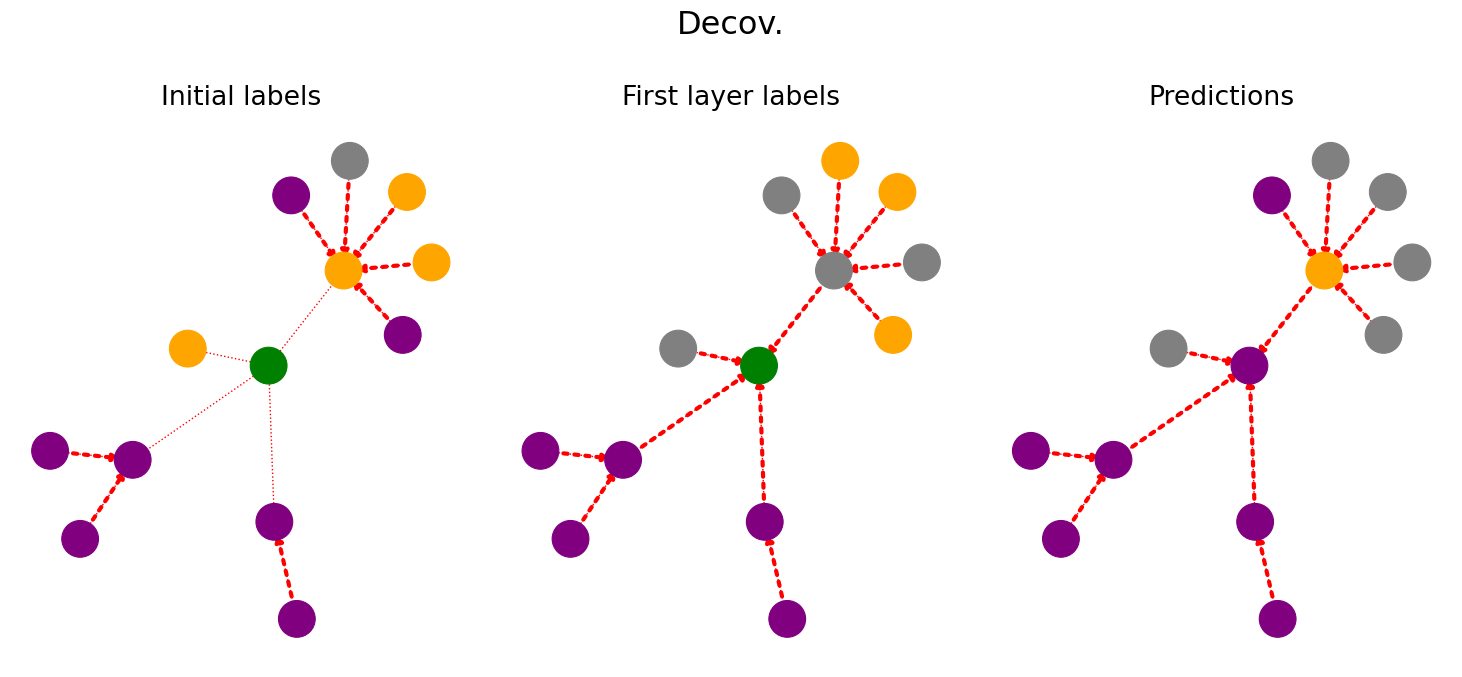

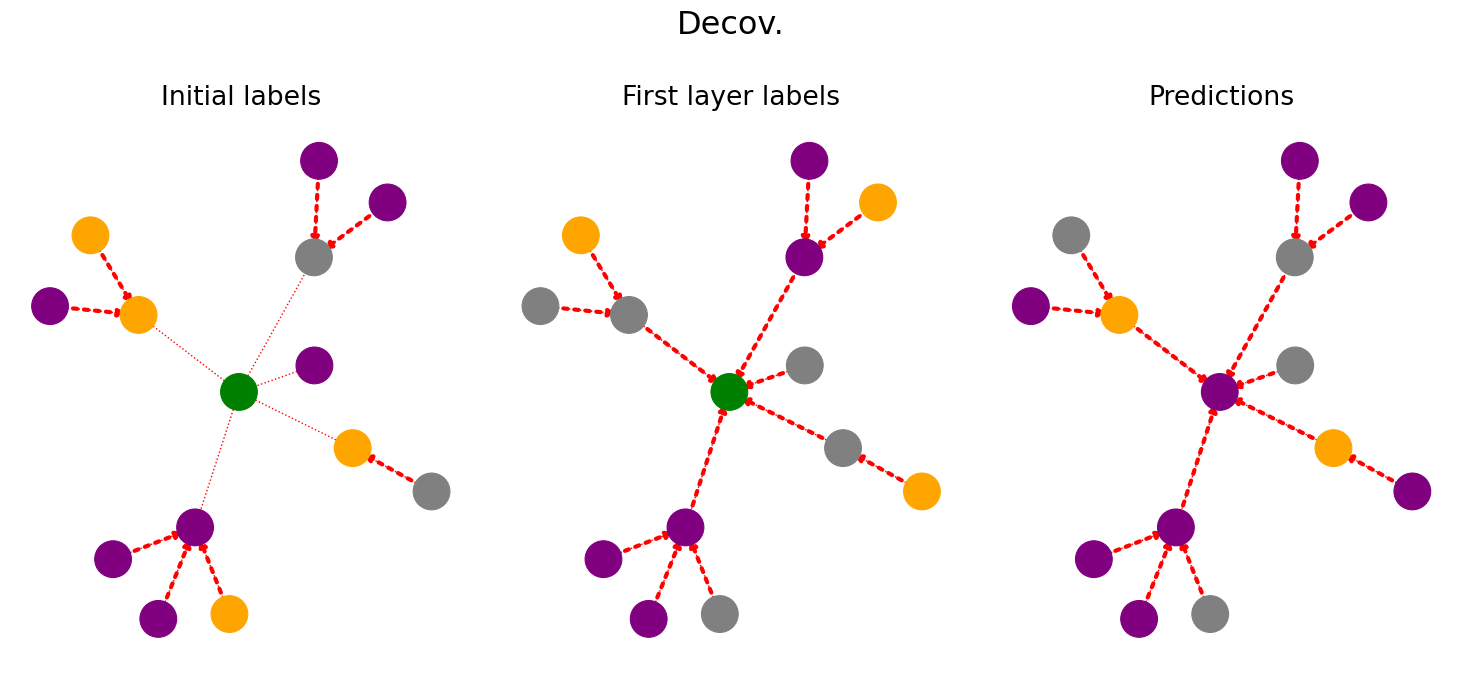

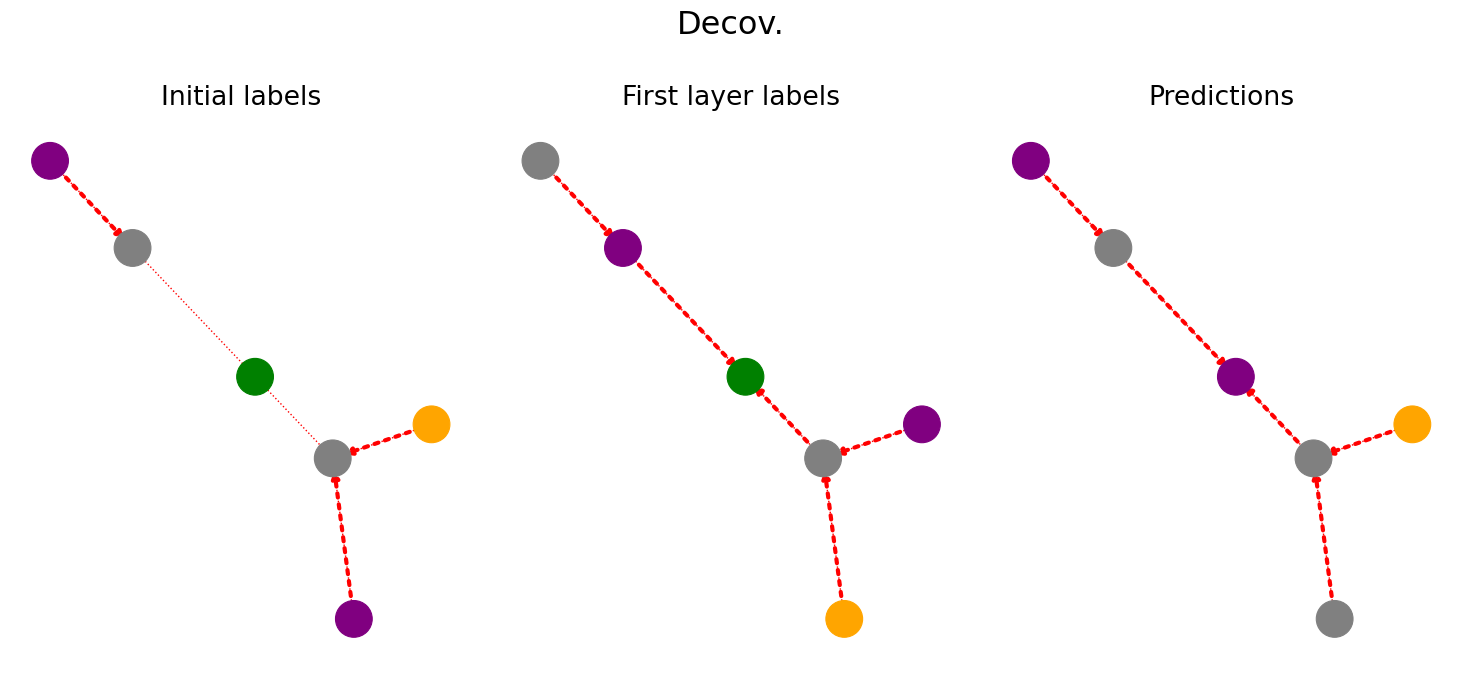

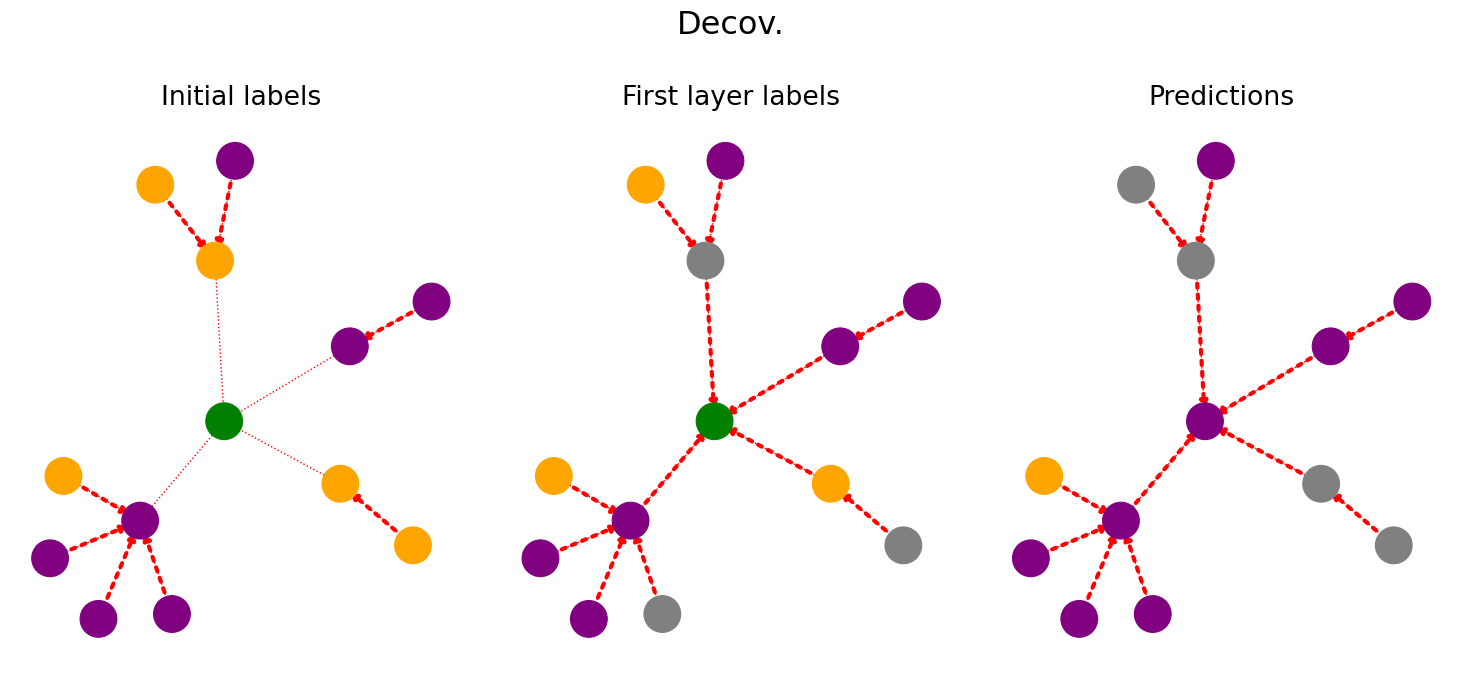

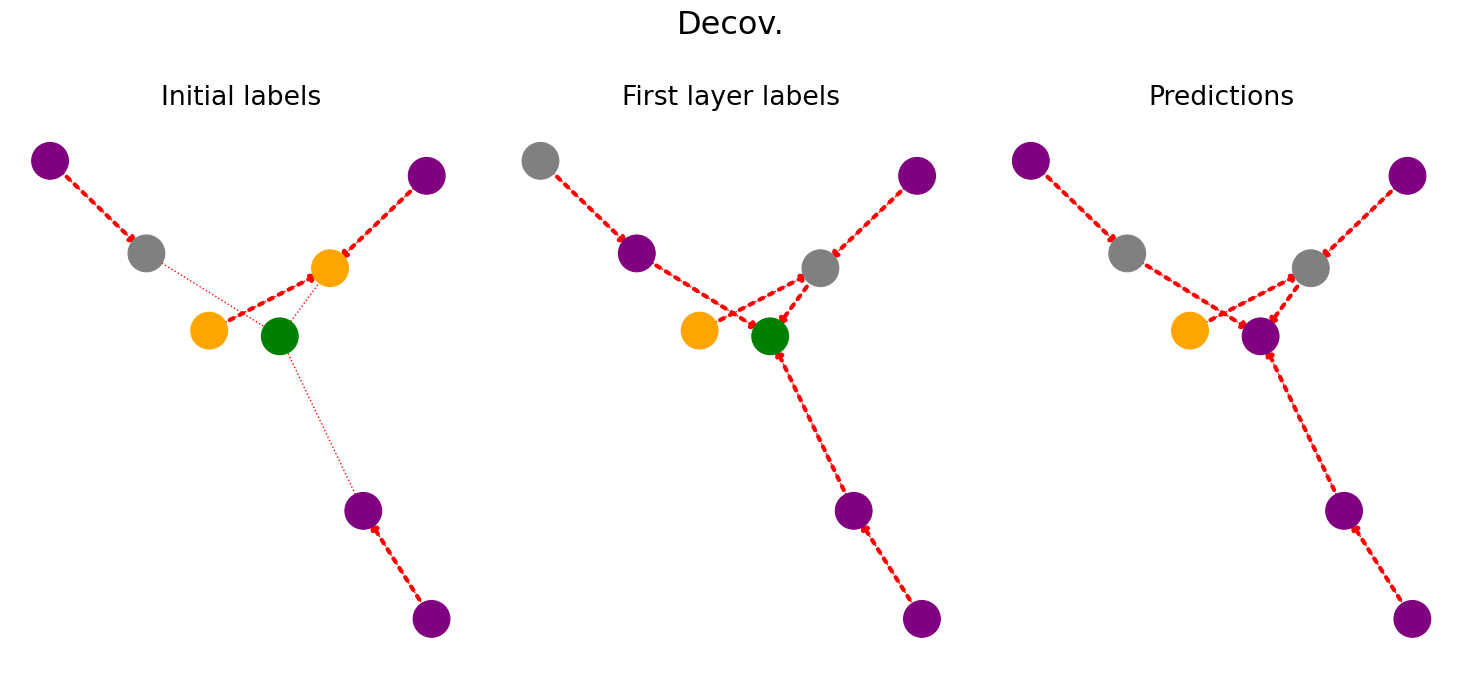

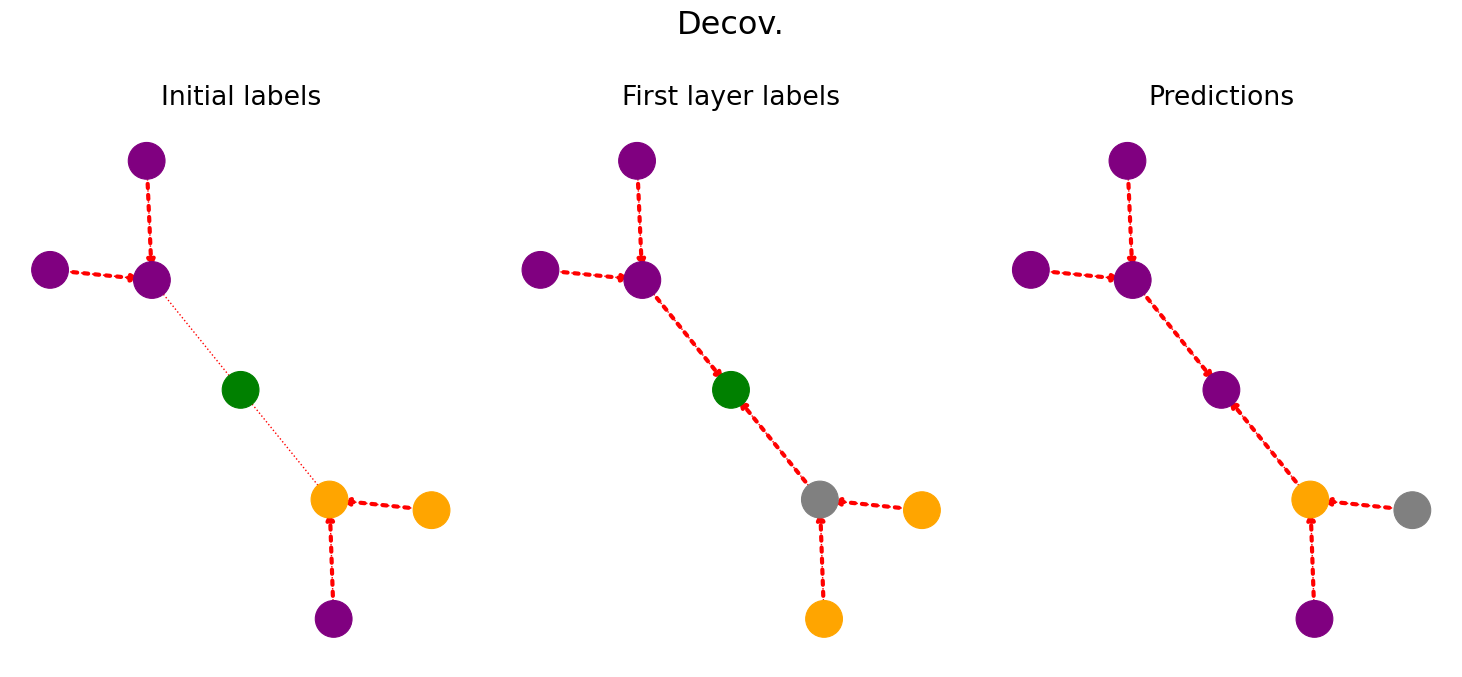

GNNExplainer__epochs_10000


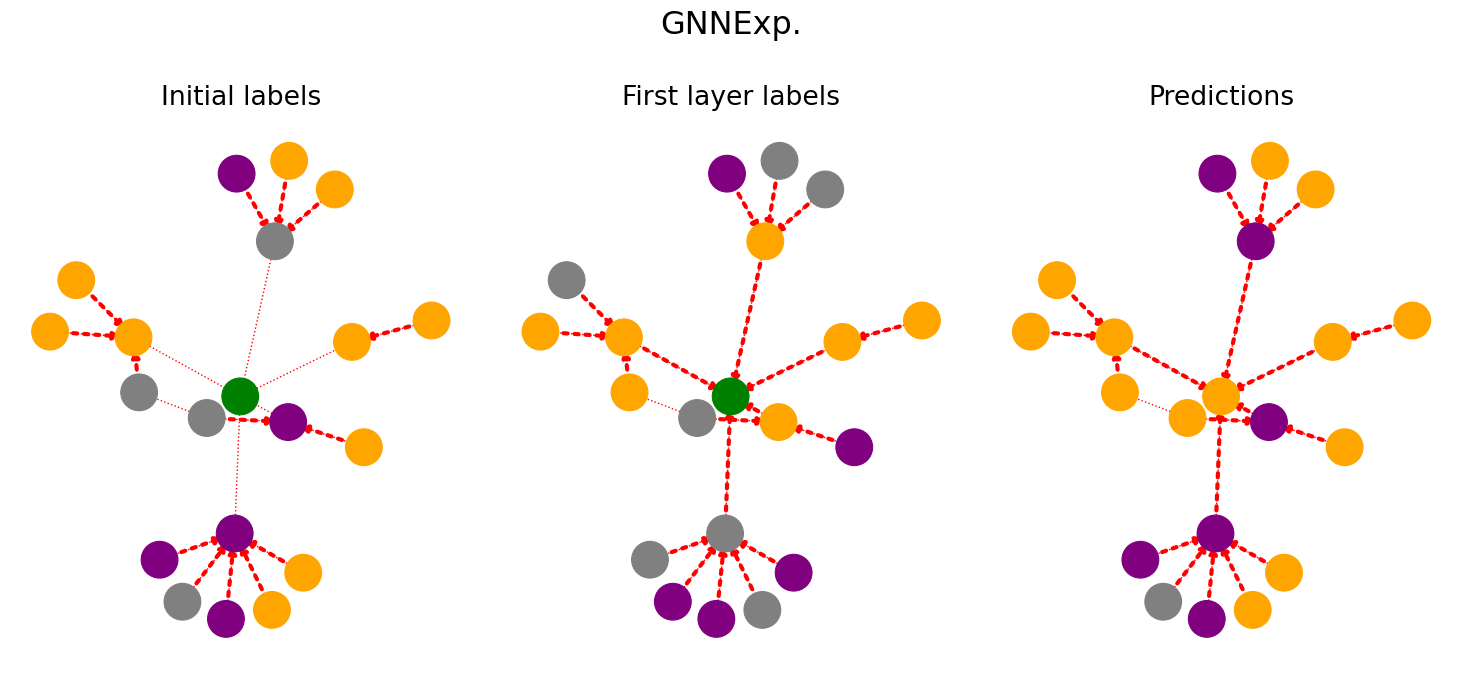

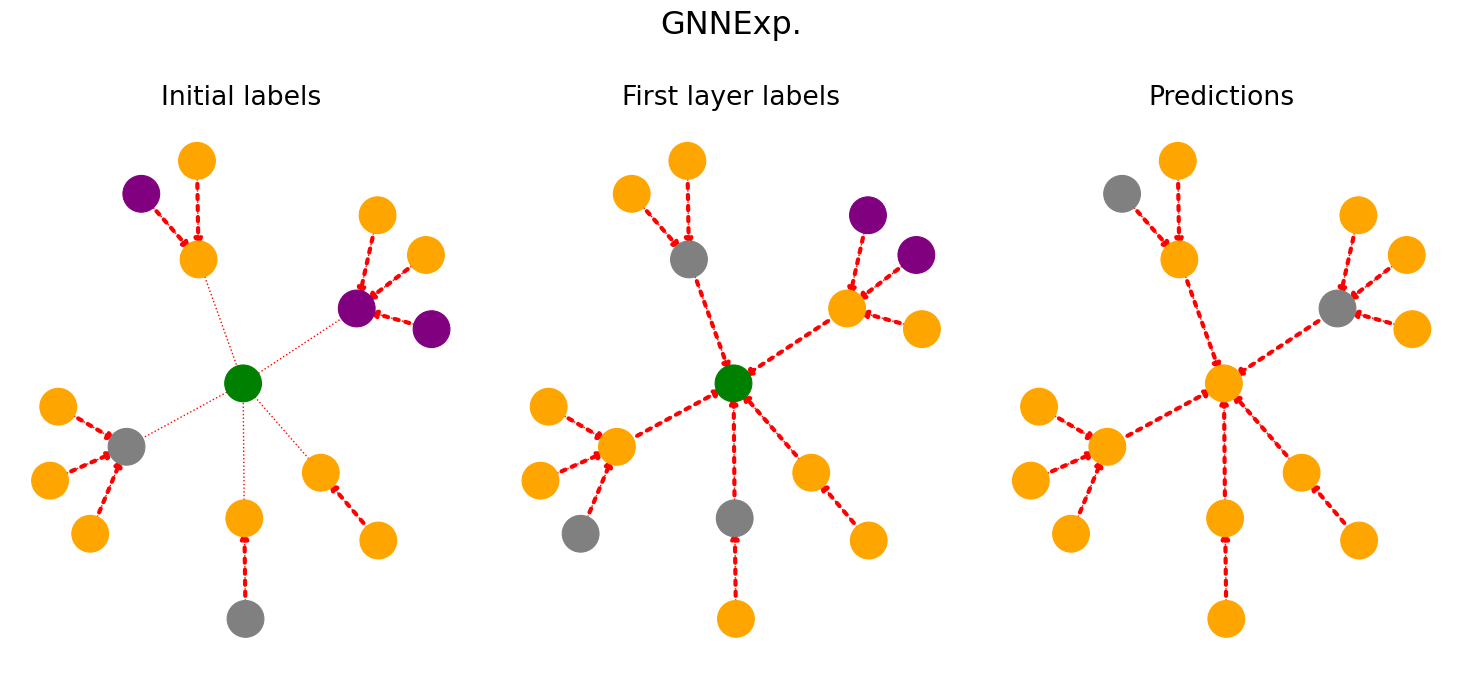

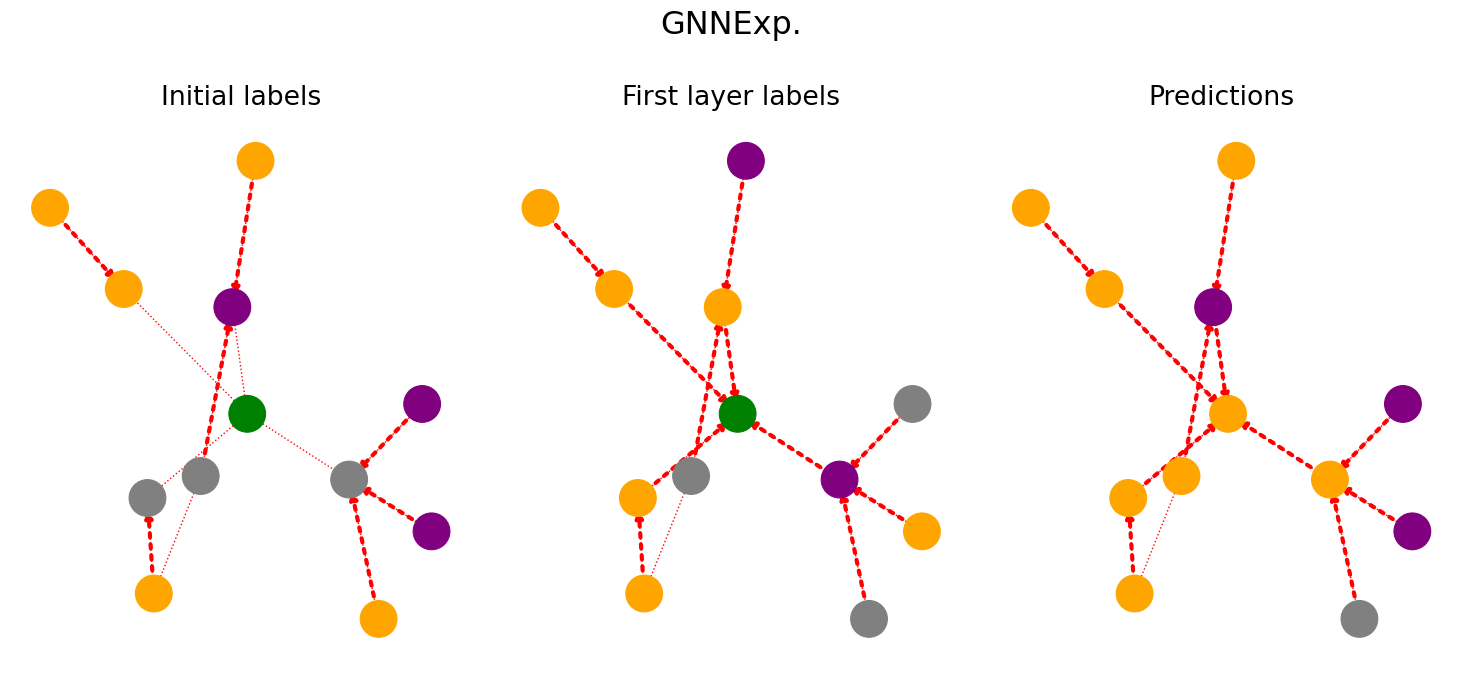

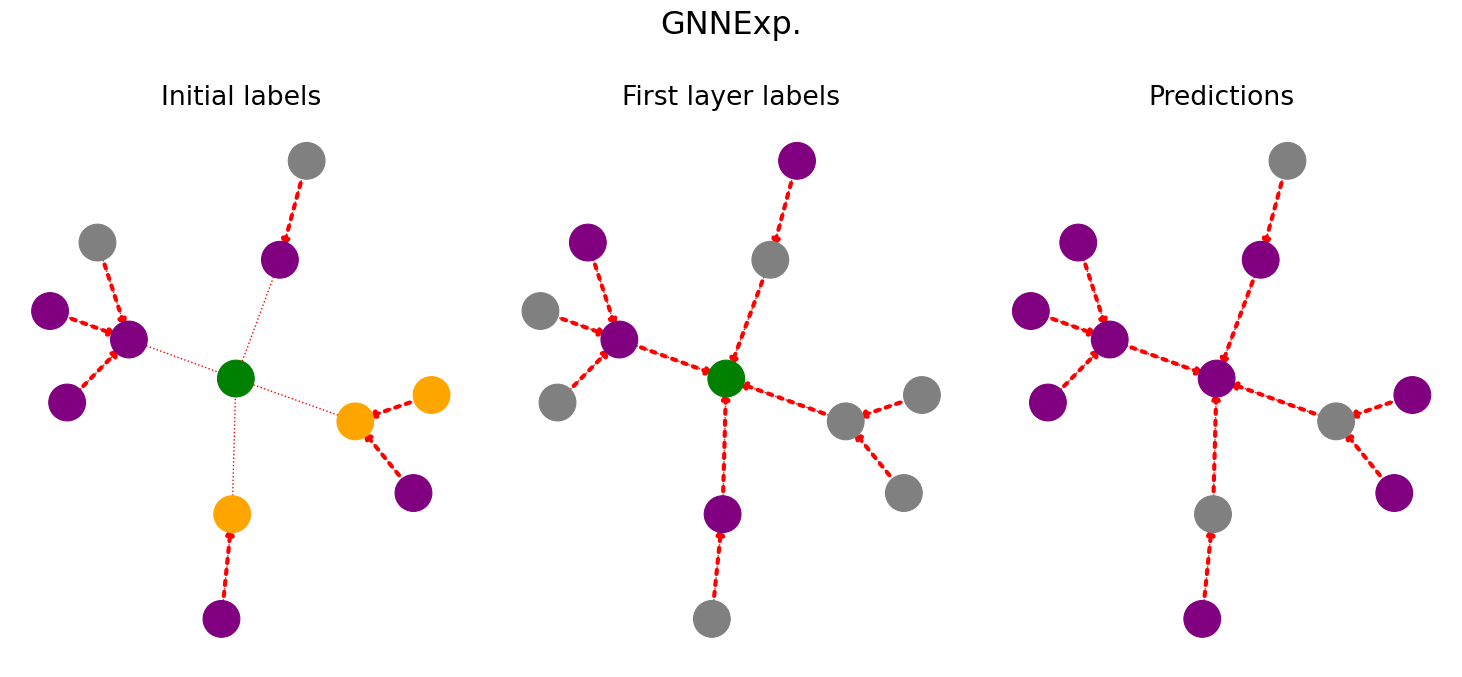

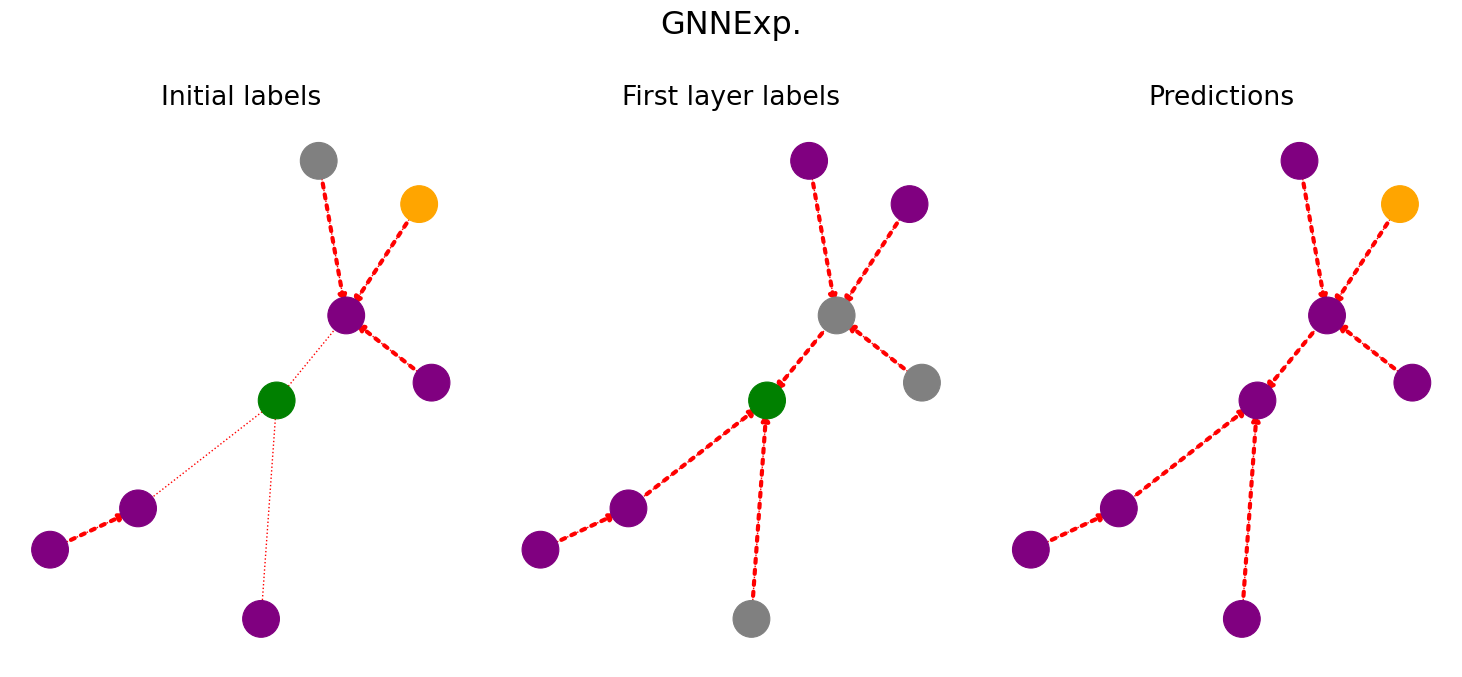

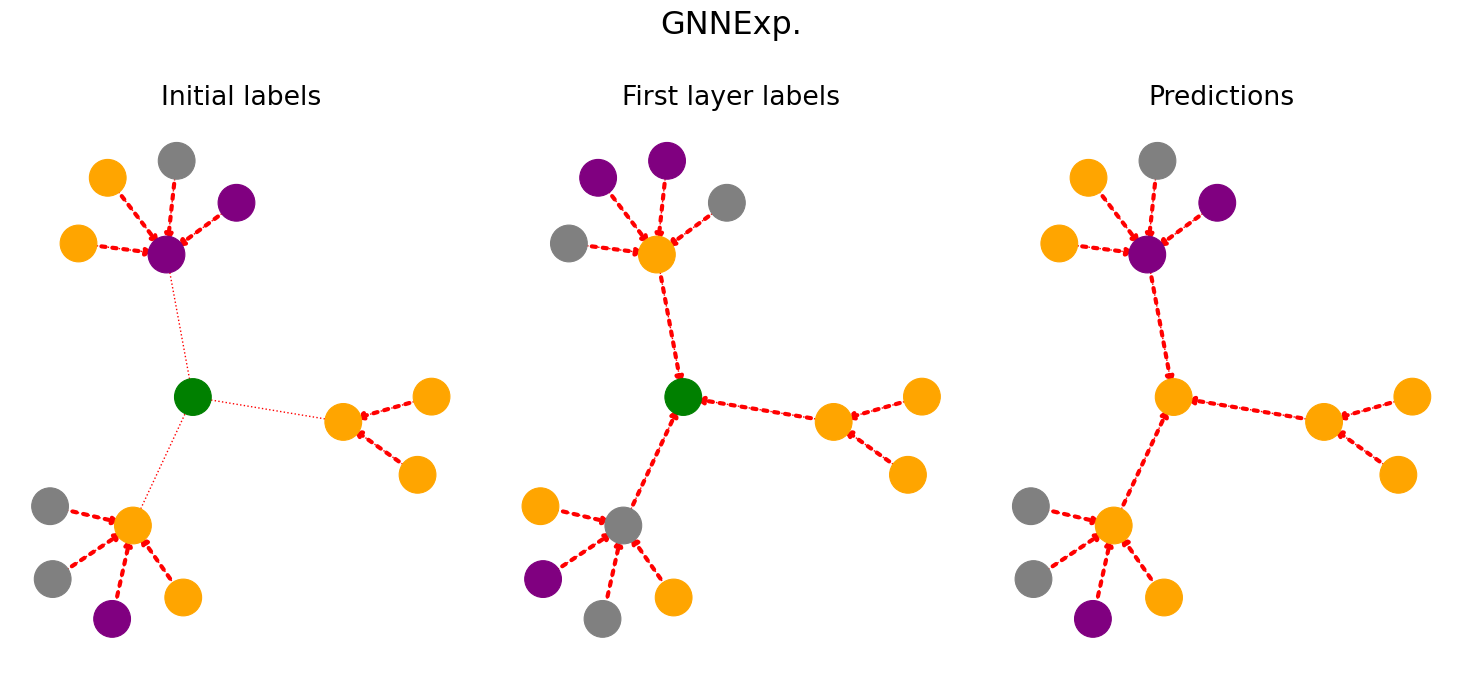

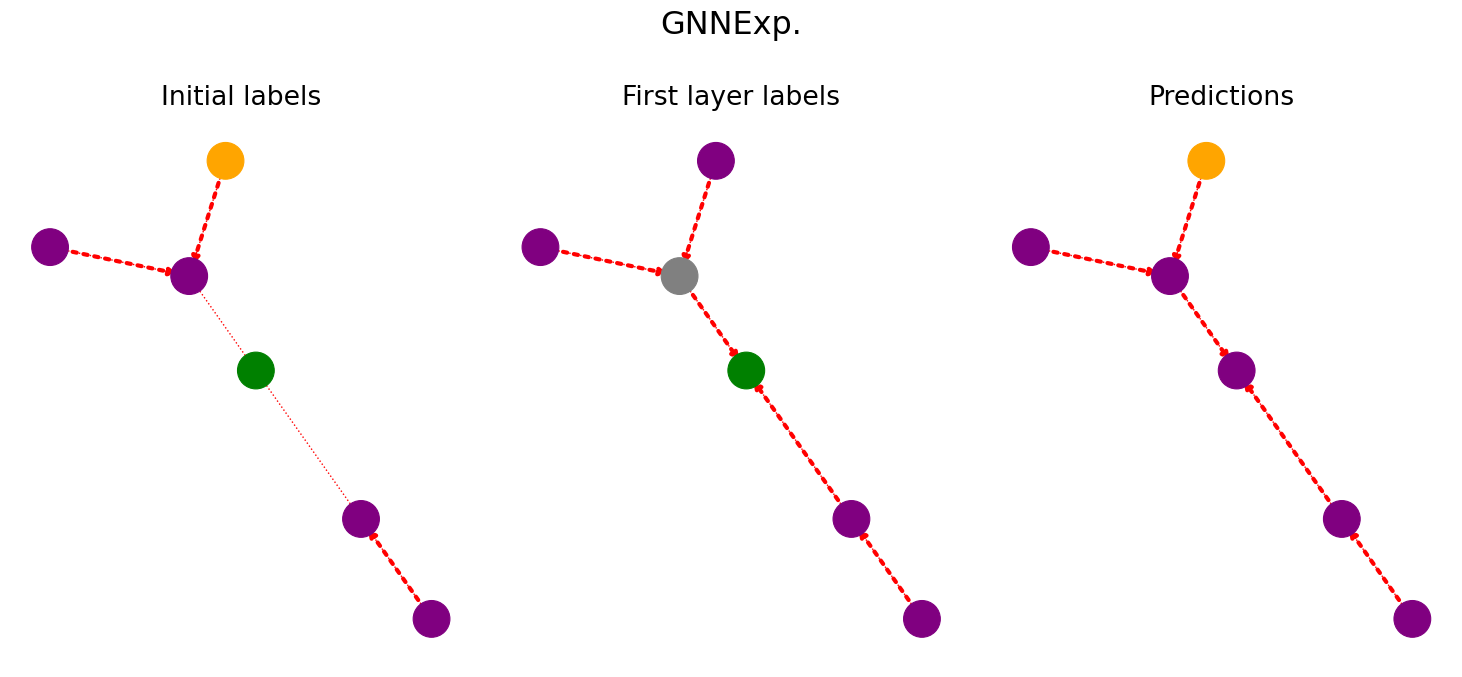

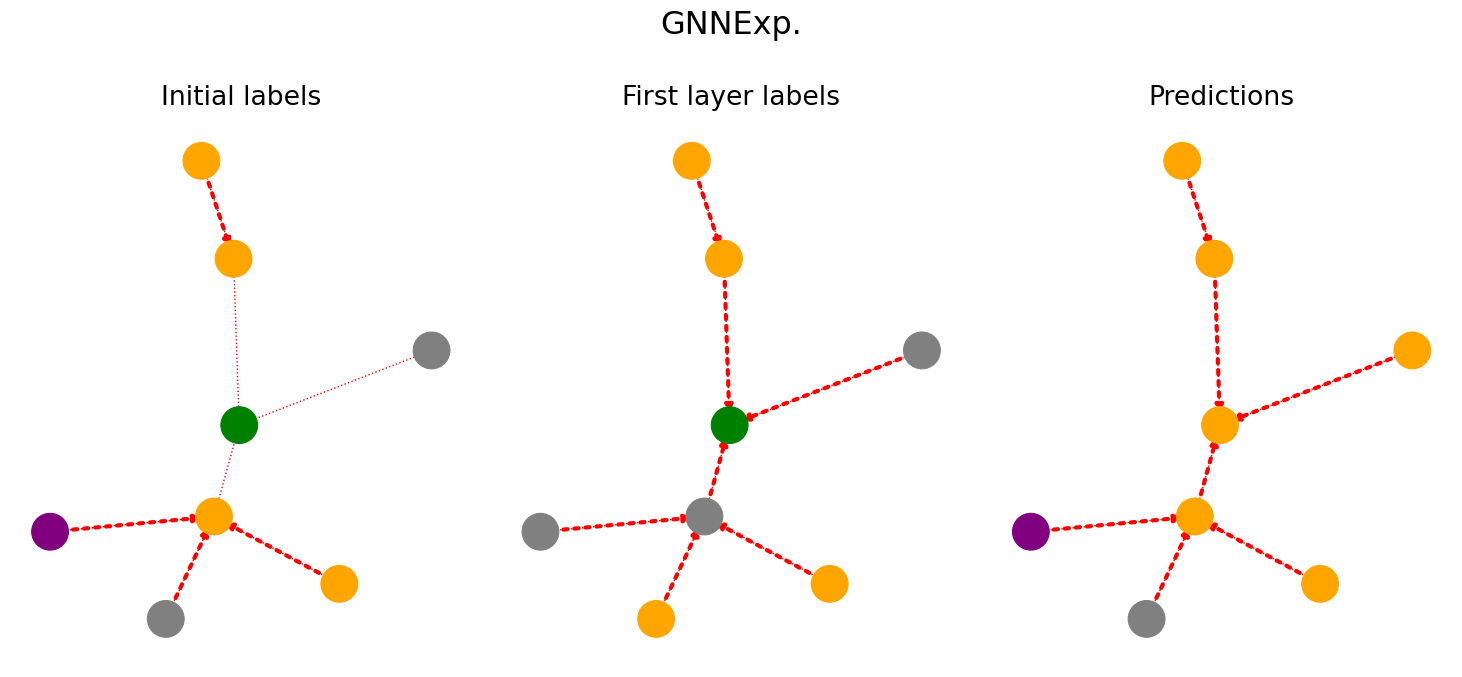

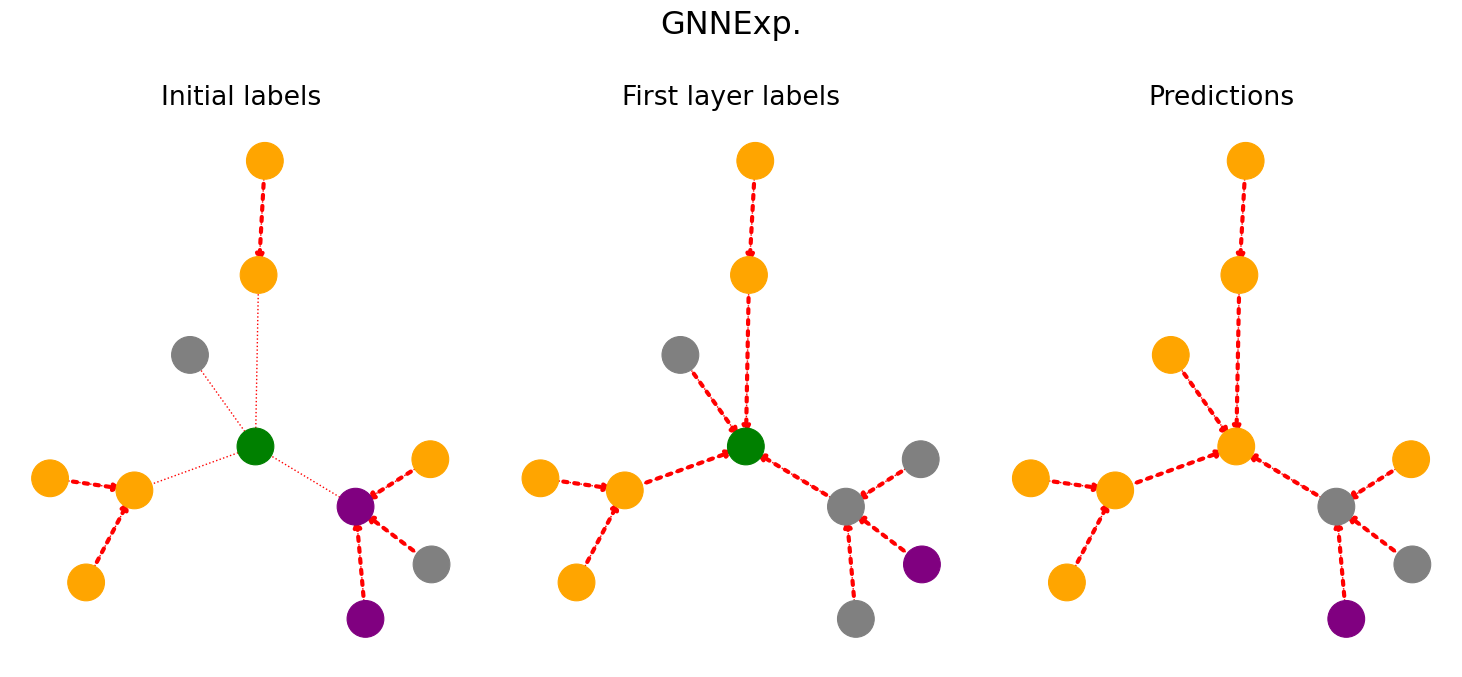

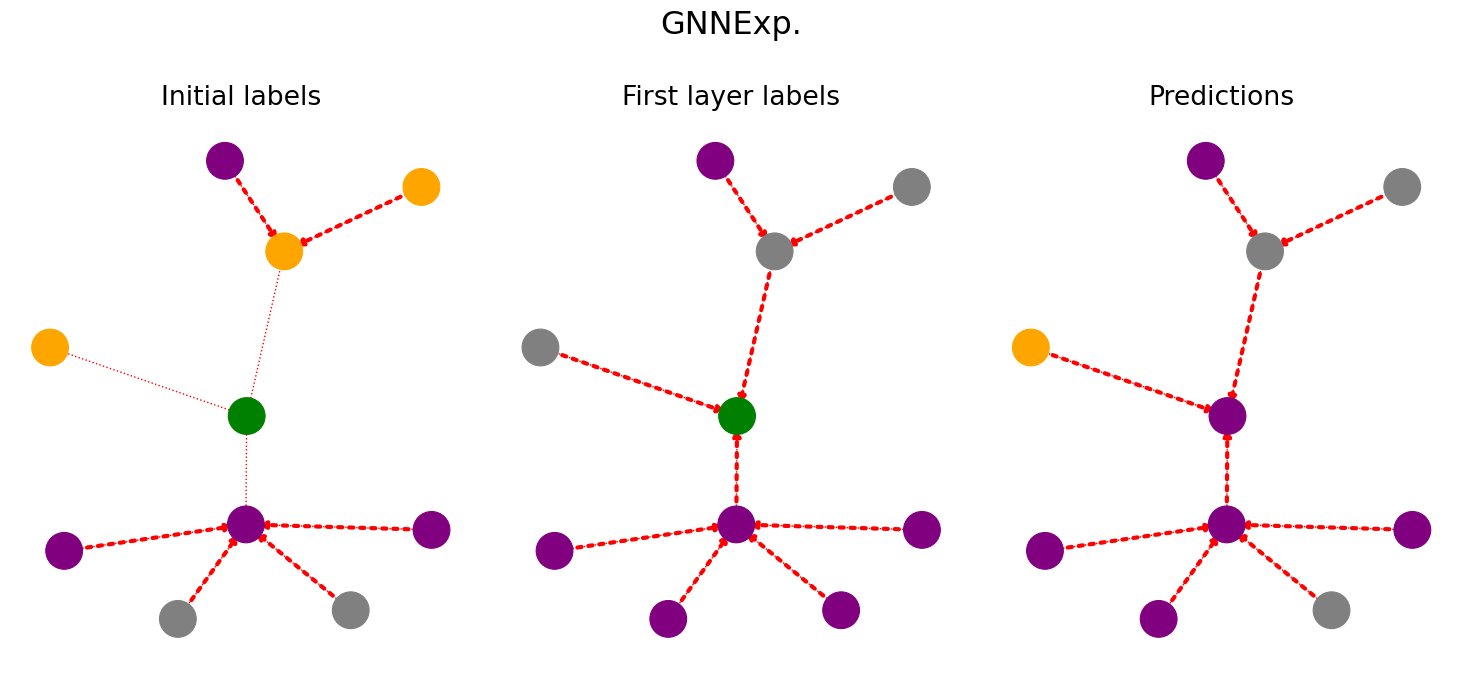

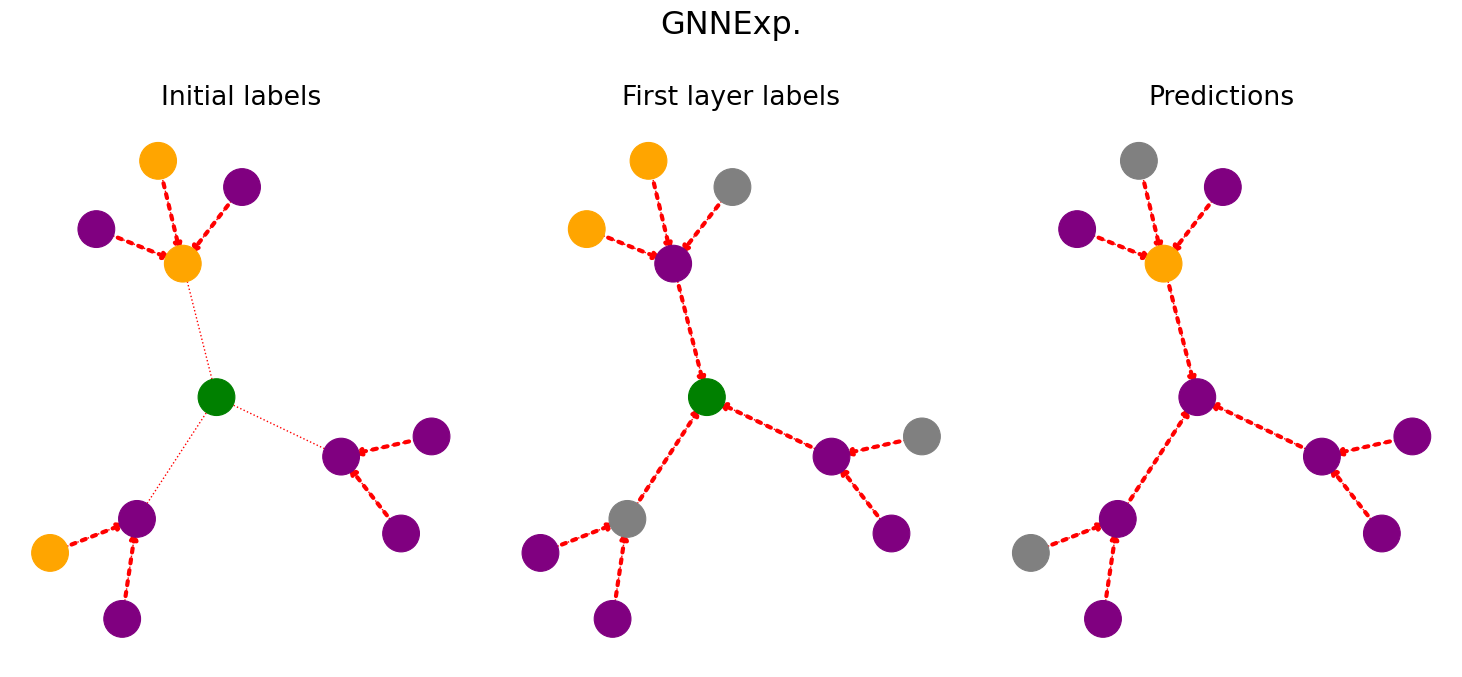

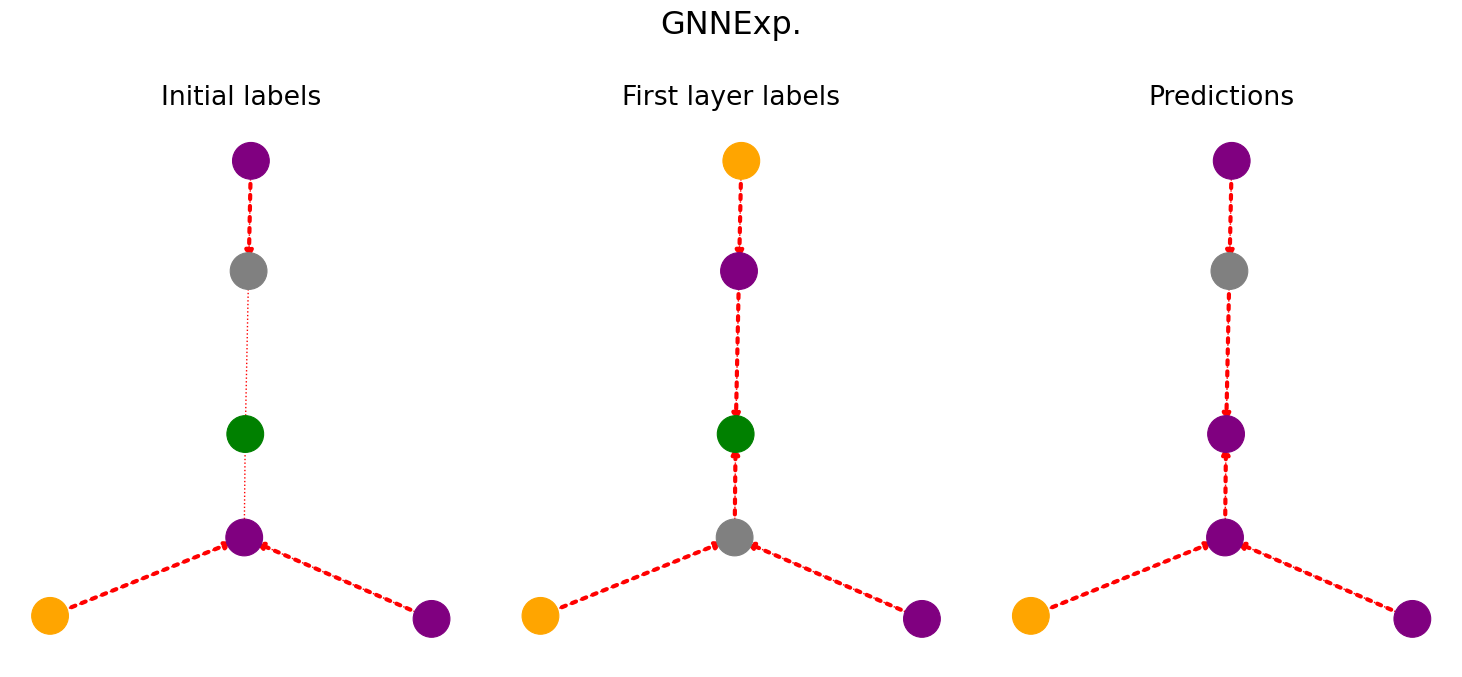

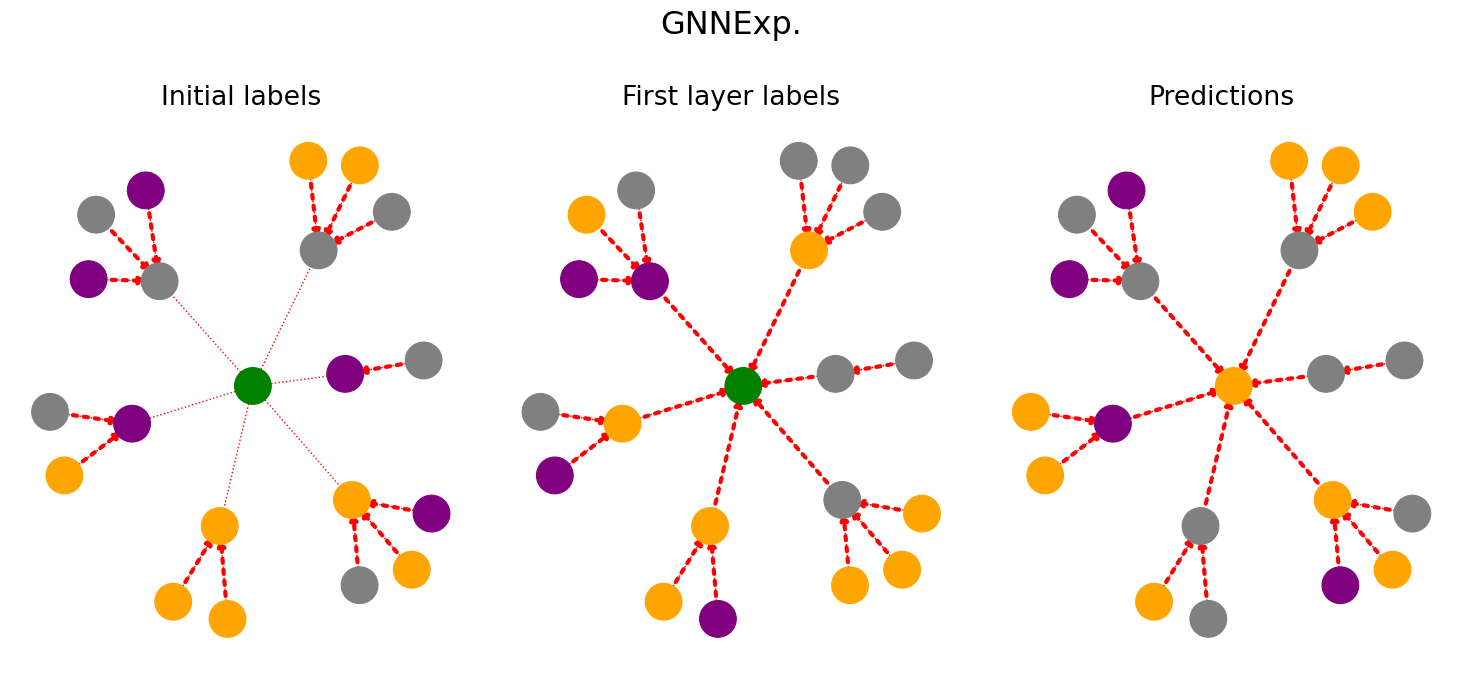

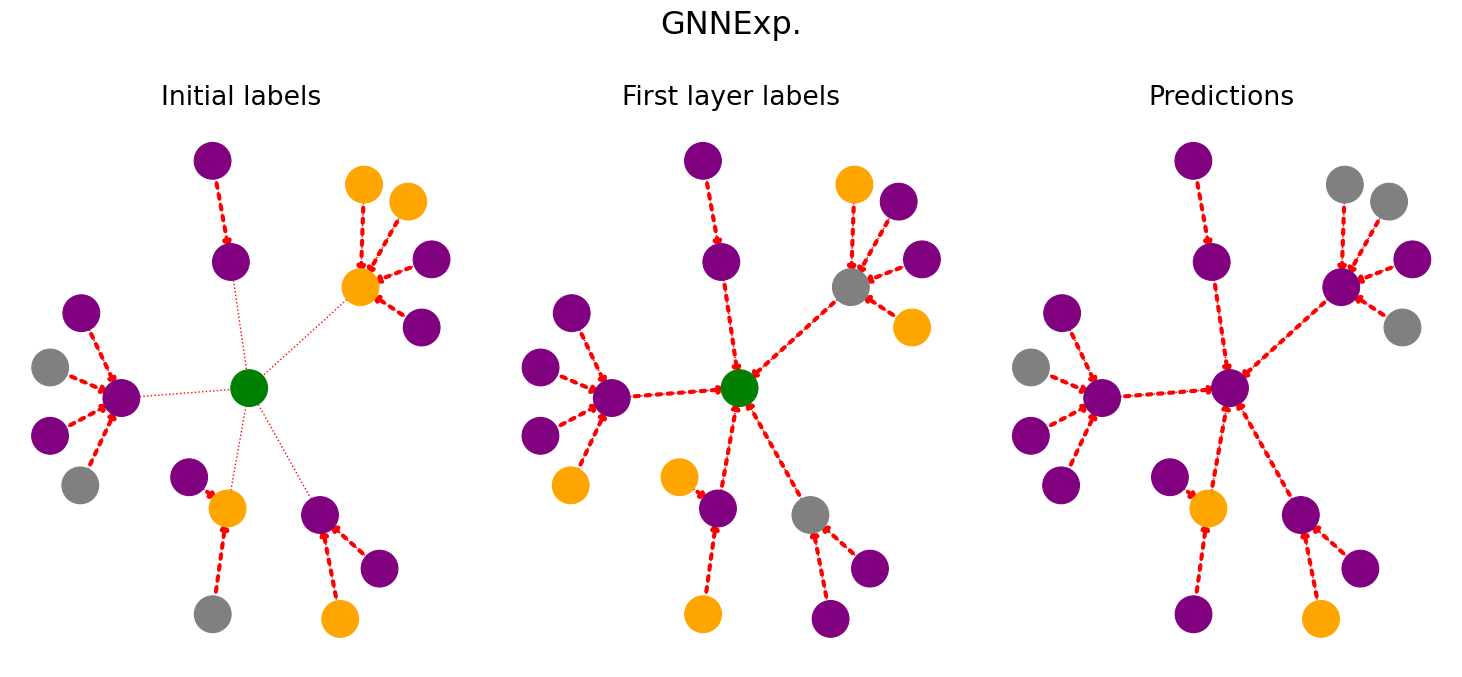

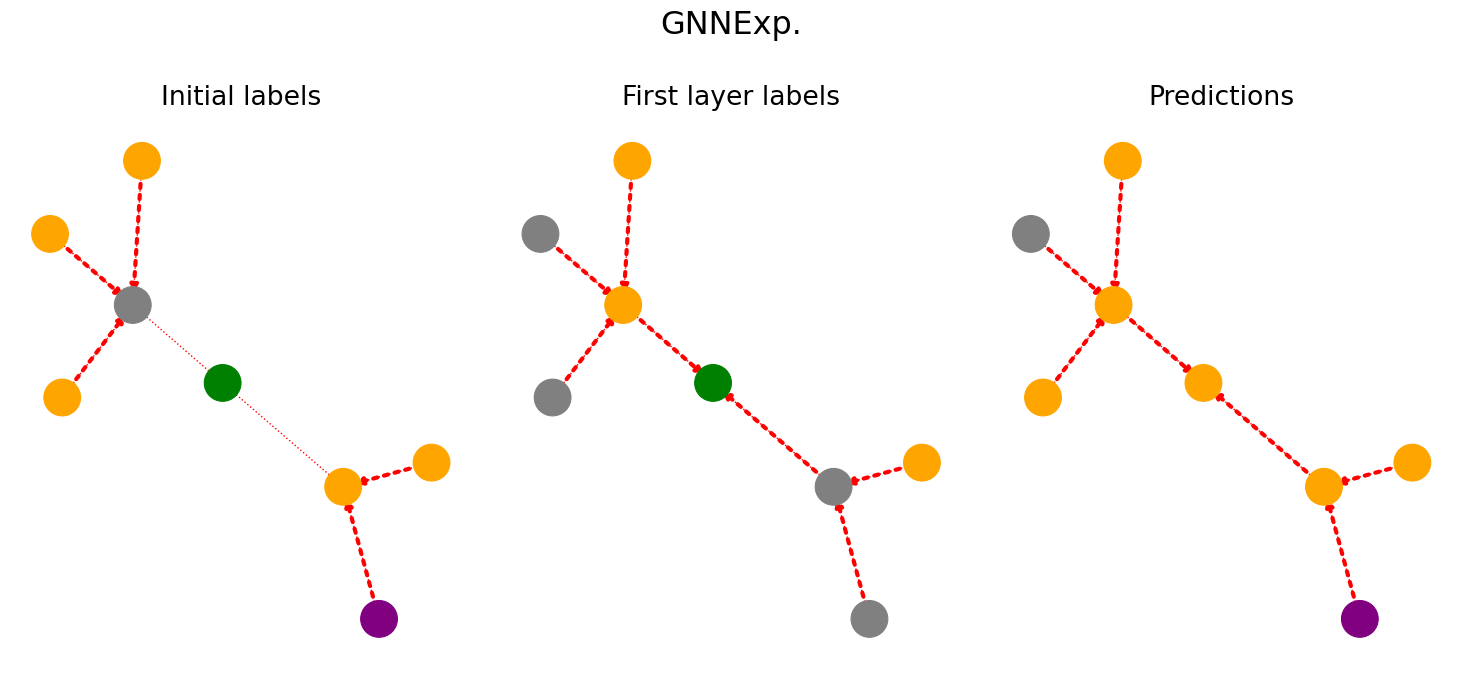

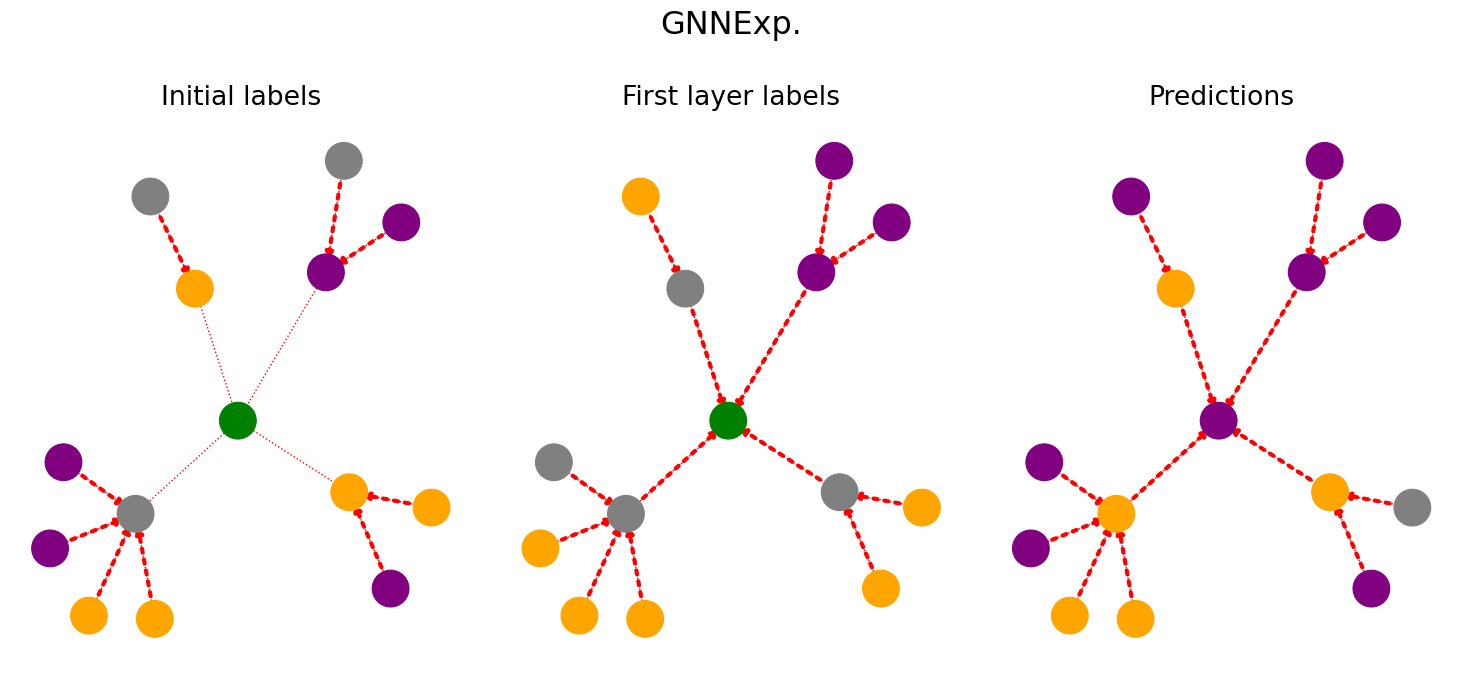

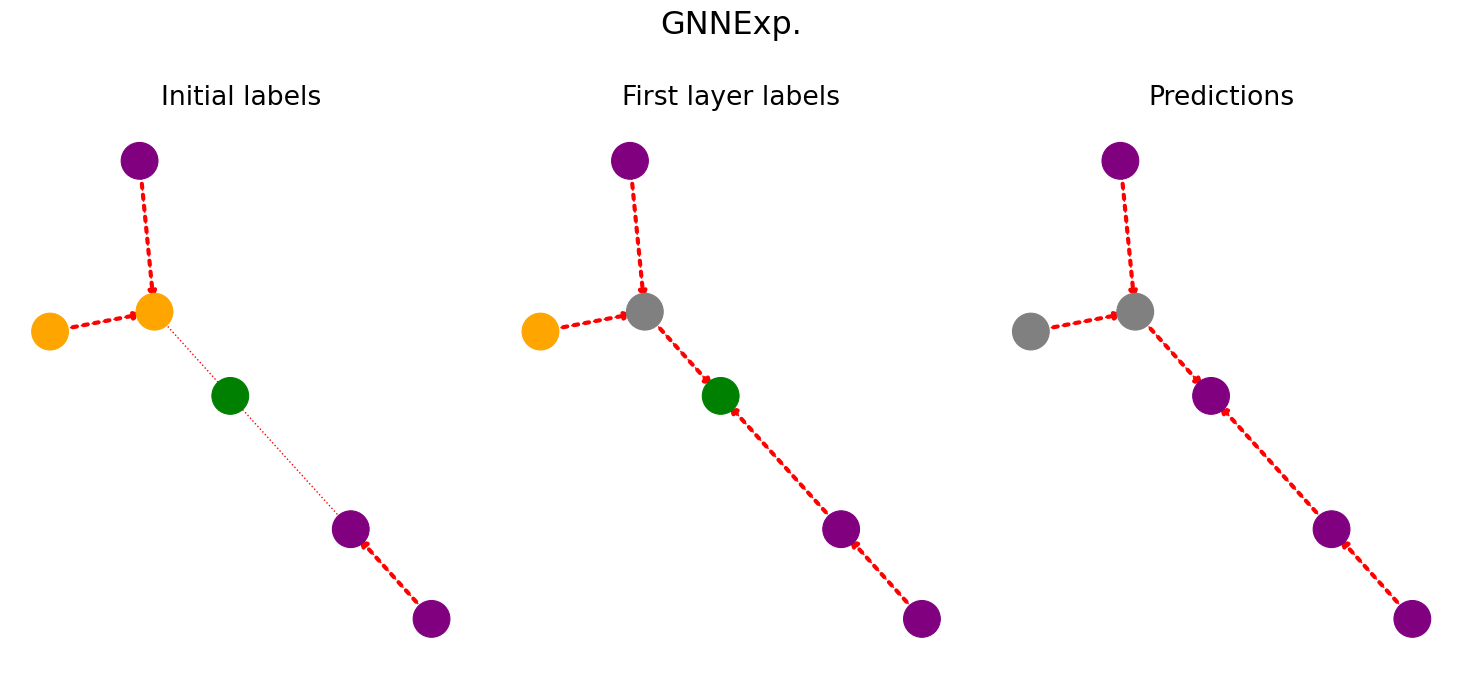

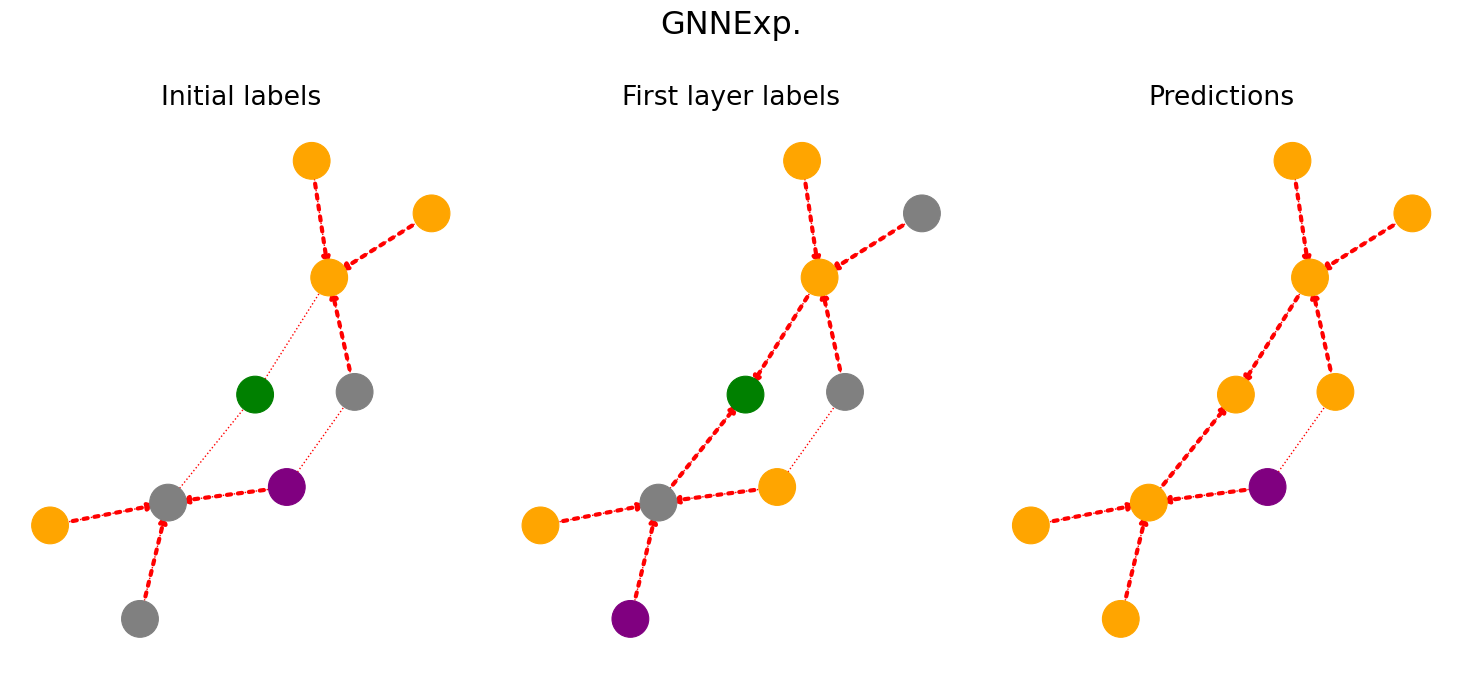

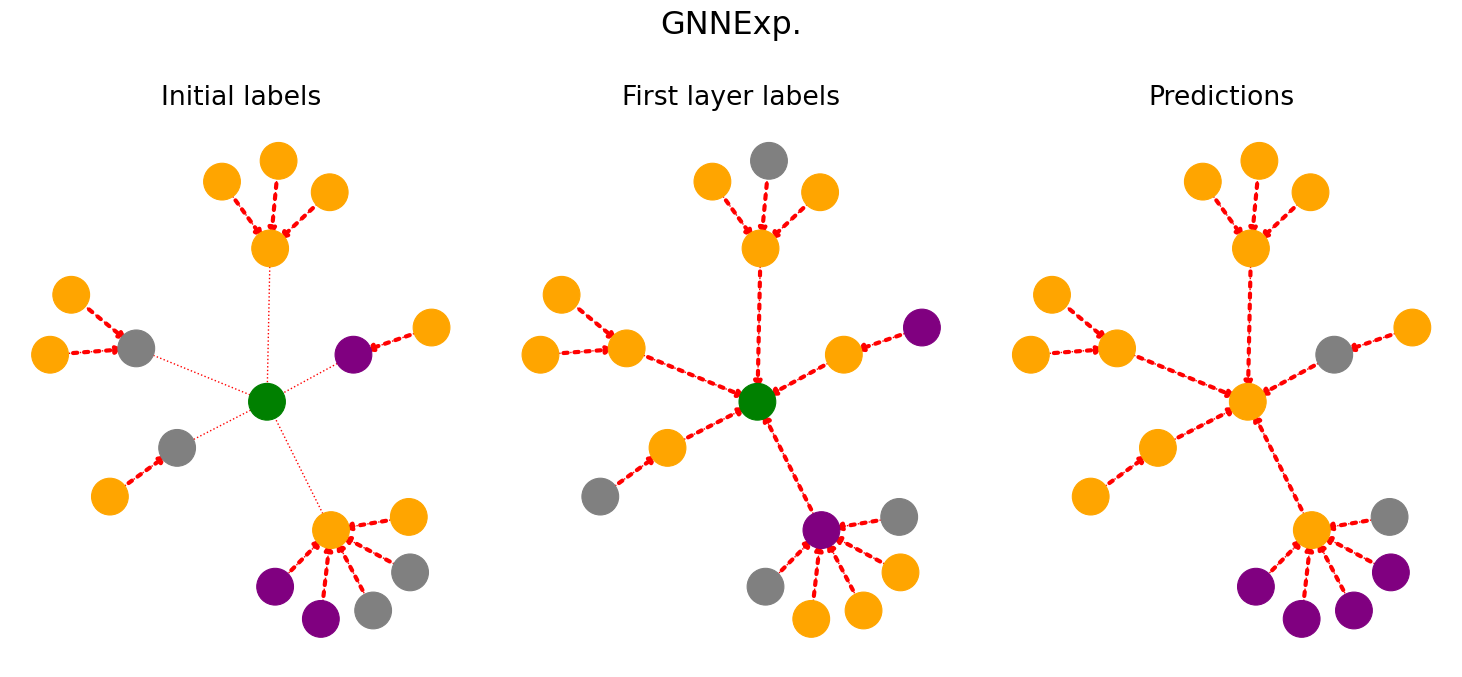

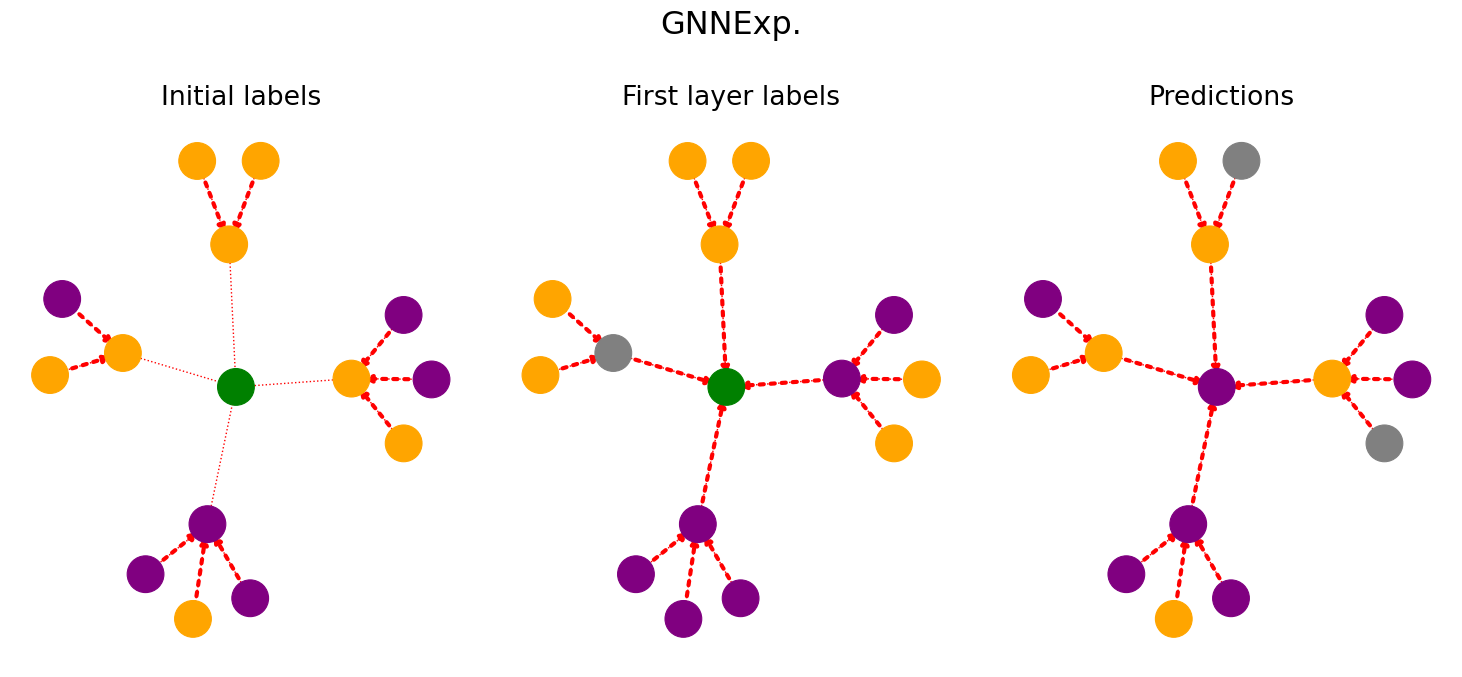

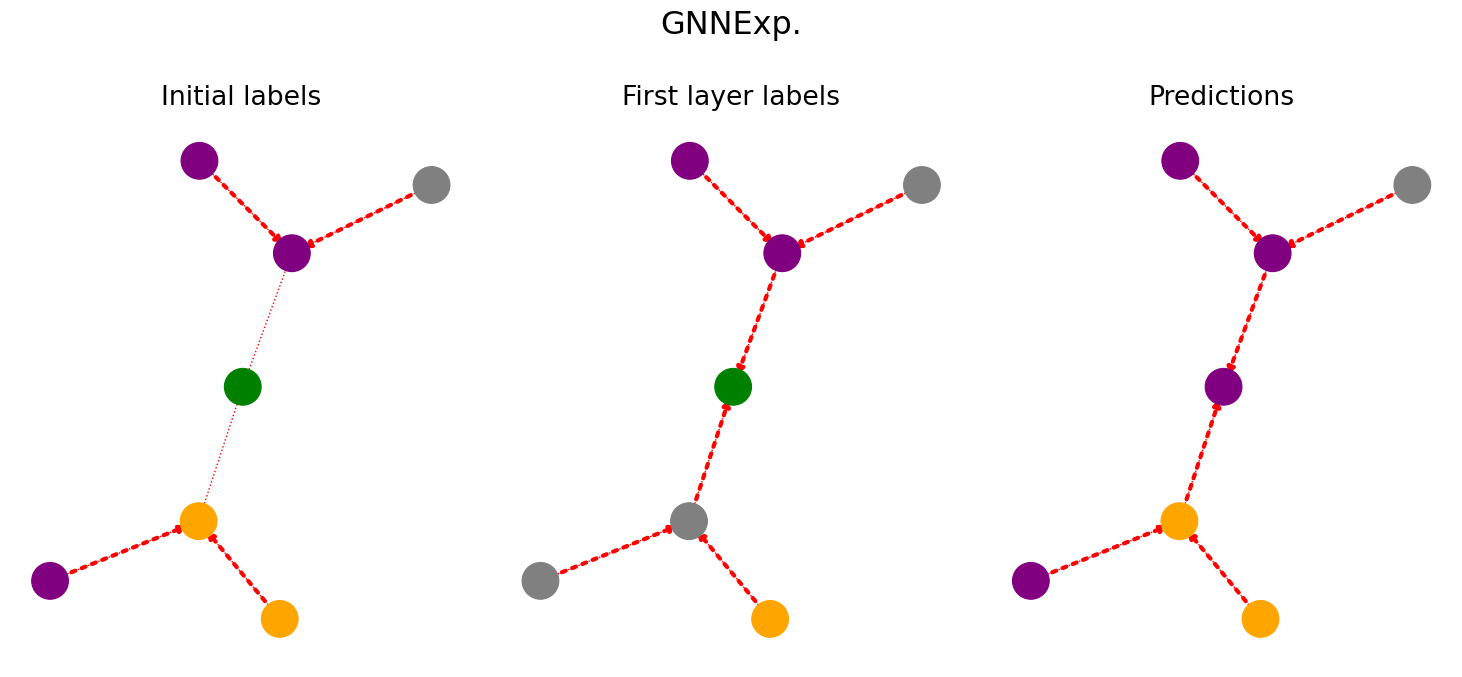

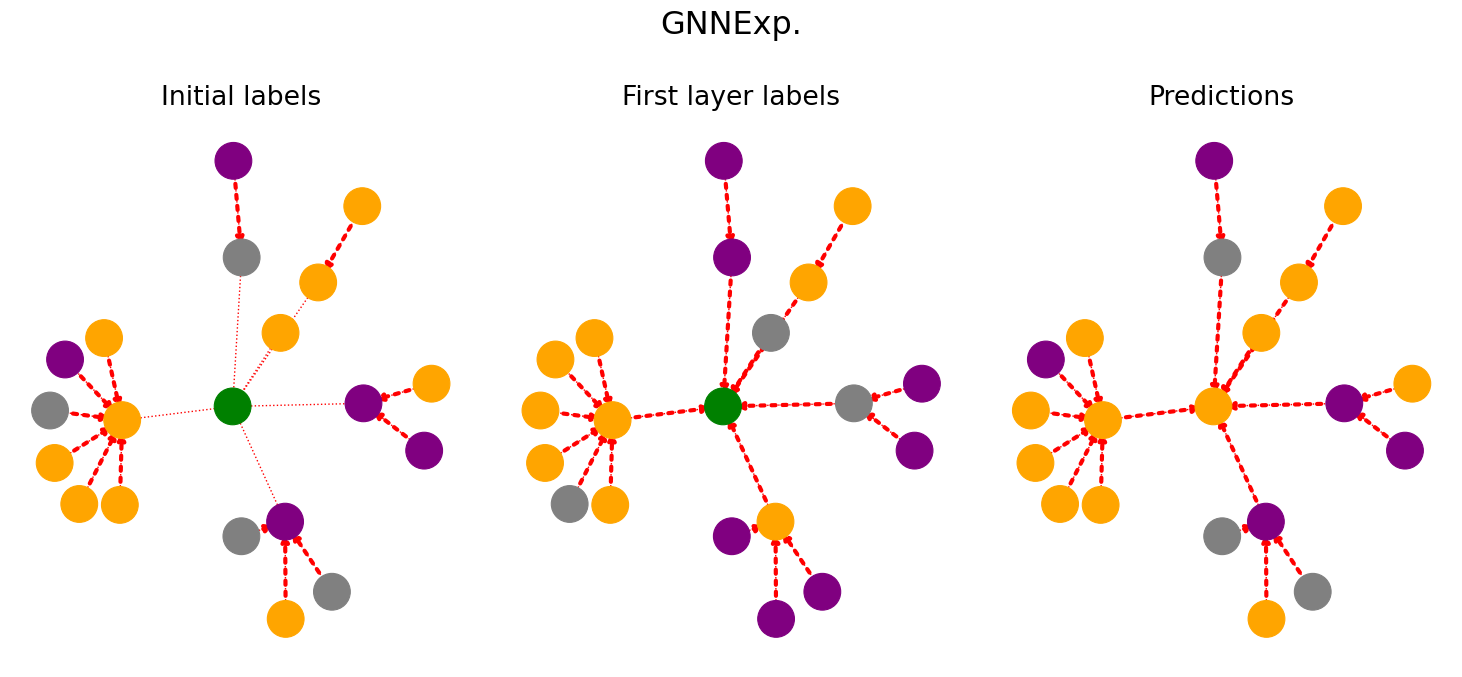

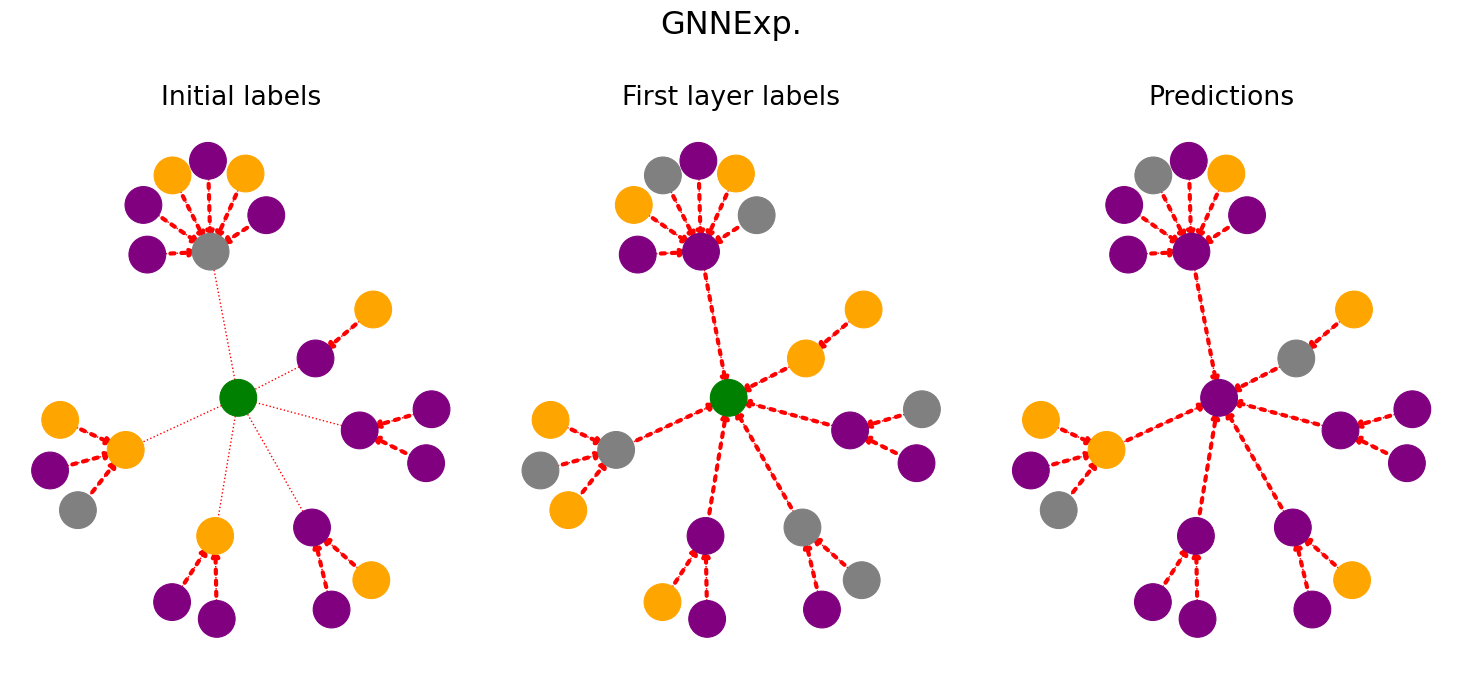

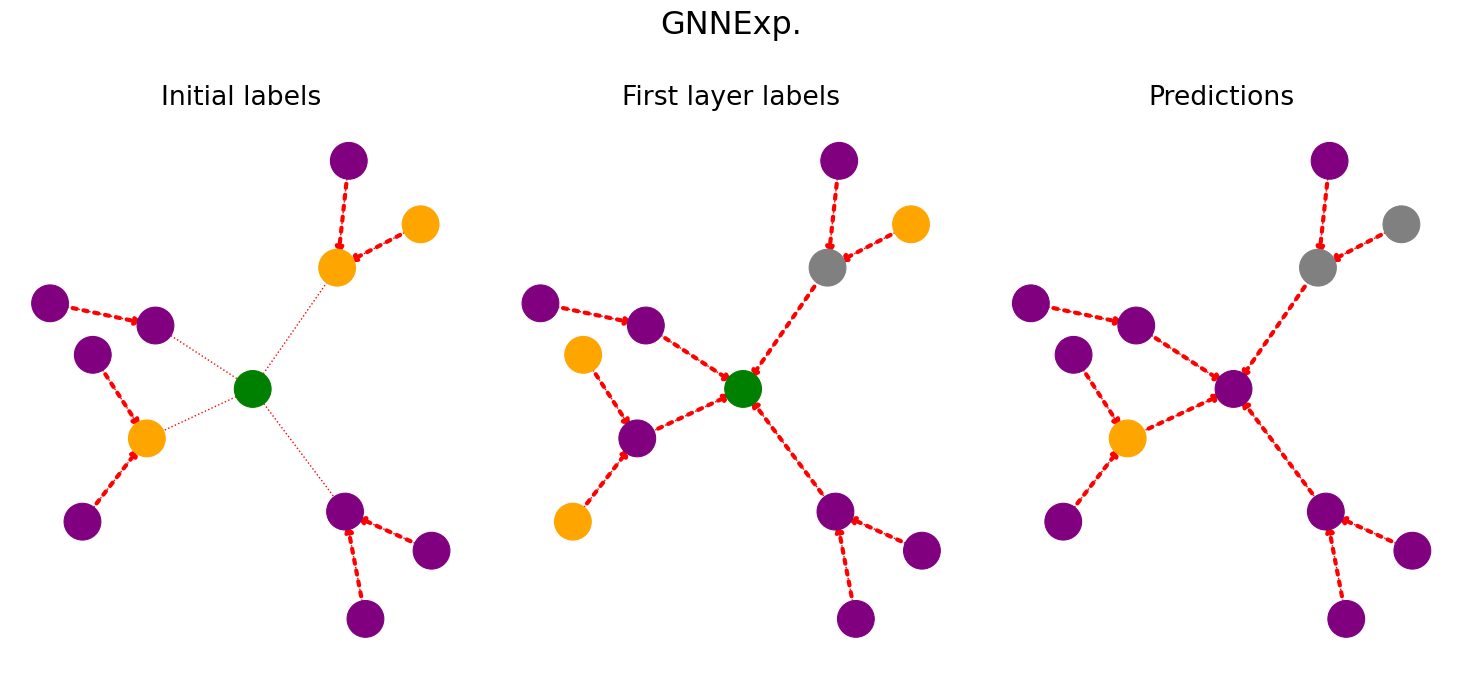

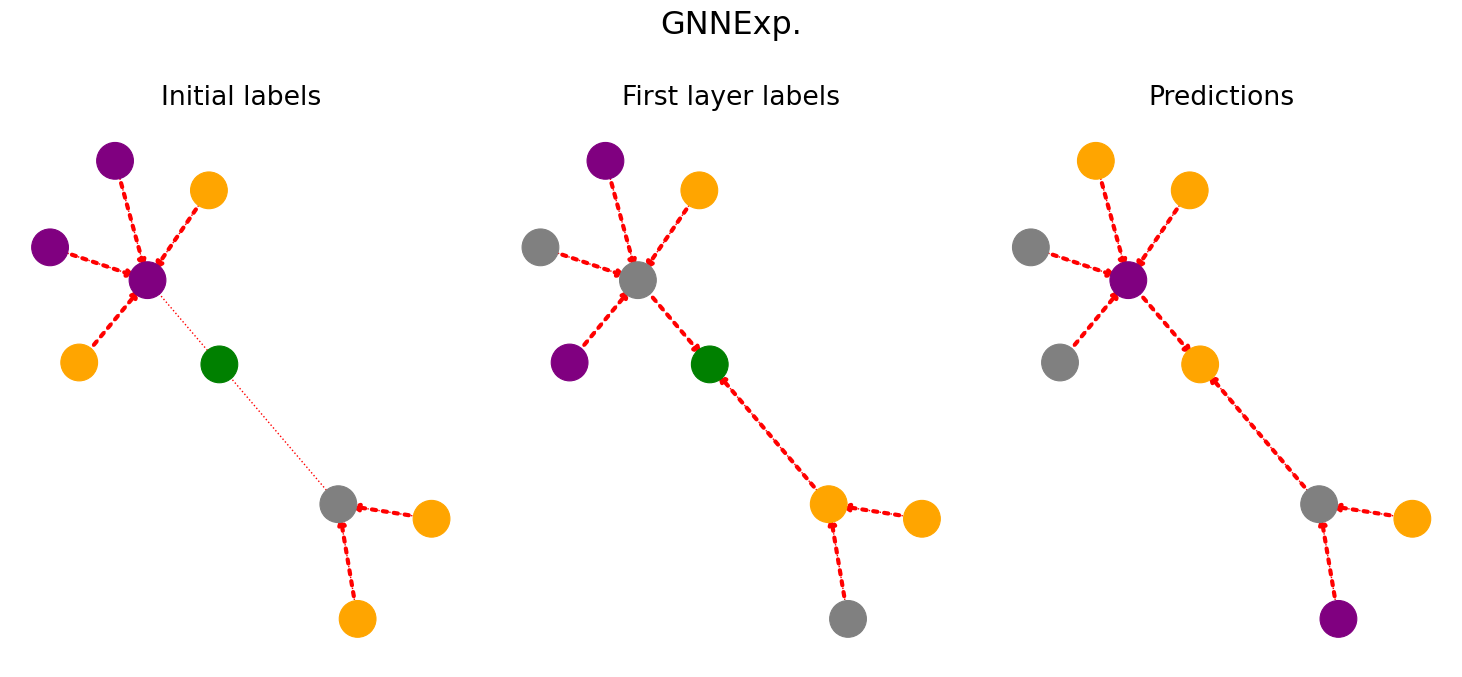

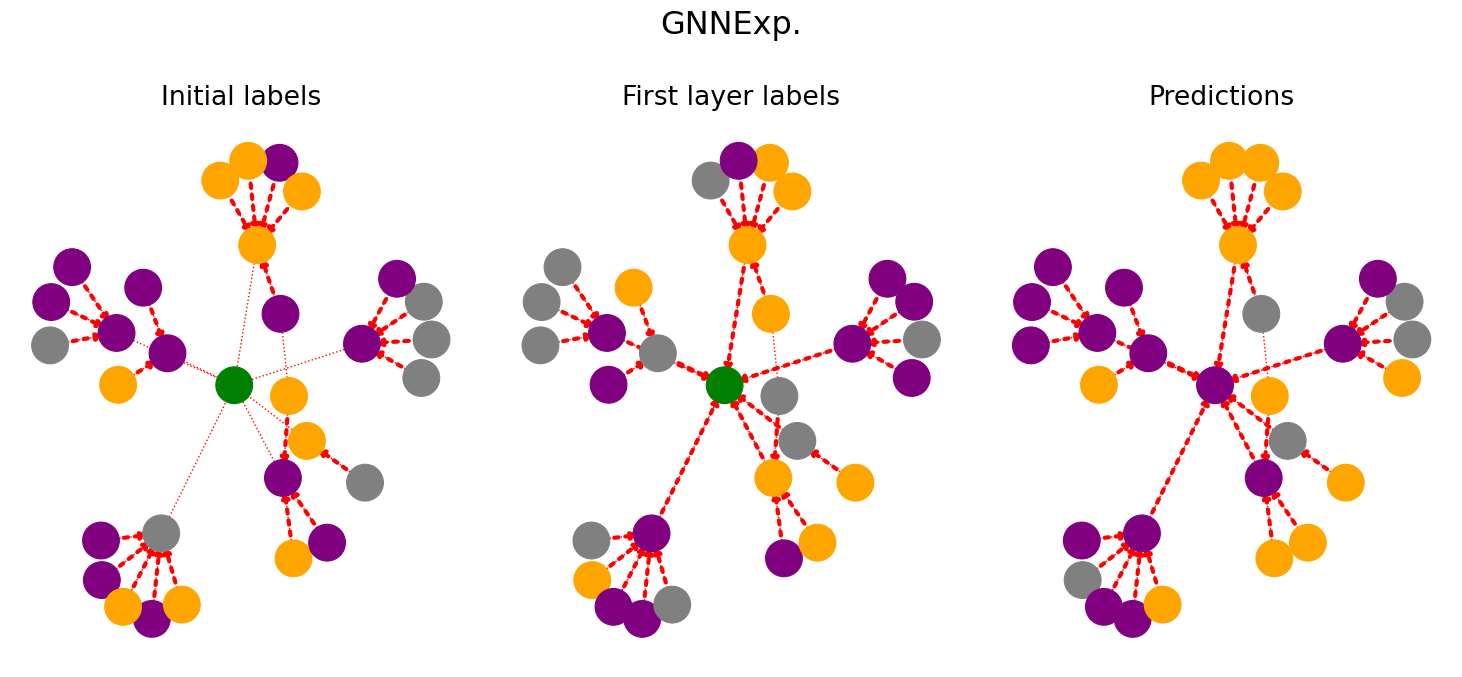

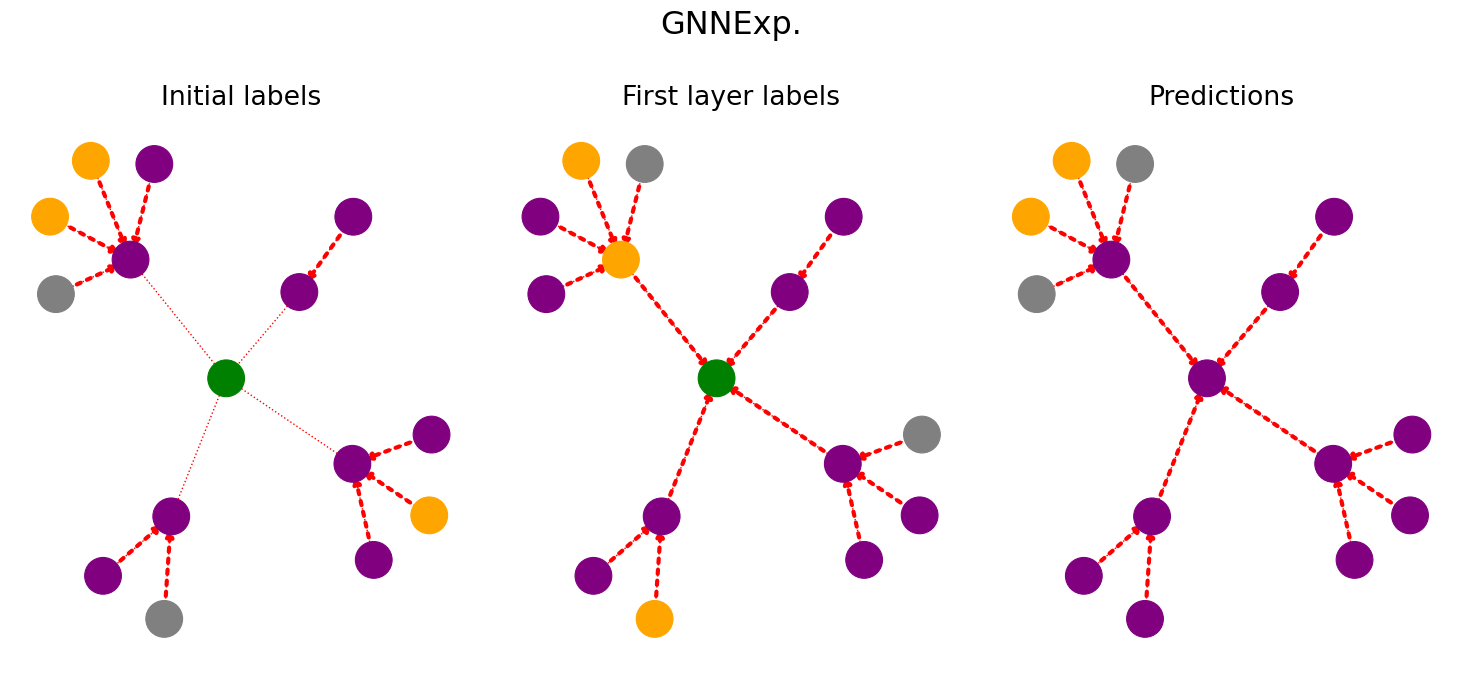

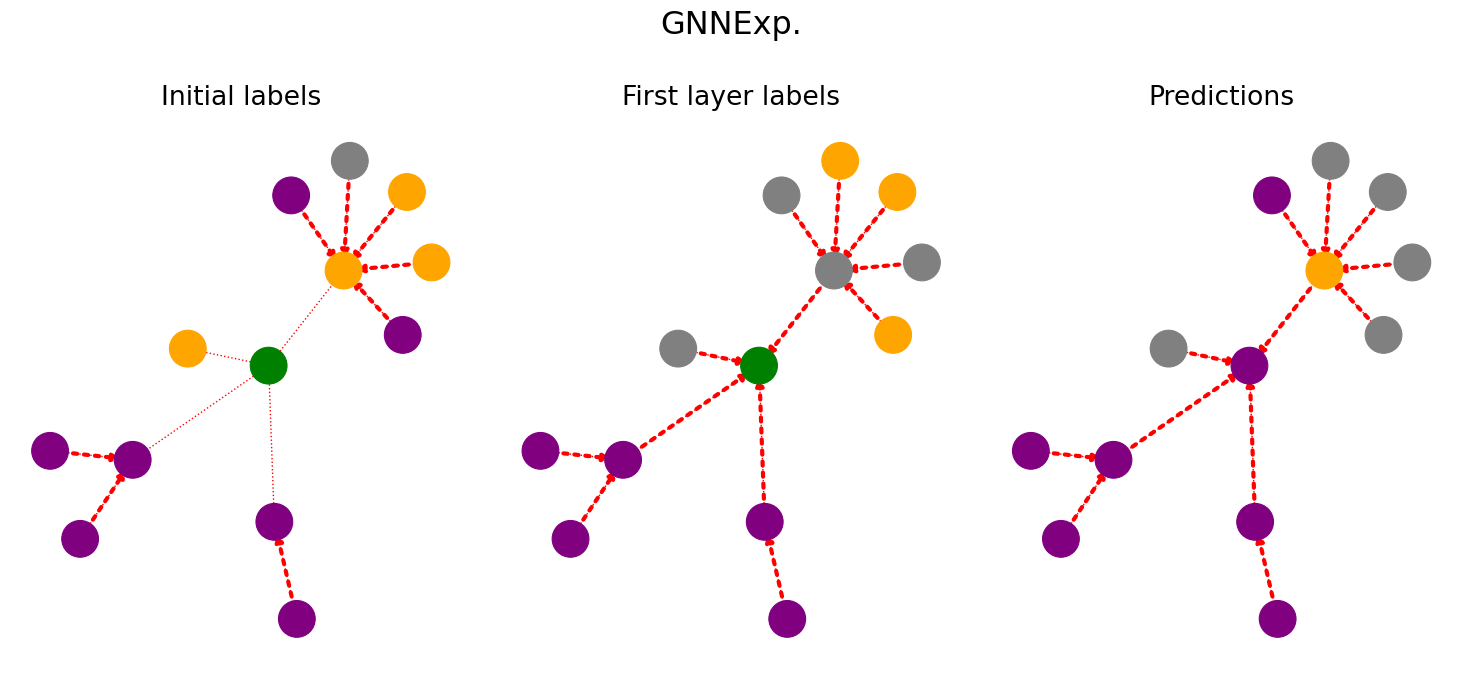

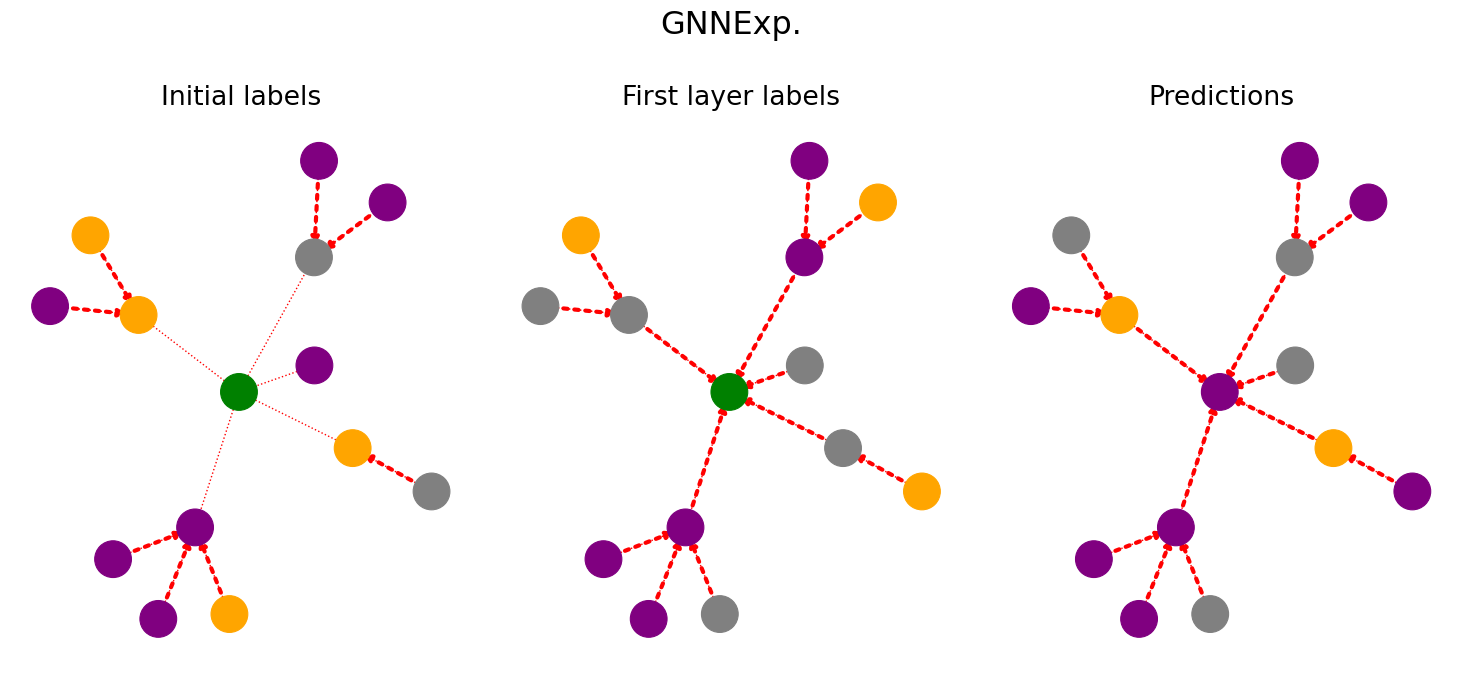

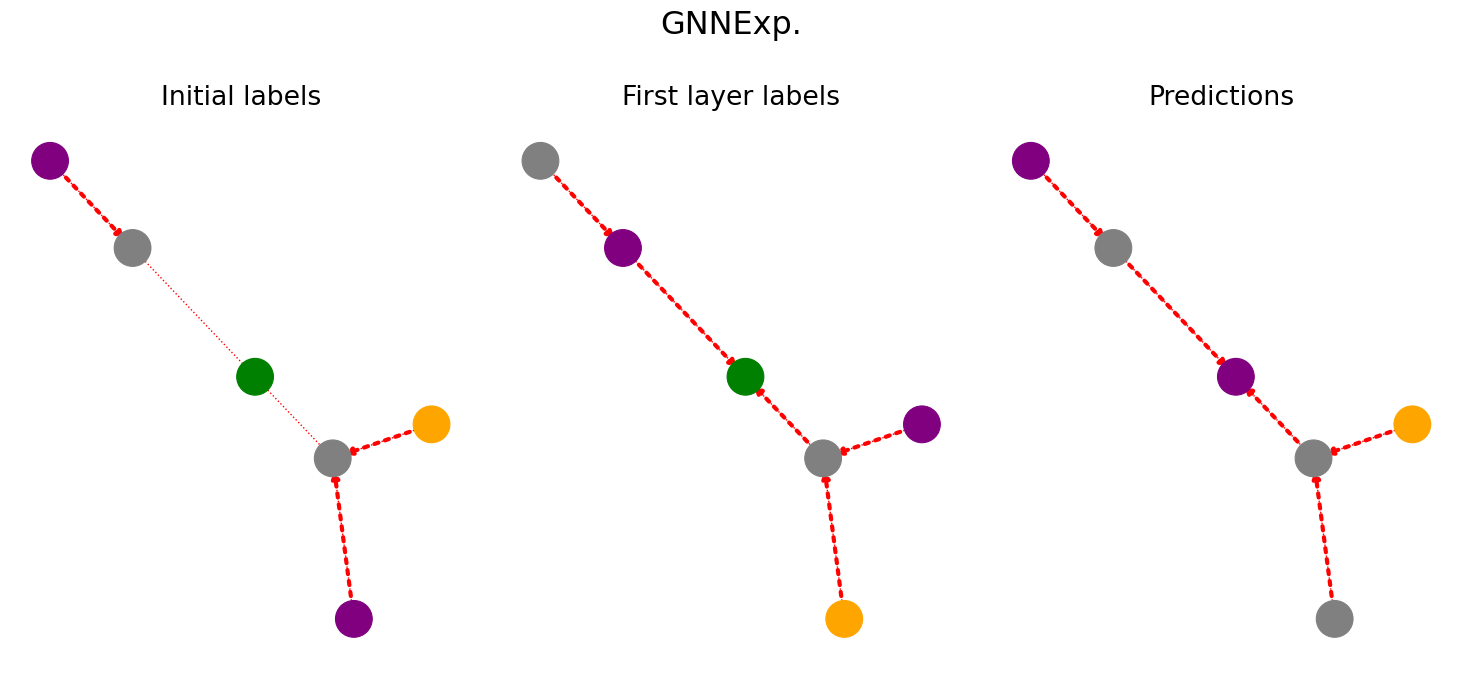

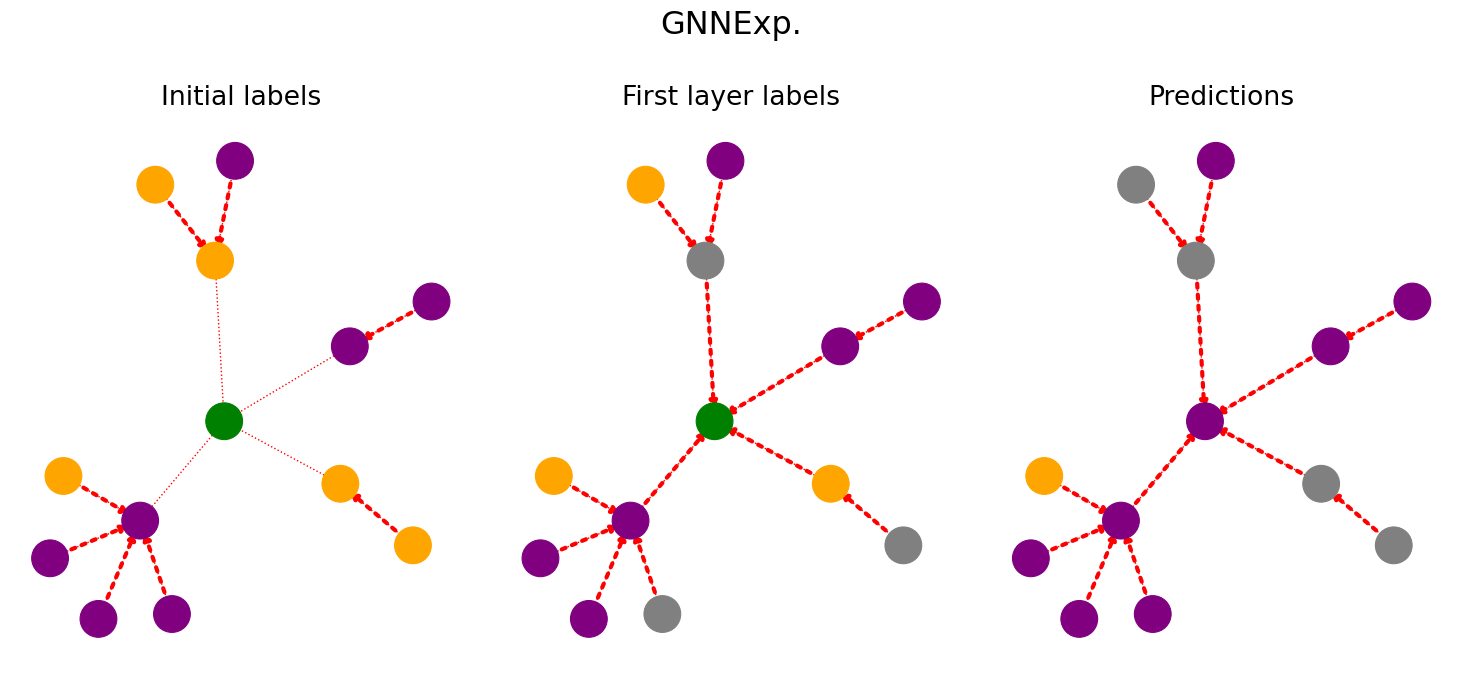

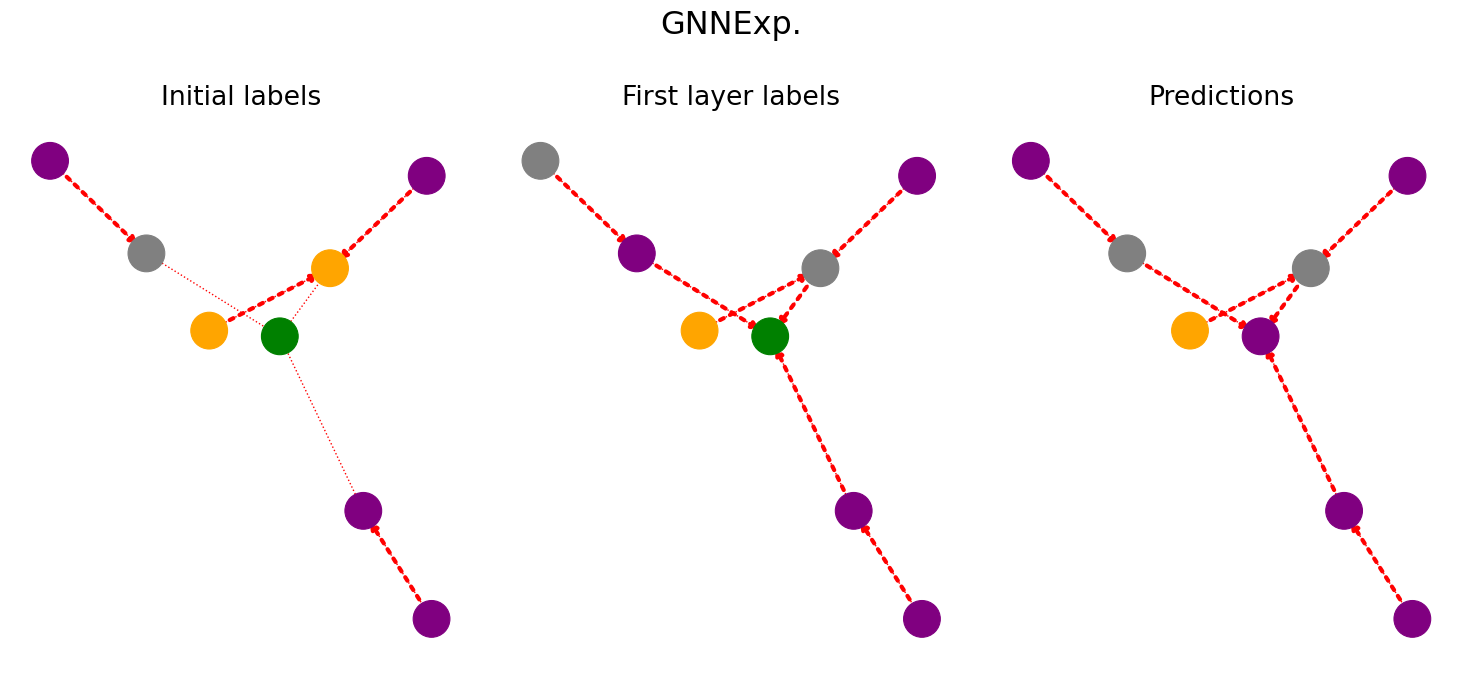

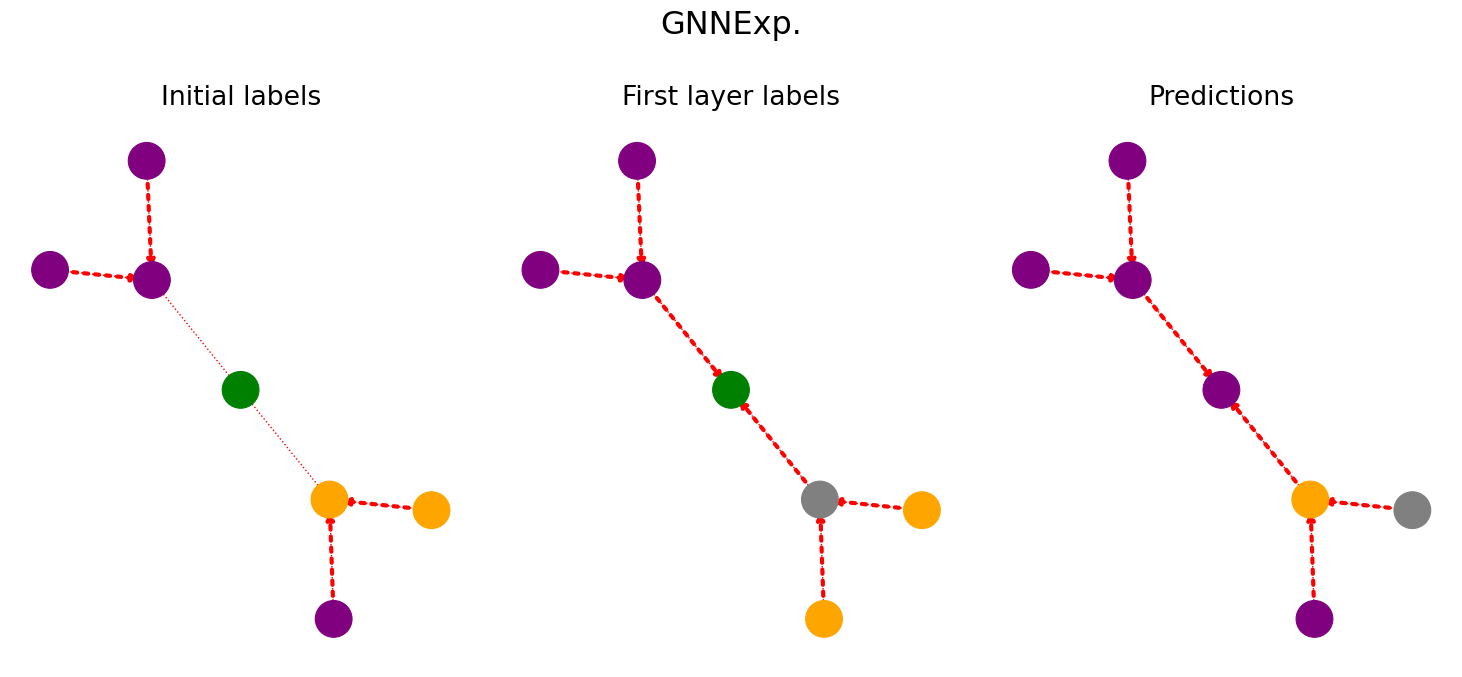

100%|██████████| 1/1 [11:24<00:00, 684.96s/it]

     node_idx                   explainer  pr_auc   roc_auc    f1  \
0         346         IntegratedGradients   1.000  1.000000  1.00   
1         571         IntegratedGradients   1.000  1.000000  1.00   
2         191         IntegratedGradients   1.000  1.000000  1.00   
3         339         IntegratedGradients   1.000  1.000000  1.00   
4         809         IntegratedGradients   1.000  1.000000  1.00   
..        ...                         ...     ...       ...   ...   
295       619  GNNExplainer__epochs_10000   0.675  0.999577  0.80   
296       334  GNNExplainer__epochs_10000   1.000  1.000000  1.00   
297       780  GNNExplainer__epochs_10000   1.000  1.000000  1.00   
298       915  GNNExplainer__epochs_10000   1.000  1.000000  0.75   
299       582  GNNExplainer__epochs_10000   1.000  1.000000  1.00   

     false_negatives  false_positives  difficult_false_positives  
0                0.0         0.000000                        NaN  
1                0.0         0.000000

In [3]:
import seaborn as sns

sns.set_context('paper', font_scale=2)
def run_experiment(
    dataset_type,
    model,
    num_nodes,
    p_edge,
    homophily,
    labelled_fraction,
    seed=0,
    device='cpu',
    n_layers=2,
    **kwargs,
):
    seed_everything(seed)

    explainers_and_kwargs = (
        (ig_explainer, {}),
        #(saliency_explainer, {'post_process': True, 'threshold': 0.05}),
        #(LRP_explainer, {}),
        (deconvolution_explainer, {}),
        #(random_explainer, {}),
        (gnn_explainer, {"epochs": 10000}),
        #(graphmask_explainer, {}),

        #(SubgraphX_explainer, {}),
    )

    if dataset_type == "ER":
        dataset = datasets.ERGraphDataset(
            seed, num_nodes=num_nodes, p=p_edge,
        )
    else:
        raise NotImplementedError
    
    model_name = model.__class__.__name__

    data = dataset.generate(model_name=model_name, labelled_fraction=labelled_fraction, homophily=homophily)
    data.to(device)
    model.to(device)
    output = model(data.x, data.edge_index)
    preds = torch.tensor([1 if x>0.5 else 0 if x<0.5 else x for x in output])
    
    if model_name == 'LPModel':
        one_layer_model = models.LPModel(num_iter=1)
    elif model_name == 'UnbalancedLPModel':
        one_layer_model = models.UnbalancedLPModel(num_iter=1, weights=model.weights)


    og_labels = ((data.x@torch.tensor([1, -1], dtype=torch.float32)).to(torch.long)+1)/2

    first_round_labels = one_layer_model(data.x, data.edge_index)
    first_round_labels = torch.tensor([1 if x>0.5 else 0 if x<0.5 else x  for x in first_round_labels])

    #relevant_node_ids = torch.where(output != 0.5)[0].cpu().tolist()
    if model_name == 'OneLabelLPModel':
        relevant_node_ids = torch.where(output > 0.5)[0].cpu().tolist()
    else:
        relevant_node_ids = torch.where((output != 0.5) & (og_labels==0.5))[0].cpu().tolist()

    if len(relevant_node_ids) > 100:
        # random sample 100 nodes
        relevant_node_ids = np.random.choice(relevant_node_ids, 100, replace=False).tolist()
    gt_importances = []

    if model_name == 'LPModel':
        gt_importances = gt.compute_importances_LPModel(relevant_node_ids, data)
    elif model_name == 'UnbalancedLPModel':
        weights = model.weights
        gt_importances = gt.compute_importances_UnbalancedLPModel(relevant_node_ids, data, weights)
    elif model_name == 'ECModel':
        gt_importances = gt.compute_importances_ECModel(relevant_node_ids, data)
    elif model_name == 'OneLabelLPModel':
        gt_importances = gt.compute_importances_OneLabelLPModel(relevant_node_ids, data, n_layers)
    else:
        raise NotImplementedError


    results = []

    for explainer, kwargs_explainer in explainers_and_kwargs:

        seed_everything(seed) # a second seed for a reproducible explanation
        explainer_instance = explainer(model, data, **kwargs_explainer)
        explainer_name = str(explainer_instance)
        print(explainer_name)
        explaination_histogram = []
        
        counter_a = 0
        counter_b = 0
        explainer_results =  []

        for k, node_idx in enumerate(relevant_node_ids):
            explanation_results = {}
            explanation_results["node_idx"] = node_idx
            explanation_results["explainer"] = explainer_name
            explanation = explainer_instance.explain(node_idx).detach().cpu().numpy()

            curr_gt_explanation = gt_importances[k]['positive']

            curr_gt_neg = gt_importances[k]['negative']
            curr_gt_difficult_neg = gt_importances[k]['difficult_negative']

            pr_curve = precision_recall_curve(curr_gt_explanation, explanation)
            explanation_results["pr_auc"] = auc(pr_curve[1], pr_curve[0])

            explanation_results["roc_auc"] = roc_auc_score(curr_gt_explanation, explanation)

            thresh = 0.5 if explainer_name == 'GNNExplainer__epochs_10000' else 0
            binarized_exp = np.where(explanation > thresh, 1, 0)
            explanation_results["f1"] = f1_score(curr_gt_explanation, binarized_exp)

            false_negatives = np.sum((binarized_exp == 0) & (curr_gt_explanation))
            explanation_results["false_negatives"] = false_negatives / np.sum(curr_gt_explanation)
            
            false_positives = np.sum((binarized_exp == 1) & (curr_gt_neg))
            explanation_results["false_positives"] = false_positives / np.sum(curr_gt_neg)

            difficult_false_positives = np.sum((binarized_exp == 1) & (curr_gt_difficult_neg))
            explanation_results["difficult_false_positives"] = difficult_false_positives / np.sum(curr_gt_difficult_neg)

            explainer_results.append(explanation_results)


            explaination_histogram.extend(explanation[explanation != 0].tolist())

            fp_edge_mask = torch.tensor((binarized_exp == 1) & (curr_gt_explanation == 0))
            tp_edge_mask = torch.tensor((binarized_exp == 1) & (curr_gt_explanation == 1))
            fn_edge_mask = torch.tensor((binarized_exp == 0) & (curr_gt_explanation == 1))


            if fp_edge_mask.sum() > 0 and explainer_name != 'Random':

                fig, axs = plt.subplots(1, 3, figsize=(15, 7))
#                print('NODE IDX:', node_idx)
#                print('PRED:', preds[node_idx])
#                print('OUTPUT:', output[node_idx])
                edge_mask = ~fp_edge_mask
                output_change = model(data.x, data.edge_index[:, edge_mask])
                # print('OUTPUT CHANGE:', output_change[node_idx])
                # print('WRONG EDGES:', data.edge_index[:, fp_edge_mask])

                relevant_edges = data.edge_index[:, binarized_exp == 1]
                relevant_edges = torch.cat([relevant_edges, relevant_edges.flip(0)], dim=1)
                relevant_edges = relevant_edges.cpu().numpy().T
                relevant_edges = [tuple(edge) for edge in relevant_edges]

                irrelevant_edges = data.edge_index[:, binarized_exp == 0]
                irrelevant_edges = torch.cat([irrelevant_edges, irrelevant_edges.flip(0)], dim=1)
                irrelevant_edges = irrelevant_edges.cpu().numpy().T
                irrelevant_edges = [tuple(edge) for edge in irrelevant_edges]


                wrong_edges = data.edge_index[:, fp_edge_mask]
                wrong_edges = torch.cat([wrong_edges, wrong_edges.flip(0)], dim=1)
                wrong_edges = wrong_edges.cpu().numpy().T
                wrong_edges = [tuple(edge) for edge in wrong_edges]

                

                right_edges = data.edge_index[:, tp_edge_mask]
                right_edges = torch.cat([right_edges, right_edges.flip(0)], dim=1)
                right_edges = right_edges.cpu().numpy().T
                right_edges = [tuple(edge) for edge in right_edges]

                g = tgu.to_networkx(data, to_undirected=True)
                subgraph = nx.ego_graph(g, node_idx, radius=2)

                nodes_in_wrong_edges = np.unique([node for edge in wrong_edges for node in edge])
                #nodes_to_remove = [node for node in subgraph.nodes if( (node not in nodes_in_wrong_edges) and (node != node_idx))]

                #subgraph.remove_nodes_from(nodes_to_remove)

                # set edge color to the explanation
                edge_colors = ['red' if edge in irrelevant_edges else 'black' for edge in subgraph.edges]

                node_neighs = data.edge_index[0, data.edge_index[1]==node_idx].cpu().unique().tolist()
                arrow_edge_list = []
                for edge in subgraph.edges:
                    if edge[0] in node_neighs:
                        if edge[1] != node_idx:
                            arrow_edge_list.append((edge[1], edge[0]))
                        if edge[1] in node_neighs:
                            arrow_edge_list.append(edge)
                    elif edge[0] != node_idx and edge[1] in node_neighs:
                        arrow_edge_list.append(edge)
                arrow_edge_colors = ['red' if edge in irrelevant_edges else 'green' if edge in relevant_edges else 'black' for edge in arrow_edge_list]
                arrow_edge_styles = [':' if edge in irrelevant_edges else '-' for edge in arrow_edge_list]
                        


                # set node color to og_labels
                start_labels = ['purple' if og_labels[node]==1 else 'grey' if og_labels[node]==0.5 else 'orange' for node in subgraph.nodes]

                first_labelling = ['purple' if (first_round_labels[node]==1) else 'grey' if (first_round_labels[node]==0.5) else 'orange' for node in subgraph.nodes]

                final_label = ['purple' if preds[node]==1 else 'grey' if preds[node]==0.5 else 'orange' for node in subgraph.nodes]



                for n, node in enumerate(subgraph.nodes):
                    if node == node_idx:
                        start_labels[n] = 'green'
                        first_labelling[n] = 'green'
                        #final_label[k] = 'orange'


                #nx.relabel_nodes(subgraph, {node_idx: 'T'}, copy=False)
                # position the node_idx in the center
                pos = nx.spring_layout(subgraph)
                pos[node_idx] = np.array([0, 0])

                nx.draw(subgraph, with_labels=False, pos=pos, node_color=start_labels, edge_color=edge_colors, ax=axs[0], node_size=700, font_color='white', style=':')
                nx.draw_networkx_edges(subgraph, pos=pos, edgelist=arrow_edge_list, edge_color=arrow_edge_colors, ax=axs[0], arrows=True, style=arrow_edge_styles, arrowstyle='-|>', width=3)
                axs[0].set_title('Initial labels')

                for edge in subgraph.edges:
                    if edge[0] in node_neighs and edge[1] == node_idx:
                        arrow_edge_list.append((edge))
                        
                    elif edge[0] == node_idx:
                        arrow_edge_list.append((edge[1], edge[0]))

                arrow_edge_colors = ['red' if edge in irrelevant_edges else 'green' if edge in relevant_edges else 'black' for edge in arrow_edge_list]
                arrow_edge_styles = [':' if edge in irrelevant_edges else '-' for edge in arrow_edge_list]
                nx.draw(subgraph, with_labels=False, pos=pos, node_color=first_labelling, edge_color=edge_colors, ax=axs[1], node_size=700, font_color='white', style=':')
                nx.draw_networkx_edges(subgraph, pos=pos, edgelist=arrow_edge_list, edge_color=arrow_edge_colors, ax=axs[1], arrows=True, style=arrow_edge_styles,arrowstyle='-|>', width=3)
                axs[1].set_title('First layer labels')

                nx.draw(subgraph, with_labels=False, pos=pos, node_color=final_label, edge_color=edge_colors, ax=axs[2], node_size=700, font_color='white', style=':')
                nx.draw_networkx_edges(subgraph, pos=pos, edgelist=arrow_edge_list, edge_color=arrow_edge_colors, ax=axs[2], arrows=True, style=arrow_edge_styles, arrowstyle='-|>', width=3)
                axs[2].set_title('Predictions')

                
                
                fig_name = 'IG, LRP and Deconv.' if explainer_name == 'IntegratedGradients' or explainer_name == 'LRP' else 'Decov.' if explainer_name == 'Deconvolution' else 'GNNExp.'
                fig.suptitle(f'{fig_name}')
                fig.tight_layout()
                fig.savefig(f'../src/results/figures/{explainer_name}__p_{p_edge}__h_{homophily:.2f}__lf_{labelled_fraction:.2f}__node_{node_idx}__seed_{seed}_wrong.pdf')

                plt.show()

                counter_a += 1
            if fn_edge_mask.sum() > 0 and counter_b<5 and explainer_name != 'Random':

                # as above
                fig, axs = plt.subplots(1, 3, figsize=(15, 7))
                # print('NODE IDX:', node_idx)
                # print('PRED:', preds[node_idx])
                # print('OUTPUT:', output[node_idx])
                edge_mask = ~fn_edge_mask
                output_change = model(data.x, data.edge_index[:, edge_mask])
                # print('OUTPUT CHANGE:', output_change[node_idx])
                # print('WRONG EDGES:', data.edge_index[:, fn_edge_mask])

                wrong_edges = data.edge_index[:, fn_edge_mask]
                wrong_edges = torch.cat([wrong_edges, wrong_edges.flip(0)], dim=1)
                wrong_edges = wrong_edges.cpu().numpy().T
                wrong_edges = [tuple(edge) for edge in wrong_edges]

                right_edges = data.edge_index[:, tp_edge_mask]
                right_edges = torch.cat([right_edges, right_edges.flip(0)], dim=1)
                right_edges = right_edges.cpu().numpy().T
                right_edges = [tuple(edge) for edge in right_edges]

                g = tgu.to_networkx(data, to_undirected=True)
                first_neigh_idx = torch.where(data.edge_index[1]==node_idx)[0]
                subgraph = nx.ego_graph(g, node_idx, radius=2)
    
                nodes_in_wrong_edges = np.unique([node for edge in wrong_edges for node in edge])
                nodes_to_remove = [node for node in subgraph.nodes if node not in nodes_in_wrong_edges]

                subgraph.remove_nodes_from(nodes_to_remove)

                # set edge color to the explanation
                edge_colors = ['red' if edge in wrong_edges else 'black' for edge in subgraph.edges]

                node_neighs = data.edge_index[0, data.edge_index[1]==node_idx].cpu().unique().tolist()
                arrow_edge_list = []
                for edge in subgraph.edges:
                    if edge[0] in node_neighs:
                        if edge[1] != node_idx:
                            arrow_edge_list.append((edge[1], edge[0]))
                        if edge[1] in node_neighs:
                            arrow_edge_list.append(edge)
                    elif edge[0] != node_idx and edge[1] in node_neighs:
                        arrow_edge_list.append(edge)
                arrow_edge_colors = ['red' if edge in wrong_edges else 'green' if edge in right_edges else 'black' for edge in arrow_edge_list]
                        

                # set node color to og_labels
                start_labels = ['purple' if og_labels[node]==1 else 'grey' if og_labels[node]==0.5 else 'orange' for node in subgraph.nodes]

                first_labelling = ['purple' if (first_round_labels[node]==1) else 'grey' if (first_round_labels[node]==0.5) else 'orange' for node in subgraph.nodes]

                final_label = ['purple' if preds[node]==1 else 'grey' if preds[node]==0.5 else 'orange' for node in subgraph.nodes]


                for n, node in enumerate(subgraph.nodes):
                    if node == node_idx:
                        start_labels[n] = 'green'
                        first_labelling[n] = 'green'
                        #final_label[k] = 'orange'


                #nx.relabel_nodes(subgraph, {node_idx: 'T'}, copy=False)
                # position the node_idx in the center
                pos = nx.spring_layout(subgraph)
                pos[node_idx] = np.array([0, 0])

                nx.draw(subgraph, with_labels=True, pos=pos, node_color=start_labels, edge_color=edge_colors, ax=axs[0])
                nx.draw_networkx_edges(subgraph, pos=pos, edgelist=arrow_edge_list, edge_color=arrow_edge_colors, ax=axs[0], arrows=True, arrowstyle='-|>', width=3)
                axs[0].set_title('Initial labels')

                for edge in subgraph.edges:
                    if edge[0] in node_neighs and edge[1] == node_idx:
                        arrow_edge_list.append((edge))
                    elif edge[0] == node_idx:
                        arrow_edge_list.append((edge[1], edge[0]))
                arrow_edge_colors = ['red' if edge in wrong_edges else 'green' if edge in right_edges else 'black' for edge in arrow_edge_list]

                nx.draw(subgraph, with_labels=True, pos=pos, node_color=first_labelling, edge_color=edge_colors, ax=axs[1])
                nx.draw_networkx_edges(subgraph, pos=pos, edgelist=arrow_edge_list, edge_color=arrow_edge_colors, ax=axs[1], arrows=True, arrowstyle='-|>', width=3)
                axs[1].set_title('First layer labels')

                nx.draw(subgraph, with_labels=True, pos=pos, node_color=final_label, edge_color=edge_colors, ax=axs[2])
                nx.draw_networkx_edges(subgraph, pos=pos, edgelist=arrow_edge_list, edge_color=arrow_edge_colors, ax=axs[2], arrows=True, arrowstyle='-|>', width=3)
                axs[2].set_title('Predictions')

                fig.suptitle(f'False negative explanation, {explainer_name}')
                plt.show()

                counter_b += 1

            del explanation
            torch.cuda.empty_cache()
        # print explanation histogram
        if False:
            fig, ax = plt.subplots()
            ax.hist(explaination_histogram, bins=100,range=(-0.1, 0.1))
            fig.suptitle(f'{explainer_name} explanation histogram, p_edge={p_edge}')
            plt.show()
            fig.savefig(f'src/results/{explainer_name}__p_{p_edge}__h_{homophily:.2f}__lf_{labelled_fraction:.2f}.png')

    

        results.extend(explainer_results)


        del explainer_instance
        torch.cuda.empty_cache()
    
    del data
    torch.cuda.empty_cache()
    results = pd.DataFrame(results)
    print(results)
    return results    

full_results = []
homophily = 0.1

device = 'cpu'


for labelled_fraction in [0.8,]:#[0.01, 0.05, 0.1, 0.25, 0.5]:

    Params = namedtuple("Params", "dataset_type, num_nodes,  p_edge, homophily, labelled_fraction, n_layers, weight_scale")

    params = [

        #Params("ER", 1000, 0.05, homophily, labelled_fraction, 2, 1),

        Params("ER", 1000, 0.002, homophily, labelled_fraction, 2, 1),

    ]

    params_seed = [(p, 3030 + seed) for seed in range(1) for p in params]

    WHITEBOX_TYPES = [
       models.LPModel, #models.UnbalancedLPModel, #   #, models.ECModel, models.OneLabelLPModel, #  #
    ]


    for param, seed in tqdm(params_seed):
        for whitebox_type in WHITEBOX_TYPES:
                whitebox = whitebox_type(**param._asdict())
                print(whitebox.__class__.__name__) 
                results = run_experiment(
                    model=whitebox,
                    seed=seed,
                    device=device,
                    **param._asdict(),
                )
                run_results = param._asdict().copy()
                run_results['seed']  = seed
                run_results['whitebox'] = whitebox.__class__.__name__
                
                for key, value in run_results.items():
                    results[key] = value
                
                #results.to_csv(f'results/partial/ER__p_{param.p_edge}__h_{param.homophily:.2f}__lf_{param.labelled_fraction:.2f}__{whitebox.__class__.__name__}__s_{seed}.csv')
                full_results.append(results)

df_full_results = pd.concat(full_results)